In [ ]:
# === GATE 3A (LOCKED – DO NOT MODIFY) ===

## Large-N Filament Eulerian Circulation
## Empirical Expansion Using Fixed Estimator and Velocity Backend

# This notebook implements Gate 3A of the filament-scale Eulerian circulation
# program. The goal of Gate 3A is to empirically expand the sample size (larger N)
# using the same filament definition, estimator geometry, and velocity backend
# validated in earlier gates.

# This stage is strictly model-agnostic and purely empirical.
# No physical interpretation, reconstruction, or theory comparison is performed
# in this notebook.

### Authoritative Data Sources

# **Filament Geometry**
# - Filament geometry is derived from the SDSS DisPerSE skeleton:
#   `sdss_disperse_skeleton.NDskl`
# - Stage-2 filament selections are constructed from this source using explicit,
#   logged selection criteria within this notebook.
# - Stage-1 filament tables may be referenced for comparison only and are not
#   used as privileged inputs.

# **Velocity Field**
# - The large-scale velocity field is treated as an Eulerian observable.
# - Velocity grid / lookup assets are loaded from:
#   - `derived/velocity_assets/`
# - No galaxy spins, halo properties, or Lagrangian quantities are used.

### Estimator Code (Frozen)

# - Cylindrical ring estimators for tangential velocity and circulation are
#   implemented in:
#   - `lib/filament_estimator.py`
# - Estimator mathematics and geometry are inherited unchanged from prior gates.
# - Any deviation would require explicit logging and gate reclassification.

### Outputs and Reproducibility

# - All circulation measurements, null tests, and statistics are recomputed
#   from scratch in this notebook.
# - Output products are written to Gate-3A-specific directories and are isolated
#   from Stage-1 and Stage-2 legacy outputs.

### Scope and Constraints

# - This analysis is strictly empirical.
# - No cosmological, gravitational, or structure-formation model is assumed.
# - Conclusions are limited to:
#   - persistence or degradation of the circulation signal at larger N,
#   - scale dependence under increased sampling,
#   - statistical robustness and null-test behavior.

# Any physical or theoretical interpretation is explicitly deferred to
# later gates and separate documents.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob

# Try to auto-find a repo folder that contains lib/filament_estimator.py
candidates = glob.glob("/content/drive/MyDrive/**/lib/filament_estimator.py", recursive=True)

if not candidates:
    print("ERROR: Could not find lib/filament_estimator.py anywhere under MyDrive.")
    print("Fix: Put your repo folder (with lib/ and derived/) somewhere under MyDrive, then rerun.")
else:
    repo_root = os.path.dirname(os.path.dirname(candidates[0]))  # .../lib/filament_estimator.py -> repo root
    os.chdir(repo_root)
    print("Repo root set to:", repo_root)
    print("Contents:", sorted(os.listdir(repo_root))[:20])

Mounted at /content/drive
Repo root set to: /content/drive/MyDrive/SFH_filaments
Contents: ['ReadMe', 'derived', 'filaments.dat', 'galaxies.dat.gz', 'gate2_outputs', 'gate3A_outputs', 'lib', 'outputs', 'phase1_outputs', 'sdss_disperse_skeleton.NDskl']


In [ ]:
# === GATE 3A — TRUTH / STATUS CELL (READ ONLY) ===

import os, sys, hashlib, datetime, platform

def file_info(path):
    if not os.path.exists(path):
        return {"exists": False}
    stat = os.stat(path)
    return {
        "exists": True,
        "size_MB": round(stat.st_size / 1e6, 3),
        "mtime": datetime.datetime.fromtimestamp(stat.st_mtime).isoformat(timespec="seconds"),
    }

def sha256_of_file(path, block_size=65536):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for block in iter(lambda: f.read(block_size), b""):
            h.update(block)
    return h.hexdigest()

print("=== GATE 3A — TRUTH / STATUS CELL ===\n")

# ---------------------------------------------------------------------
# Notebook identity / working directory
# ---------------------------------------------------------------------
print("Working directory:")
print("  CWD            :", os.getcwd())
print("  Timestamp (UTC):", datetime.datetime.now(datetime.UTC).isoformat(timespec="seconds"))

# ---------------------------------------------------------------------
# Filament source (authoritative geometry)
# ---------------------------------------------------------------------
FILAMENT_SOURCE = "sdss_disperse_skeleton.NDskl"
skl_path = os.path.join(os.getcwd(), FILAMENT_SOURCE)

print("\nFilament Geometry Source:")
print("  DisPerSE skeleton :", FILAMENT_SOURCE)
print("  Path              :", skl_path)
skl_info = file_info(skl_path)
print("  Exists            :", skl_info["exists"])
if skl_info["exists"]:
    print("  Size MB           :", skl_info["size_MB"])
    print("  Modified          :", skl_info["mtime"])

# ---------------------------------------------------------------------
# Derived tables (not authoritative inputs)
# ---------------------------------------------------------------------
stage1_table = "derived/filament_master_table_stage1.csv"
full_table   = "derived/filament_master_table.csv"

print("\nDerived Filament Tables (reference only):")
for label, path in [("Stage-1 table", stage1_table),
                    ("Full table", full_table)]:
    info = file_info(path)
    print(f"  {label}:")
    print("    Path    :", path)
    print("    Exists  :", info["exists"])
    if info["exists"]:
        print("    Size MB :", info["size_MB"])
        print("    Modified:", info["mtime"])

# ---------------------------------------------------------------------
# Velocity backend
# ---------------------------------------------------------------------
velocity_dir = "derived/velocity_assets"

print("\nVelocity Field Backend:")
print("  Directory :", velocity_dir)
print("  Exists    :", os.path.isdir(velocity_dir))

if os.path.isdir(velocity_dir):
    files = sorted([f for f in os.listdir(velocity_dir) if not f.startswith(".")])
    print("  File count:", len(files))
    if files:
        first = os.path.join(velocity_dir, files[0])
        last  = os.path.join(velocity_dir, files[-1])
        print("  First file:", files[0], "|", file_info(first))
        print("  Last file :", files[-1], "|", file_info(last))

# ---------------------------------------------------------------------
# Estimator code (frozen implementation)
# ---------------------------------------------------------------------
estimator_path = "lib/filament_estimator.py"

print("\nEstimator Implementation (Frozen):")
print("  Path   :", estimator_path)
print("  Exists :", os.path.exists(estimator_path))
if os.path.exists(estimator_path):
    print("  SHA256 :", sha256_of_file(estimator_path))

# ---------------------------------------------------------------------
# Execution environment
# ---------------------------------------------------------------------
print("\nExecution Environment:")
print("  Python version :", sys.version.split()[0])
print("  Platform       :", platform.platform())

# ---------------------------------------------------------------------
# Hard-gate checks (stop here if missing critical assets)
# ---------------------------------------------------------------------
missing = []
if not os.path.exists(estimator_path):
    missing.append(estimator_path)
if not os.path.isdir(velocity_dir):
    missing.append(velocity_dir)
if not os.path.exists(skl_path):
    missing.append(skl_path)

if missing:
    raise FileNotFoundError("CRITICAL: Missing required Gate-3A assets:\n  - " + "\n  - ".join(missing))

print("\nSTATUS: ✅ Required assets present. Safe to proceed.")
print("\n=== END TRUTH / STATUS CELL ===")

=== GATE 3A — TRUTH / STATUS CELL ===

Working directory:
  CWD            : /content/drive/MyDrive/SFH_filaments
  Timestamp (UTC): 2026-02-07T14:00:28+00:00

Filament Geometry Source:
  DisPerSE skeleton : sdss_disperse_skeleton.NDskl
  Path              : /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl
  Exists            : True
  Size MB           : 33.87
  Modified          : 2022-06-07T13:18:24

Derived Filament Tables (reference only):
  Stage-1 table:
    Path    : derived/filament_master_table_stage1.csv
    Exists  : True
    Size MB : 0.006
    Modified: 2026-01-17T16:15:01
  Full table:
    Path    : derived/filament_master_table.csv
    Exists  : True
    Size MB : 7.92
    Modified: 2026-01-17T16:15:19

Velocity Field Backend:
  Directory : derived/velocity_assets
  Exists    : True
  File count: 3
  First file: CF4_empirical | {'exists': True, 'size_MB': 0.004, 'mtime': '2026-01-25T15:31:39'}
  Last file : vel_grid_analytic_swirl_v1.npz | {'exists': Tru

In [ ]:
### Cell 1
# Environment Setup and Reproducibility (Gate 3A)
# Configures environment, mounts Drive, pins the working directory to the repo root,
# declares Stage-2 (large-N) as the active filament table, and creates an isolated
# Gate-3A run output directory.
# No data processing or analysis is performed in this cell.

# ============================================================
# Environment & reproducibility setup
# ============================================================

import os
import sys
import json
import zipfile
import numpy as np
import pandas as pd
import random
import datetime

# ----------------------------
# Reproducibility
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ----------------------------
# Ring sampling resolution (GLOBAL; Gate 3A standard)
# ----------------------------
# Number of azimuthal samples per ring used by ring_mean_vphi().
# Must remain fixed across real and null runs for comparability.
NPHI = 64
print("Ring sampling NPHI =", NPHI)

# ----------------------------
# Mount Google Drive
# ----------------------------
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# Base project path (authoritative)
# ----------------------------
PROJECT_ROOT = "/content/drive/MyDrive/SFH_filaments"
if not os.path.isdir(PROJECT_ROOT):
    raise FileNotFoundError(f"Project root not found: {PROJECT_ROOT}")

# Pin working directory to project root (prevents path drift)
os.chdir(PROJECT_ROOT)

# ----------------------------
# Gate declaration (LOCKED)
# ----------------------------
GATE = "3A"   # Large-N empirical expansion
print(f"Active Gate: {GATE}")

# ----------------------------
# Canonical subdirectories
# ----------------------------
PATHS = {
    "lib": os.path.join(PROJECT_ROOT, "lib"),
    "derived": os.path.join(PROJECT_ROOT, "derived"),
    "velocity_assets": os.path.join(PROJECT_ROOT, "derived", "velocity_assets"),
    "outputs": os.path.join(PROJECT_ROOT, "outputs"),
    "phase1_outputs": os.path.join(PROJECT_ROOT, "phase1_outputs"),
    "gate3A_outputs": os.path.join(PROJECT_ROOT, "gate3A_outputs"),
}

# Ensure Gate 3A output root exists BEFORE sanity checks (keeps logs clean)
os.makedirs(PATHS["gate3A_outputs"], exist_ok=True)

# Sanity checks
for key, path in PATHS.items():
    if not os.path.isdir(path):
        print(f"WARNING: missing directory → {key}: {path}")
    else:
        print(f"OK: {key} → {path}")

# ----------------------------
# Gate 3A run directory (isolated outputs per run)
# ----------------------------
RUNSTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
GATE3A_OUTDIR = os.path.join(PATHS["gate3A_outputs"], f"run_{RUNSTAMP}")
os.makedirs(GATE3A_OUTDIR, exist_ok=True)
print("Gate 3A output dir:", GATE3A_OUTDIR)

# ----------------------------
# Make estimator code importable
# ----------------------------
if PATHS["lib"] not in sys.path:
    sys.path.append(PATHS["lib"])

# Confirm estimator import
try:
    import filament_estimator
    print("Estimator loaded: filament_estimator.py")
except Exception as e:
    raise ImportError("Failed to import filament_estimator.py") from e

# ----------------------------
# Canonical data files (declared, not loaded yet)
# ----------------------------
FILAMENT_TABLE_STAGE1 = os.path.join(PATHS["derived"], "filament_master_table_stage1.csv")
FILAMENT_TABLE_FULL   = os.path.join(PATHS["derived"], "filament_master_table.csv")

# Gate 3A: Stage-2 default = FULL table (large N)
# Stage-1 is allowed only as reference/comparison.
if not os.path.isfile(FILAMENT_TABLE_FULL):
    raise FileNotFoundError(f"Missing FULL filament table required for Gate 3A: {FILAMENT_TABLE_FULL}")

if not os.path.isfile(FILAMENT_TABLE_STAGE1):
    print("NOTE: Stage-1 filament table not found (reference only).")

FILAMENT_TABLE_ACTIVE = FILAMENT_TABLE_FULL
print("Active filament table:", FILAMENT_TABLE_ACTIVE)

# ----------------------------
# Velocity assets hard check (Gate 3A requires this)
# ----------------------------
if not os.path.isdir(PATHS["velocity_assets"]):
    raise FileNotFoundError(f"Missing velocity assets directory: {PATHS['velocity_assets']}")

print("Environment setup complete.")

Ring sampling NPHI = 64
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Active Gate: 3A
OK: lib → /content/drive/MyDrive/SFH_filaments/lib
OK: derived → /content/drive/MyDrive/SFH_filaments/derived
OK: velocity_assets → /content/drive/MyDrive/SFH_filaments/derived/velocity_assets
OK: outputs → /content/drive/MyDrive/SFH_filaments/outputs
OK: phase1_outputs → /content/drive/MyDrive/SFH_filaments/phase1_outputs
OK: gate3A_outputs → /content/drive/MyDrive/SFH_filaments/gate3A_outputs
Gate 3A output dir: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_140034
Estimator loaded: filament_estimator.py
Active filament table: /content/drive/MyDrive/SFH_filaments/derived/filament_master_table.csv
Environment setup complete.


In [ ]:
# ============================================================
# Cell 2 — Data loading & validation (Gate 3A, no analysis)
# ============================================================

from pathlib import Path

# ----------------------------
# Load ACTIVE filament table (Gate 3A = Stage-2 / large-N)
# ----------------------------
df = pd.read_csv(FILAMENT_TABLE_ACTIVE)
print(f"Loaded ACTIVE filament table: {FILAMENT_TABLE_ACTIVE}")
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]:,}")

# Quick peek
display(df.head(3))

# Column overview (compact)
print("\n--- Column list (first 40) ---")
cols = list(df.columns)
print(cols[:40])
if len(cols) > 40:
    print(f"... (+{len(cols)-40} more columns)")

print("\n--- Dtypes summary ---")
print(df.dtypes.value_counts())

# ----------------------------
# Minimal sanity checks
# ----------------------------
if len(df) == 0:
    raise ValueError("Active filament table is empty — cannot proceed.")

# Common expected identifiers (heuristic only)
candidate_id_cols = [
    c for c in cols
    if "fid" in c.lower() or "fil" in c.lower() or "cp0" in c.lower()
]
print("\n--- Candidate ID / grouping columns (heuristic) ---")
print(candidate_id_cols[:30])

# Coordinate-ish columns (heuristic)
candidate_xyz = [
    c for c in cols
    if c.lower() in ("x","y","z","x_mpc","y_mpc","z_mpc","x_mpch","y_mpch","z_mpch")
]
candidate_ra_dec = [c for c in cols if "ra" in c.lower() or "dec" in c.lower()]
print("\n--- Candidate coordinate columns ---")
print("XYZ-like:", candidate_xyz)
print("RA/Dec-like:", candidate_ra_dec[:30])

# Truth list (Gate-3A audit)
if "fid" in df.columns:
    print("\n--- Gate 3A Truth List ---")
    print("Unique filaments:", df["fid"].nunique())
    print("First 50 fids:", sorted(df["fid"].unique())[:50])
else:
    print("\nWARNING: No 'fid' column detected — grouping will be inferred later.")

# ----------------------------
# Inventory velocity assets
# ----------------------------
vel_dir = Path(PATHS["velocity_assets"])
if not vel_dir.exists():
    raise FileNotFoundError(f"velocity_assets directory not found: {vel_dir}")

vel_files = sorted([p.name for p in vel_dir.iterdir()])
print("\n=== velocity_assets/ contents ===")
for name in vel_files:
    print(" -", name)

# If there is exactly one zip, record it automatically
zip_files = [p for p in vel_dir.iterdir() if p.suffix.lower() == ".zip"]
if len(zip_files) == 1:
    VELOCITY_ZIP = str(zip_files[0])
    print(f"\nDetected velocity zip: {VELOCITY_ZIP}")
elif len(zip_files) == 0:
    print("\nNo .zip found in velocity_assets/ (OK if assets are unpacked).")
else:
    print("\nMultiple .zip files found — selection will be explicit later:")
    for z in zip_files:
        print("  *", z.name)

# ----------------------------
# Inventory legacy outputs (reference only, not inputs)
# ----------------------------
phase_dir = Path(PATHS["phase1_outputs"])
phase_files = sorted([p.name for p in phase_dir.iterdir()]) if phase_dir.exists() else []
print("\n=== phase1_outputs/ contents (reference only) ===")
for name in phase_files:
    print(" -", name)

print("\nCell 2 complete: ACTIVE data loaded + assets inventoried.")

Loaded ACTIVE filament table: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_140034/filament_master_table_stage2.csv
Rows: 81,330  |  Columns: 15


,cp0,cp1,npts,x0,y0,z0,x1,y1,z1,cx,cy,cz,length_native,cpA,cpB
0,0,0,4,749.560,464.465,493.400,714.769,486.158,511.365,731.6380,472.4675,502.47675,49.926952,9811,9812
1,1,0,5,749.560,464.465,493.400,793.483,472.017,474.724,778.4584,469.8006,488.31600,59.609085,9811,9814
2,2,0,5,714.769,486.158,511.365,711.295,437.912,530.140,711.7924,457.9978,519.57860,57.547755,9812,9813



--- Column list (first 40) ---
['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']

--- Dtypes summary ---
float64    10
int64       5
Name: count, dtype: int64

--- Candidate ID / grouping columns (heuristic) ---
['cp0']

--- Candidate coordinate columns ---
XYZ-like: []
RA/Dec-like: []


=== velocity_assets/ contents ===
 - CF4_empirical
 - VAI.json
 - vel_grid_analytic_swirl_v1.npz

No .zip found in velocity_assets/ (OK if assets are unpacked).

=== phase1_outputs/ contents (reference only) ===
 - A1V3_axisnull_percentiles_by_filament.csv
 - A1V3_farposnull_percentiles_by_filament.csv
 - A1V3_filament_exceedance_vs_R.csv
 - A1V3_gamma_profiles_SEG.csv
 - A1V3_null_axis_envelope_meanAbsGamma.csv
 - A1V3_null_axis_randomized_FIL.csv
 - A1V3_null_far_envelope_meanAbsGamma.csv
 - A1V3_null_far_position_FIL.csv
 - A1V3_vphi_gamma_profiles_FIL.csv
 - A1V3_vphi_profiles_SEG.csv
 - P2B1_directional_RING_FIL.csv
 - P2B1_directional_RIN

In [ ]:
# ============================================================
# Cell 3 — Schema validation + velocity asset discovery
# (Gate 3A, still no circulation analysis)
# ============================================================

import os
from pathlib import Path

# ----------------------------
# 1) Strict schema validation (ACTIVE table)
# ----------------------------
# Gate 3A ACTIVE table uses:
#   cp0, cp1, npts,
#   x0,y0,z0,x1,y1,z1,
#   cx,cy,cz,
#   length_native
#
# For compatibility with older Gate-2 cells that expect 'length_mpc',
# we create an internal alias if needed.

REQUIRED_COLS = [
    "cp0", "cp1", "npts",
    "x0","y0","z0","x1","y1","z1",
    "cx","cy","cz",
    "length_native"
]

missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"ACTIVE filament table missing required columns: {missing}")

# Create alias expected by some downstream cells (no unit claim here)
if "length_mpc" not in df.columns:
    df["length_mpc"] = df["length_native"]
    print("NOTE: Created alias df['length_mpc'] = df['length_native'] for backward compatibility.")

# Basic sanity checks
if (df["length_mpc"] <= 0).any():
    bad = int((df["length_mpc"] <= 0).sum())
    raise ValueError(f"Found {bad} segments with non-positive length_mpc.")

print("OK: ACTIVE filament table schema validated.")

# Filament grouping quick stats
n_seg = len(df)
n_fil = df["cp0"].nunique()
print(f"Segments: {n_seg:,} | Unique filaments (cp0): {n_fil:,}")

seg_per_fil = df.groupby("cp0").size()
print("Segments per filament (min/median/max):",
      int(seg_per_fil.min()),
      float(seg_per_fil.median()),
      int(seg_per_fil.max()))

print("length_mpc (min/median/max):",
      float(df["length_mpc"].min()),
      float(df["length_mpc"].median()),
      float(df["length_mpc"].max()))

# ----------------------------
# 2) Velocity asset discovery
# ----------------------------
# We want the EMPIRICAL velocity backend (CF4/CF3 grid or equivalent),
# NOT the analytic swirl validation grid.
#
# This cell searches your SFH_filaments project tree for plausible assets.

SEARCH_EXT = {".npz", ".npy", ".pkl", ".pickle", ".h5", ".hdf5", ".json"}
KEYWORDS = ["cf4", "cf3", "vel", "velocity", "grid", "cosmicflows", "flow"]

root = Path(PROJECT_ROOT)

candidates = []
for p in root.rglob("*"):
    if p.is_file() and p.suffix.lower() in SEARCH_EXT:
        name = p.name.lower()
        score = sum(k in name for k in KEYWORDS)
        # exclude obvious non-velocity tables
        if "filament_master_table" in name:
            continue
        # keep anything with at least one keyword or any npz
        if score > 0 or p.suffix.lower() == ".npz":
            candidates.append((score, str(p)))

# sort best-first (more keyword hits)
candidates_sorted = sorted(candidates, key=lambda x: (-x[0], x[1]))

print("\n=== Velocity/asset candidates discovered under PROJECT_ROOT ===")
for score, path in candidates_sorted[:40]:
    print(f"[score={score}] {path}")

if len(candidates_sorted) > 40:
    print(f"... (+{len(candidates_sorted)-40} more)")

# Highlight likely "analytic swirl" so we don't accidentally use it as empirical
analytic_hits = [p for s, p in candidates_sorted if "analytic_swirl" in p.lower()]
if analytic_hits:
    print("\nWARNING: Found analytic swirl test grid(s) (validation only):")
    for p in analytic_hits:
        print("  -", p)

print("\nCell 3 complete.")

NOTE: Created alias df['length_mpc'] = df['length_native'] for backward compatibility.
OK: ACTIVE filament table schema validated.
Segments: 81,330 | Unique filaments (cp0): 63,391
Segments per filament (min/median/max): 1 1.0 8
length_mpc (min/median/max): 0.013923824256737 33.55207556202984 895.7459138930203

=== Velocity/asset candidates discovered under PROJECT_ROOT ===
[score=2] /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz
[score=2] /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B2_velocity_perturbation_meta_gaussianSmooth_sigma1p0.json

  - /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz

Cell 3 complete.


In [ ]:
# ============================================================
# Cell 3b — Velocity backend selection (Gate 3A, LOCKED choice)
# ============================================================

from pathlib import Path
import os

vel_root = Path(PATHS["velocity_assets"])

CF4_DIR = vel_root / "CF4_empirical"
ANALYTIC_NPZ = vel_root / "vel_grid_analytic_swirl_v1.npz"

print("Velocity backend check:")
print("  CF4 empirical dir exists :", CF4_DIR.exists(), "| is_dir:", CF4_DIR.is_dir())
print("  Analytic swirl exists    :", ANALYTIC_NPZ.exists(), "| is_file:", ANALYTIC_NPZ.is_file())

# Inventory CF4_empirical if present
if CF4_DIR.exists() and CF4_DIR.is_dir():
    cf4_items = sorted([p.name for p in CF4_DIR.iterdir()])
    print("\nCF4_empirical contents (first 30):")
    for name in cf4_items[:30]:
        print("  -", name)
    if len(cf4_items) > 30:
        print(f"  ... (+{len(cf4_items)-30} more)")

# Gate 3A policy: use EMPIRICAL backend if available; analytic swirl is validation-only.
if CF4_DIR.exists() and CF4_DIR.is_dir():
    VELOCITY_BACKEND = "CF4_empirical"
    VELOCITY_BACKEND_PATH = str(CF4_DIR)
    print("\nSelected VELOCITY_BACKEND:", VELOCITY_BACKEND)
    print("Path:", VELOCITY_BACKEND_PATH)
else:
    raise FileNotFoundError(
        "CRITICAL: CF4_empirical backend directory not found. "
        "Gate 3A requires empirical velocity backend. "
        "Analytic swirl grid is validation-only and must not be used for Gate 3A."
    )

Velocity backend check:
  CF4 empirical dir exists : True | is_dir: True
  Analytic swirl exists    : True | is_file: True

CF4_empirical contents (first 30):
  - CF4_new_128-z008_BoA.fits
  - CF4_new_128-z008_BoR.fits
  - CF4gp_new_128-z008_BoA.fits
  - CF4gp_new_128-z008_BoR.fits
  - CF4gp_new_64-z008_velocity.fits

Selected VELOCITY_BACKEND: CF4_empirical
Path: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical


In [ ]:
# ============================================================
# Cell 3c — Stage-2 analysis sample definition (Gate 3A)
# (selection only; no circulation analysis)
# ============================================================

import numpy as np

# Gate-3A selection defaults (LOGGED)
# These are *sample-definition* cuts, not estimator changes.
SEL = {
    "min_segments_per_filament": 5,   # raise if needed for stable axes
    "min_total_length": 10.0,         # in length_native units (alias length_mpc)
    "max_segment_length": None        # optional outlier suppression, e.g. 300.0
}
print("Stage-2 selection (LOGGED):", SEL)

g = df.groupby("cp0")

seg_count = g.size().rename("nseg")
tot_len = g["length_mpc"].sum().rename("Ltot")

fil_stats = pd.concat([seg_count, tot_len], axis=1).reset_index()

# Apply filament-level cuts
keep = (fil_stats["nseg"] >= SEL["min_segments_per_filament"]) & (fil_stats["Ltot"] >= SEL["min_total_length"])
keep_cp0 = set(fil_stats.loc[keep, "cp0"].values)

df_sel = df[df["cp0"].isin(keep_cp0)].copy()

# Optional: suppress absurd segment outliers (does not change estimator math)
if SEL["max_segment_length"] is not None:
    df_sel = df_sel[df_sel["length_mpc"] <= SEL["max_segment_length"]].copy()

print("\nStage-2 sample summary:")
print("  Filaments kept:", len(keep_cp0))
print("  Segments kept :", len(df_sel))
print("  Seg/fil (median):", float(df_sel.groupby("cp0").size().median()))

# Truth list (first 50)
print("  Truth List cp0 (first 50):", sorted(list(keep_cp0))[:50])

Stage-2 selection (LOGGED): {'min_segments_per_filament': 5, 'min_total_length': 10.0, 'max_segment_length': None}

Stage-2 sample summary:
  Filaments kept: 0
  Segments kept : 0
  Seg/fil (median): nan
  Truth List cp0 (first 50): []


In [ ]:
!head -n 80 /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl

ANDSKEL
3
#No comments (RB)
BBOX [-10.939,-3138.53,-1731.84] [3389.53,6406.3,3744.76]
[CRITICAL POINTS]
66388
3 1601.25 389.04 -922.68 0.0136125 15154 0
 1
 26077 21601
3 1593.71 777.538 -992.374 0.00719729 24918 0
 2
 26003 21504
 43946 49242
3 1512.74 1103.3 -1049.53 0.00971058 24755 0
 2
 25670 21058
 43683 48816
3 1455.44 1098.38 -1020.48 0.0104496 15040 0
 1
 25769 21188
3 1404.6 1087.43 -997.39 0.00955662 24771 0
 2
 42721 47160
 43695 48834
3 1187.27 1101.34 -905.678 0.00586253 24212 0
 1
 24583 19555
3 1819.67 542.128 -1049.21 0.0111552 25570 0
 1
 44910 50859
3 2000.59 859.709 -1200.74 0.00344484 25710 0
 2
 27287 23226
 45099 51186
3 1674.19 838.867 -1034.44 0.00714243 10572 0
 1
 12908 3858
3 1641.82 975.302 -1057.06 0.0119549 15049 0
 1
 25794 21222
3 1576.97 1013.95 -1031.15 0.0141381 24774 0
 1
 43717 48870
3 1290.72 942.963 -885.194 0.00119313 11209 0
 1
 15203 6790
3 1188.31 1215.28 -941.617 0.00894 24210 0
 2
 24851 19922
 42930 47517
3 1428.79 735.376 -872.757 0.06226

In [ ]:
!grep -n -E "^\[|FILAMENT|ARC|SEG|SKELETON" /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl | head -n 60

5:[CRITICAL POINTS]
259565:[FILAMENTS]
600852:[CRITICAL POINTS DATA]
667253:[FILAMENTS DATA]


In [ ]:
# ============================================================
# Cell 3d — Build Stage-2 filament master table from NDskl (Gate 3A)
# (FILAMENTS-only parsing; robust; no CP parsing)
# ============================================================

import os, math
import numpy as np
import pandas as pd

NDSKL_PATH = os.path.join(PROJECT_ROOT, "sdss_disperse_skeleton.NDskl")
STAGE2_OUT = os.path.join(GATE3A_OUTDIR, "filament_master_table_stage2.csv")

# Chunk polyline points into "segment rows"
CHUNK_N = 5          # points per segment-row
STEP = CHUNK_N - 1   # overlap by 1 point for continuity

def find_section(lines, tag):
    for i, l in enumerate(lines):
        if l.strip() == tag:
            return i
    raise ValueError(f"Section not found: {tag}")

def parse_ints_safe(s):
    try:
        return [int(x) for x in s.strip().split()]
    except Exception:
        return None

def parse_xyz_line(s):
    t = s.strip().split()
    if len(t) < 3:
        return None
    try:
        return float(t[0]), float(t[1]), float(t[2])
    except Exception:
        return None

print("Reading NDskl:", NDSKL_PATH)
with open(NDSKL_PATH, "r") as f:
    lines = f.readlines()

idx_fil = find_section(lines, "[FILAMENTS]")
idx_cpdata = find_section(lines, "[CRITICAL POINTS DATA]")

n_fil = int(lines[idx_fil + 1].strip())
print("Found [FILAMENTS] at line:", idx_fil, " | n_fil:", n_fil)
print("Found [CRITICAL POINTS DATA] at line:", idx_cpdata, "(used as FILAMENTS block end)")

rows = []
k = idx_fil + 2

fil_id = 0
while fil_id < n_fil and k < idx_cpdata:
    # Skip blank/comment lines
    line = lines[k].strip()
    if (not line) or line.startswith("#"):
        k += 1
        continue

    # Filament header formats vary. We support:
    #   (A) "cpA cpB npts"
    #   (B) "cpA cpB" then next line "npts"
    ints = parse_ints_safe(line)
    if ints is None:
        k += 1
        continue

    cpA = cpB = npts = None
    if len(ints) >= 3:
        cpA, cpB, npts = ints[0], ints[1], ints[2]
        k += 1
    elif len(ints) == 2:
        cpA, cpB = ints[0], ints[1]
        npts_line = lines[k+1].strip()
        npts_ints = parse_ints_safe(npts_line)
        if (npts_ints is None) or (len(npts_ints) < 1):
            k += 1
            continue
        npts = npts_ints[0]
        k += 2
    else:
        k += 1
        continue

    # Read npts xyz lines (skip non-xyz lines defensively)
    pts = []
    while len(pts) < npts and k < idx_cpdata:
        xyz = parse_xyz_line(lines[k])
        if xyz is not None:
            pts.append(xyz)
        k += 1

    pts = np.array(pts, dtype=float)
    if pts.shape[0] < 2:
        fil_id += 1
        continue

    # Convert polyline into overlapping segment-rows
    seg_idx = 0
    m = pts.shape[0]

    for s in range(0, m - 1, STEP):
        e = min(s + CHUNK_N - 1, m - 1)
        seg_pts = pts[s:e+1]
        if seg_pts.shape[0] < 2:
            continue

        x0, y0, z0 = seg_pts[0]
        x1, y1, z1 = seg_pts[-1]
        cx, cy, cz = seg_pts.mean(axis=0)

        dif = np.diff(seg_pts, axis=0)
        seg_len = float(np.sum(np.sqrt(np.sum(dif * dif, axis=1))))

        rows.append({
            "cp0": fil_id,     # filament id (Stage-2 grouping key)
            "cp1": seg_idx,    # segment index within filament
            "npts": int(seg_pts.shape[0]),
            "x0": float(x0), "y0": float(y0), "z0": float(z0),
            "x1": float(x1), "y1": float(y1), "z1": float(z1),
            "cx": float(cx), "cy": float(cy), "cz": float(cz),
            "length_native": seg_len,
            "cpA": int(cpA), "cpB": int(cpB)  # endpoints in CP index space (reference only)
        })
        seg_idx += 1

    fil_id += 1

df_stage2 = pd.DataFrame(rows)

print("\nStage-2 build complete.")
print("  Segment rows:", len(df_stage2))
print("  Unique filaments (cp0):", df_stage2["cp0"].nunique())

seg_per_fil = df_stage2.groupby("cp0").size()
print("  Segments/filament (min/median/max):",
      int(seg_per_fil.min()),
      float(seg_per_fil.median()),
      int(seg_per_fil.max()))

df_stage2.to_csv(STAGE2_OUT, index=False)
print("\nWrote Stage-2 table:", STAGE2_OUT)
print("Columns:", list(df_stage2.columns))

Reading NDskl: /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl
Found [FILAMENTS] at line: 259564  | n_fil: 63391
Found [CRITICAL POINTS DATA] at line: 600851 (used as FILAMENTS block end)

Stage-2 build complete.
  Segment rows: 81330
  Unique filaments (cp0): 63391
  Segments/filament (min/median/max): 1 1.0 8

Wrote Stage-2 table: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_140034/filament_master_table_stage2.csv
Columns: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']


In [ ]:
FILAMENT_TABLE_ACTIVE = STAGE2_OUT
print("FILAMENT_TABLE_ACTIVE set to:", FILAMENT_TABLE_ACTIVE)

FILAMENT_TABLE_ACTIVE set to: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_140034/filament_master_table_stage2.csv


In [ ]:
# we reran cell 2 and 3 a

In [ ]:
# ============================================================
# Cell 4 — Load & validate empirical CF4 velocity field
# ============================================================

from astropy.io import fits
import numpy as np

# ----------------------------
# Lock velocity source of truth
# ----------------------------
CF4_DIR = os.path.join(PATHS["velocity_assets"], "CF4_empirical")
CF4_FILE = os.path.join(CF4_DIR, "CF4gp_new_64-z008_velocity.fits")

if not os.path.isfile(CF4_FILE):
    raise FileNotFoundError(f"Empirical CF4 velocity file not found: {CF4_FILE}")

print("Using empirical velocity field:")
print(" →", CF4_FILE)

# ----------------------------
# Open FITS file (robust HDU selection)
# ----------------------------
with fits.open(CF4_FILE, memmap=True) as hdul:
    print("\n=== FITS HDU list ===")
    hdul.info()

    # Pick the first HDU that actually contains an array
    vel_data = None
    vel_header = None
    vel_hdu_index = None

    for i, h in enumerate(hdul):
        if getattr(h, "data", None) is not None:
            vel_data = h.data
            vel_header = h.header
            vel_hdu_index = i
            break

    if vel_data is None:
        raise ValueError("No HDU contained velocity data.")

    print(f"\nSelected HDU index for velocity data: {vel_hdu_index}")

# ----------------------------
# Inspect data structure
# ----------------------------
print("\n=== Velocity grid inspection ===")
print("Data type:", type(vel_data))
print("Data shape:", vel_data.shape)
print("Data dtype:", vel_data.dtype)
print("Data ndim :", vel_data.ndim)

# Header keywords of interest
print("\n=== Selected FITS header keywords ===")
for key in ["NAXIS", "NAXIS1", "NAXIS2", "NAXIS3", "NAXIS4",
            "CUNIT1", "CUNIT2", "CUNIT3",
            "CTYPE1", "CTYPE2", "CTYPE3",
            "CRVAL1", "CRVAL2", "CRVAL3",
            "CDELT1", "CDELT2", "CDELT3"]:
    if key in vel_header:
        print(f"{key:8s} : {vel_header[key]}")

# ----------------------------
# Sanity checks
# ----------------------------
if vel_data is None:
    raise ValueError("Velocity data array is empty.")

if vel_data.ndim not in (3, 4):
    raise ValueError(
        f"Unexpected velocity data dimensionality: {vel_data.ndim}. "
        "Expected 3D grid or 4D vector grid."
    )

# If 4D, identify where the vector component axis is (typically length 3)
if vel_data.ndim == 4:
    axes = vel_data.shape
    comp_axes = [ax for ax, n in enumerate(axes) if n == 3]
    if not comp_axes:
        print("WARNING: 4D array but no axis of length 3 detected (unexpected).")
    else:
        print("\nDetected possible component axis/axes (length=3):", comp_axes)
        print("NOTE: We will lock a component convention in the next cell before interpolation.")

print("\nCF4 velocity field loaded and validated.")

Using empirical velocity field:
 → /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4gp_new_64-z008_velocity.fits

=== FITS HDU list ===
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4gp_new_64-z008_velocity.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (64, 64, 64, 3)   float32   

Selected HDU index for velocity data: 0

=== Velocity grid inspection ===
Data type: <class 'numpy.ndarray'>
Data shape: (3, 64, 64, 64)
Data dtype: >f4
Data ndim : 4

=== Selected FITS header keywords ===
NAXIS    : 4
NAXIS1   : 64
NAXIS2   : 64
NAXIS3   : 64
NAXIS4   : 3

Detected possible component axis/axes (length=3): [0]
NOTE: We will lock a component convention in the next cell before interpolation.

CF4 velocity field loaded and validated.


In [ ]:
# ============================================================
# Cell 5 — Discover CF4 grid mapping from FITS headers/HDUs
# ============================================================

from astropy.io import fits
from pathlib import Path
import numpy as np
import os

CF4_DIR = Path(os.path.join(PATHS["velocity_assets"], "CF4_empirical"))
fits_files = sorted([p for p in CF4_DIR.iterdir() if p.suffix.lower() == ".fits"])

print("CF4_empirical directory:", CF4_DIR)
print("FITS files found:")
for p in fits_files:
    print(" -", p.name)

if len(fits_files) == 0:
    raise FileNotFoundError("No .fits files found in CF4_empirical/")

def summarize_hdul(path):
    with fits.open(path) as hdul:
        print("\n====================================================")
        print("FILE:", path.name)
        hdul.info()
        # print header keys for each HDU (selected + WCS-like)
        for i, hdu in enumerate(hdul):
            hdr = hdu.header
            data = hdu.data
            shape = None if data is None else data.shape
            print(f"\n--- HDU {i}: {type(hdu).__name__} | shape={shape} ---")
            # print common WCS keys if present
            wcs_keys = []
            for k in hdr.keys():
                ku = k.upper()
                if ku.startswith(("CTYPE", "CUNIT", "CRVAL", "CRPIX", "CDELT", "CD", "PC")):
                    wcs_keys.append(k)
            # also include NAXIS* always
            base_keys = [k for k in ["NAXIS","NAXIS1","NAXIS2","NAXIS3","NAXIS4"] if k in hdr]
            # show a compact subset
            show_keys = base_keys + sorted(set(wcs_keys))[:40]
            for k in show_keys:
                if k in hdr:
                    print(f"{k:8s} : {hdr[k]}")
            # if WCS keys are huge, tell user
            if len(wcs_keys) > 40:
                print(f"... (+{len(wcs_keys)-40} more WCS-like keys)")

# Run summaries on all CF4 FITS files (they are small enough at 64^3)
for p in fits_files:
    summarize_hdul(p)

print("\nCell 5 complete: CF4 header/HDU scan finished.")

CF4_empirical directory: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical
FITS files found:
 - CF4_new_128-z008_BoA.fits
 - CF4_new_128-z008_BoR.fits
 - CF4gp_new_128-z008_BoA.fits
 - CF4gp_new_128-z008_BoR.fits
 - CF4gp_new_64-z008_velocity.fits

FILE: CF4_new_128-z008_BoA.fits
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4_new_128-z008_BoA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (128, 128, 128)   float64   

--- HDU 0: PrimaryHDU | shape=(128, 128, 128) ---
NAXIS    : 3
NAXIS1   : 128
NAXIS2   : 128
NAXIS3   : 128

FILE: CF4_new_128-z008_BoR.fits
Filename: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/CF4_empirical/CF4_new_128-z008_BoR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (128, 128, 128)   float64   

--- HDU 0: PrimaryHDU | shape=(128, 128, 128) ---
NAXIS    : 3


In [ ]:
# ============================================================
# Cell 6 — Discover CF4 grid mapping from filament_estimator.py
# ============================================================

import inspect
import re
import filament_estimator  # ensure module object

src = inspect.getsource(filament_estimator)
print("filament_estimator.py loaded from:", filament_estimator.__file__)
print("\n=== Searching estimator source for mapping keywords ===")

patterns = [
    r"xmin", r"xmax", r"ymin", r"ymax", r"zmin", r"zmax",
    r"box", r"bounds", r"extent", r"dx", r"dy", r"dz",
    r"grid", r"origin", r"spacing", r"mpc", r"mpc/h", r"h\-?1",
    r"cf4", r"cf3", r"cosmicflows",
    r"fits", r"velocity", r"boA", r"boR",
    r"vel_data", r"component", r"vx", r"vy", r"vz"
]

lines = src.splitlines()
hits = []
for i, line in enumerate(lines, start=1):
    low = line.lower()
    if any(re.search(p, low) for p in patterns):
        hits.append((i, line))

if not hits:
    print("No obvious mapping keywords found in filament_estimator.py.")
else:
    print(f"Found {len(hits)} candidate lines:\n")
    for i, line in hits[:250]:
        print(f"{i:4d}: {line}")

    if len(hits) > 250:
        print(f"\n... (+{len(hits)-250} more hits)")

print("\nCell 6 complete.")

filament_estimator.py loaded from: /content/drive/MyDrive/SFH_filaments/lib/filament_estimator.py

=== Searching estimator source for mapping keywords ===
Found 81 candidate lines:

   3: Minimal Eulerian filament rotation estimators for Phase 1 (GRID backend).
   6: - All coordinates in Mpc.
   7: - Velocity grid provides v(x,y,z) in km/s (or consistent units), sampled via trilinear interpolation.
  39: # Velocity grid handling
  41: def load_velocity_grid(npz_path: str) -> dict:
  43:     Load a velocity grid from NPZ.
  47:     (A) Component format:
  48:         vx, vy, vz  (3D arrays)
  49:         optional: x0, y0, z0, dx
  51:     (B) Packed format (your analytic grid):
  52:         VEL_GRID (nx,ny,nz,3)
  53:         GRID_ORIGIN (3,)  -> x0,y0,z0
  54:         GRID_DX (scalar)  -> dx
  59:     # Case (B): packed velocity grid
  60:     if "VEL_GRID" in keys:
  61:         V = data["VEL_GRID"]
  63:             raise ValueError(f"VEL_GRID must have shape (nx,ny,nz,3); got {V.sh

In [ ]:
# ============================================================
# Cell 7A — CF4 mapping from NDskl BBOX (coverage check; Gate 3A)
# ============================================================

import numpy as np
import filament_estimator as fe

# CF4 velocity cube dimension
# vel_data shape: (3, N, N, N)
N = int(vel_data.shape[1])
print("CF4 cube dimension N =", N)

# Use ACTIVE df (Stage-2) centers
cx_min, cx_max = float(df["cx"].min()), float(df["cx"].max())
cy_min, cy_max = float(df["cy"].min()), float(df["cy"].max())
cz_min, cz_max = float(df["cz"].min()), float(df["cz"].max())

print(f"ACTIVE cx: [{cx_min:.3f}, {cx_max:.3f}]")
print(f"ACTIVE cy: [{cy_min:.3f}, {cy_max:.3f}]")
print(f"ACTIVE cz: [{cz_min:.3f}, {cz_max:.3f}]")

# NDskl BBOX (from file header)
BBOX_MIN = np.array([-10.939,  -3138.53, -1731.84], dtype=float)
BBOX_MAX = np.array([3389.53,   6406.30,  3744.76], dtype=float)

print("\nNDskl BBOX:")
print("  min:", BBOX_MIN)
print("  max:", BBOX_MAX)
print("  extent:", BBOX_MAX - BBOX_MIN)

x0, y0, z0 = BBOX_MIN.tolist()

# Two candidate dx conventions
dx_edge   = float((BBOX_MAX[0] - BBOX_MIN[0]) / N)
dx_center = float((BBOX_MAX[0] - BBOX_MIN[0]) / (N - 1))

def coverage_fraction(dx):
    xmin, xmax = x0, x0 + dx*(N-1)
    ymin, ymax = y0, y0 + dx*(N-1)
    zmin, zmax = z0, z0 + dx*(N-1)
    inside = (
        (df["cx"] >= xmin) & (df["cx"] <= xmax) &
        (df["cy"] >= ymin) & (df["cy"] <= ymax) &
        (df["cz"] >= zmin) & (df["cz"] <= zmax)
    )
    return float(inside.mean()), (xmin,xmax,ymin,ymax,zmin,zmax)

frac_edge,   bounds_edge   = coverage_fraction(dx_edge)
frac_center, bounds_center = coverage_fraction(dx_center)

print("\nCoverage check (fraction of filament centers inside cube):")
print(f"  dx_edge   = {dx_edge:.6f}  -> inside frac = {frac_edge:.4f}")
print(f"  dx_center = {dx_center:.6f}  -> inside frac = {frac_center:.4f}")

# Choose the mapping that maximizes coverage
if frac_center >= frac_edge:
    dx = dx_center
    bounds = bounds_center
    mode = "center (N-1)"
else:
    dx = dx_edge
    bounds = bounds_edge
    mode = "edge (N)"

print("\n*** LOCKED (Gate 3A) GRID MAPPING CHOICE ***")
print("Mode:", mode)
print(f"x0=y0=z0 = ({x0:.6f}, {y0:.6f}, {z0:.6f})")
print(f"dx        = {dx:.6f}")
print("Cube bounds (xmin,xmax,ymin,ymax,zmin,zmax):")
print(" ", bounds)

# Build grid dict exactly as filament_estimator expects
grid = {
    "vx": vel_data[0],
    "vy": vel_data[1],
    "vz": vel_data[2],
    "x0": float(x0),
    "y0": float(y0),
    "z0": float(z0),
    "dx": float(dx),
}

# Smoke test (should not error)
xc, yc, zc = [float(df[c].median()) for c in ["cx","cy","cz"]]
v = fe.trilinear_sample(grid, np.array([xc,yc,zc], dtype=float))
print("\nSmoke test v(xc,yc,zc):")
print("  point:", (xc,yc,zc))
print("  vxyz :", v)

CF4 cube dimension N = 64
ACTIVE cx: [0.026, 3164.983]
ACTIVE cy: [-2904.140, 2952.986]
ACTIVE cz: [-1538.404, 1757.936]

NDskl BBOX:
  min: [  -10.939 -3138.53  -1731.84 ]
  max: [3389.53 6406.3  3744.76]
  extent: [3400.469 9544.83  5476.6  ]

Coverage check (fraction of filament centers inside cube):
  dx_edge   = 53.132328  -> inside frac = 0.5700
  dx_center = 53.975698  -> inside frac = 0.5896

*** LOCKED (Gate 3A) GRID MAPPING CHOICE ***
Mode: center (N-1)
x0=y0=z0 = (-10.939000, -3138.530000, -1731.840000)
dx        = 53.975698
Cube bounds (xmin,xmax,ymin,ymax,zmin,zmax):
  (-10.939, 3389.53, -3138.53, 261.93899999999985, -1731.84, 1668.6290000000001)

Smoke test v(xc,yc,zc):
  point: (1278.9075, -1.908411, -28.18456666666667)
  vxyz : [ 4.30445103 -5.07755988  3.5973799 ]


In [ ]:
# ============================================================
# Cell 7B — CF4 cubic mapping (coverage-complete; Gate 3A locked)
# ============================================================

import numpy as np
import filament_estimator as fe

N = int(vel_data.shape[1])
print("CF4 cube dimension N =", N)

# ACTIVE filament centers
cx = df["cx"].to_numpy(dtype=float)
cy = df["cy"].to_numpy(dtype=float)
cz = df["cz"].to_numpy(dtype=float)

half = float(np.max([np.max(np.abs(cx)), np.max(np.abs(cy)), np.max(np.abs(cz))]))
margin = 50.0  # Mpc safety margin (logged)
half2 = float(np.ceil(half + margin))
Lbox = 2.0 * half2

x0 = y0 = z0 = -Lbox/2.0
dx = Lbox / (N - 1)

print("\n*** LOCKED (Gate 3A) CF4 CUBIC MAPPING ***")
print("half(|c|)      :", half)
print("margin (Mpc)   :", margin)
print("half2 (Mpc)    :", half2)
print("Lbox (Mpc)     :", Lbox)
print("x0=y0=z0 (Mpc) :", x0)
print("dx (Mpc)       :", dx)

xmin, xmax = x0, x0 + dx*(N-1)
inside = (
    (cx >= xmin) & (cx <= xmax) &
    (cy >= xmin) & (cy <= xmax) &
    (cz >= xmin) & (cz <= xmax)
)
print("\nCoverage (centers inside cube):", int(inside.sum()), "/", len(df), "=", float(inside.mean()))

grid = {
    "vx": vel_data[0],
    "vy": vel_data[1],
    "vz": vel_data[2],
    "x0": float(x0), "y0": float(y0), "z0": float(z0),
    "dx": float(dx),
}

# Smoke test
xc, yc, zc = float(np.median(cx)), float(np.median(cy)), float(np.median(cz))
v = fe.trilinear_sample(grid, np.array([xc,yc,zc], dtype=float))
print("\nSmoke test v(xc,yc,zc):")
print("  point:", (xc,yc,zc))
print("  vxyz :", v)

CF4 cube dimension N = 64

*** LOCKED (Gate 3A) CF4 CUBIC MAPPING ***
half(|c|)      : 3164.9825
margin (Mpc)   : 50.0
half2 (Mpc)    : 3215.0
Lbox (Mpc)     : 6430.0
x0=y0=z0 (Mpc) : -3215.0
dx (Mpc)       : 102.06349206349206

Coverage (centers inside cube): 81330 / 81330 = 1.0

Smoke test v(xc,yc,zc):
  point: (1278.9075, -1.908411, -28.18456666666667)
  vxyz : [ 3.83419607  2.62148126 -5.26088525]


In [ ]:
# ============================================================
# Cell 8 — Build estimator grid + smoke test sampling
# ============================================================

import numpy as np

# Build estimator-compatible grid dict
vx = vel_data[0].astype(np.float32)
vy = vel_data[1].astype(np.float32)
vz = vel_data[2].astype(np.float32)

grid_cf4 = {
    "vx": vx, "vy": vy, "vz": vz,
    "x0": float(x0), "y0": float(y0), "z0": float(z0),
    "dx": float(dx),
}

print("grid_cf4 ready:")
print(" vx shape:", grid_cf4["vx"].shape)
print(" x0,y0,z0,dx:", grid_cf4["x0"], grid_cf4["y0"], grid_cf4["z0"], grid_cf4["dx"])

# Smoke test: sample at a few ACTIVE segment centers (Gate 3A uses df)
test_rows = df.sample(min(5, len(df)), random_state=RANDOM_SEED)

print("\n=== Smoke test: trilinear_sample at 5 ACTIVE segment centers ===")
for _, r in test_rows.iterrows():
    pos = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)
    v = filament_estimator.trilinear_sample(grid_cf4, pos)
    if not np.all(np.isfinite(v)):
        raise ValueError("Non-finite velocity encountered in smoke test.")
    speed = float(np.linalg.norm(v))
    print(f"cp0={int(r['cp0']):5d}  pos=({pos[0]:7.3f},{pos[1]:7.3f},{pos[2]:7.3f})  "
          f"v=({v[0]:8.3f},{v[1]:8.3f},{v[2]:8.3f})  |v|={speed:8.3f}")

print("\nCell 8 complete: sampling works and returns finite velocities.")

grid_cf4 ready:
 vx shape: (64, 64, 64)
 x0,y0,z0,dx: -3215.0 -3215.0 -3215.0 102.06349206349206

=== Smoke test: trilinear_sample at 5 ACTIVE segment centers ===
cp0=10188  pos=(1260.664,-1342.714,478.350)  v=(   2.964,  -0.839,  -1.659)  |v|=   3.499
cp0=20880  pos=(1394.430,1168.458,-492.378)  v=(   2.139,  15.522,  -7.546)  |v|=  17.391
cp0=12408  pos=(917.487,-277.535, 37.691)  v=(  -3.044,  -0.328,  -7.639)  |v|=   8.230
cp0=60384  pos=(1724.003,-794.639,-1140.658)  v=(  -0.886,   0.912,  -1.748)  |v|=   2.161
cp0=53086  pos=(1729.513,986.670,857.955)  v=(  -4.004,   6.170,  -3.840)  |v|=   8.297

Cell 8 complete: sampling works and returns finite velocities.


In [ ]:
# ============================================================
# Cell 9 — Chunked ring-mean vphi(R) per segment (Gate 3A, restart-safe)
# ============================================================

import numpy as np
import pandas as pd
import os
import time

R_list_mpc = [2, 4, 6, 8, 10, 12, 15, 20]
NPHI = 64

CHUNK_SIZE = 2000   # 2000–5000 is usually safe
RESUME = True       # if True, skips chunks whose files already exist

print("R_list_mpc =", R_list_mpc)
print("NPHI =", NPHI)
print("CHUNK_SIZE =", CHUNK_SIZE)
print("Output dir =", GATE3A_OUTDIR)

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else (v / n)

df_active = df.reset_index(drop=True)
nseg = len(df_active)
n_chunks = int(np.ceil(nseg / CHUNK_SIZE))
print(f"ACTIVE segments: {nseg:,} | chunks: {n_chunks}")

# Precompute centers + axes once (saves time)
p0 = df_active[["x0","y0","z0"]].to_numpy(dtype=float)
p1 = df_active[["x1","y1","z1"]].to_numpy(dtype=float)
centers = df_active[["cx","cy","cz"]].to_numpy(dtype=float)
axes = p1 - p0
norms = np.linalg.norm(axes, axis=1)
# avoid divide-by-zero
norms[norms == 0] = 1.0
axes = axes / norms[:, None]

t0 = time.time()

for ci in range(n_chunks):
    i0 = ci * CHUNK_SIZE
    i1 = min((ci + 1) * CHUNK_SIZE, nseg)

    out_chunk = os.path.join(GATE3A_OUTDIR, f"G3A_vphi_profiles_SEG_chunk_{ci:04d}.csv")
    if RESUME and os.path.isfile(out_chunk):
        print(f"[skip] chunk {ci:04d} exists → {out_chunk}")
        continue

    rows = []
    for i in range(i0, i1):
        seg = df_active.iloc[i]
        c = centers[i]
        a = axes[i]

        rec = {
            "seg_index": int(i),
            "cp0": int(seg["cp0"]),
            "cp1": int(seg["cp1"]),
            "npts": int(seg["npts"]),
            "length_mpc": float(seg["length_mpc"]),
            "cx": float(seg["cx"]), "cy": float(seg["cy"]), "cz": float(seg["cz"]),
            "x0": float(seg["x0"]), "y0": float(seg["y0"]), "z0": float(seg["z0"]),
            "x1": float(seg["x1"]), "y1": float(seg["y1"]), "z1": float(seg["z1"]),
        }

        for R in R_list_mpc:
            vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_cf4)
            rec[f"vphi_R{R}"] = float(vphi)

        rows.append(rec)

    df_chunk = pd.DataFrame(rows)
    df_chunk.to_csv(out_chunk, index=False)

    elapsed = time.time() - t0
    done = i1
    rate = done / max(elapsed, 1e-6)
    print(f"[done] chunk {ci:04d}  seg {i0}-{i1-1}  wrote {out_chunk}  | rate ~ {rate:.1f} seg/s")

print("\nChunked run complete (or paused safely).")
print("Next step: merge chunk CSVs → one SEG table (we’ll do that in the next cell).")

R_list_mpc = [2, 4, 6, 8, 10, 12, 15, 20]
NPHI = 64
CHUNK_SIZE = 2000
Output dir = /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847
ACTIVE segments: 81,330 | chunks: 41
[done] chunk 0000  seg 0-1999  wrote /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_chunk_0000.csv  | rate ~ 48.3 seg/s
[done] chunk 0001  seg 2000-3999  wrote /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_chunk_0001.csv  | rate ~ 49.2 seg/s
[done] chunk 0002  seg 4000-5999  wrote /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_chunk_0002.csv  | rate ~ 49.5 seg/s
[done] chunk 0003  seg 6000-7999  wrote /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_chunk_0003.csv  | rate ~ 49.8 seg/s
[done] chunk 0004  seg 8000-9999  wrote /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_S

In [ ]:
# ============================================================
# Cell 9b — Merge chunked SEG vphi profiles into one table (Gate 3A)
# ============================================================

import os, glob
import pandas as pd

pattern = os.path.join(GATE3A_OUTDIR, "G3A_vphi_profiles_SEG_chunk_*.csv")
chunk_files = sorted(glob.glob(pattern))

if not chunk_files:
    raise FileNotFoundError(f"No chunk files found matching: {pattern}")

print(f"Found {len(chunk_files)} chunk CSVs.")
print("First:", os.path.basename(chunk_files[0]))
print("Last :", os.path.basename(chunk_files[-1]))

dfs = [pd.read_csv(f) for f in chunk_files]
df_vphi_seg = pd.concat(dfs, ignore_index=True)

print("Merged df_vphi_seg:", df_vphi_seg.shape)
print("Columns:", list(df_vphi_seg.columns))

out_merged = os.path.join(GATE3A_OUTDIR, "G3A_vphi_profiles_SEG_merged.csv")
df_vphi_seg.to_csv(out_merged, index=False)
print("Saved merged:", out_merged)

display(df_vphi_seg.head(3))

Found 41 chunk CSVs.
First: G3A_vphi_profiles_SEG_chunk_0000.csv
Last : G3A_vphi_profiles_SEG_chunk_0040.csv
Merged df_vphi_seg: (81330, 22)
Columns: ['seg_index', 'cp0', 'cp1', 'npts', 'length_mpc', 'cx', 'cy', 'cz', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'vphi_R2', 'vphi_R4', 'vphi_R6', 'vphi_R8', 'vphi_R10', 'vphi_R12', 'vphi_R15', 'vphi_R20']
Saved merged: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_merged.csv


,seg_index,cp0,cp1,npts,length_mpc,cx,cy,cz,x0,y0,...,y1,z1,vphi_R2,vphi_R4,vphi_R6,vphi_R8,vphi_R10,vphi_R12,vphi_R15,vphi_R20
0,0,0,0,4,49.926952,731.6380,472.4675,502.47675,749.560,464.465,...,486.158,511.365,-0.001566,-0.003133,-0.004698,-0.006264,-0.007829,-0.009392,-0.011736,-0.013852
1,1,1,0,5,59.609085,778.4584,469.8006,488.31600,749.560,464.465,...,472.017,474.724,-0.000116,-0.000232,-0.000349,-0.000468,-0.000589,-0.000918,-0.001953,-0.004111
2,2,2,0,5,57.547755,711.7924,457.9978,519.57860,714.769,486.158,...,437.912,530.140,0.001685,0.003147,0.003126,0.002808,0.002428,0.002034,0.001436,0.000432


In [ ]:
# ============================================================
# Cell 10 — Filament-level aggregation + circulation Γ(R) (Gate 3A)
# ============================================================

import numpy as np
import pandas as pd
import os

# Clean accidental index columns
for col in ["index", "Unnamed: 0"]:
    if col in df_vphi_seg.columns:
        df_vphi_seg = df_vphi_seg.drop(columns=[col])

# Detect vphi columns + radii
R_cols = [c for c in df_vphi_seg.columns if c.startswith("vphi_R")]
if not R_cols:
    raise ValueError("No vphi_R* columns found in df_vphi_seg.")

def _R_from_col(c):
    return float(c.replace("vphi_R", ""))

R_list_detected = sorted([_R_from_col(c) for c in R_cols])
print("Detected R values:", R_list_detected)

# --- Segment-level Γ(R) table ---
df_gamma_seg = df_vphi_seg[["seg_index","cp0","cp1","length_mpc","cx","cy","cz"]].copy()

for R in R_list_detected:
    # robust lookup for column name
    matches = [c for c in df_vphi_seg.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R) < 1e-9]
    if not matches:
        raise ValueError(f"Missing vphi column for R={R}")
    vcol = matches[0]

    gcol = f"Gamma_R{int(R)}" if float(R).is_integer() else f"Gamma_R{R}"
    df_gamma_seg[gcol] = 2.0 * np.pi * float(R) * df_vphi_seg[vcol].astype(float)

print("Segment-level Gamma table:", df_gamma_seg.shape)
display(df_gamma_seg.head(3))

# --- Filament-level aggregation ---
group = df_vphi_seg.groupby("cp0", sort=True)

df_vphi_fil = group.size().to_frame("n_segments").reset_index()

# Simple mean vphi per R
for R in R_list_detected:
    matches = [c for c in df_vphi_seg.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R) < 1e-9]
    vcol = matches[0]
    df_vphi_fil[vcol] = group[vcol].mean().values

# Corresponding mean Gamma per R
for R in R_list_detected:
    matches = [c for c in df_vphi_fil.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R) < 1e-9]
    vcol = matches[0]
    gcol = f"Gamma_R{int(R)}" if float(R).is_integer() else f"Gamma_R{R}"
    df_vphi_fil[gcol] = 2.0 * np.pi * float(R) * df_vphi_fil[vcol].astype(float)

print("Filament-level vphi/Gamma table:", df_vphi_fil.shape)
display(df_vphi_fil.head(5))

# --- OPTIONAL robustness: length-weighted mean vphi + Gamma ---
# (purely geometric weighting; does not change estimator logic)
w = df_vphi_seg["length_mpc"].to_numpy(dtype=float)
w[w <= 0] = 1.0

# precompute total weight per filament
w_sum = df_vphi_seg.assign(w=w).groupby("cp0")["w"].sum()

for R in R_list_detected:
    matches = [c for c in df_vphi_seg.columns if c.startswith("vphi_R") and abs(_R_from_col(c)-R) < 1e-9]
    vcol = matches[0]

    # weighted mean vphi
    vw = (df_vphi_seg[vcol].to_numpy(dtype=float) * w)
    df_tmp = pd.DataFrame({"cp0": df_vphi_seg["cp0"].values, "vw": vw})
    vw_sum = df_tmp.groupby("cp0")["vw"].sum()

    vcol_w = vcol + "_wmean"
    df_vphi_fil[vcol_w] = df_vphi_fil["cp0"].map((vw_sum / w_sum).to_dict())

    # weighted Gamma
    gcol_w = f"Gamma_R{int(R)}_wmean" if float(R).is_integer() else f"Gamma_R{R}_wmean"
    df_vphi_fil[gcol_w] = 2.0 * np.pi * float(R) * df_vphi_fil[vcol_w].astype(float)

print("Added weighted-mean columns (suffix _wmean).")

# --- Save outputs (Gate 3A isolated) ---
out_seg_gamma = os.path.join(GATE3A_OUTDIR, "G3A_gamma_profiles_SEG.csv")
out_fil = os.path.join(GATE3A_OUTDIR, "G3A_vphi_gamma_profiles_FIL.csv")

df_gamma_seg.to_csv(out_seg_gamma, index=False)
df_vphi_fil.to_csv(out_fil, index=False)

print("Saved:", out_seg_gamma)
print("Saved:", out_fil)

Detected R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Segment-level Gamma table: (81330, 15)


,seg_index,cp0,cp1,length_mpc,cx,cy,cz,Gamma_R2,Gamma_R4,Gamma_R6,Gamma_R8,Gamma_R10,Gamma_R12,Gamma_R15,Gamma_R20
0,0,0,0,49.926952,731.6380,472.4675,502.47675,-0.019684,-0.078731,-0.177129,-0.314856,-0.491883,-0.708171,-1.106113,-1.740642
1,1,1,0,59.609085,778.4584,469.8006,488.31600,-0.001455,-0.005833,-0.013172,-0.023533,-0.037005,-0.069182,-0.184033,-0.516581
2,2,2,0,57.547755,711.7924,457.9978,519.57860,0.021169,0.079094,0.117847,0.141136,0.152541,0.153368,0.135318,0.054254


Filament-level vphi/Gamma table: (63391, 18)


,cp0,n_segments,vphi_R2,vphi_R4,vphi_R6,vphi_R8,vphi_R10,vphi_R12,vphi_R15,vphi_R20,Gamma_R2,Gamma_R4,Gamma_R6,Gamma_R8,Gamma_R10,Gamma_R12,Gamma_R15,Gamma_R20
0,0,1,-0.001566,-0.003133,-0.004698,-0.006264,-0.007829,-0.009392,-0.011736,-0.013852,-0.019684,-0.078731,-0.177129,-0.314856,-0.491883,-0.708171,-1.106113,-1.740642
1,1,1,-0.000116,-0.000232,-0.000349,-0.000468,-0.000589,-0.000918,-0.001953,-0.004111,-0.001455,-0.005833,-0.013172,-0.023533,-0.037005,-0.069182,-0.184033,-0.516581
2,2,1,0.001685,0.003147,0.003126,0.002808,0.002428,0.002034,0.001436,0.000432,0.021169,0.079094,0.117847,0.141136,0.152541,0.153368,0.135318,0.054254
3,3,1,-0.001101,-0.002202,-0.003303,-0.004403,-0.005504,-0.006603,-0.008253,-0.010999,-0.013835,-0.055340,-0.124508,-0.221331,-0.345797,-0.497891,-0.777792,-1.382115
4,4,1,-0.001769,-0.003376,-0.004267,-0.005055,-0.005819,-0.005806,-0.005187,-0.003832,-0.022228,-0.084845,-0.160880,-0.254075,-0.365618,-0.437762,-0.488848,-0.481605


Added weighted-mean columns (suffix _wmean).
Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_gamma_profiles_SEG.csv
Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv


Loaded: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv | shape: (63391, 34)


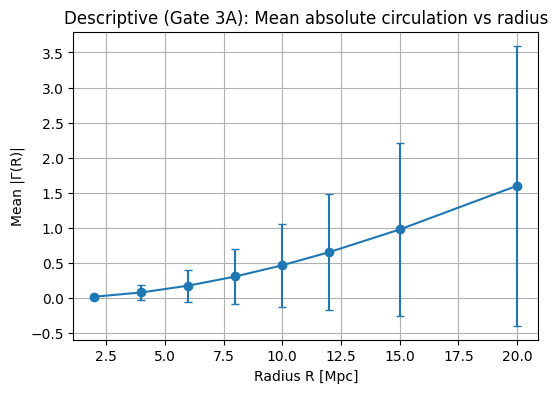

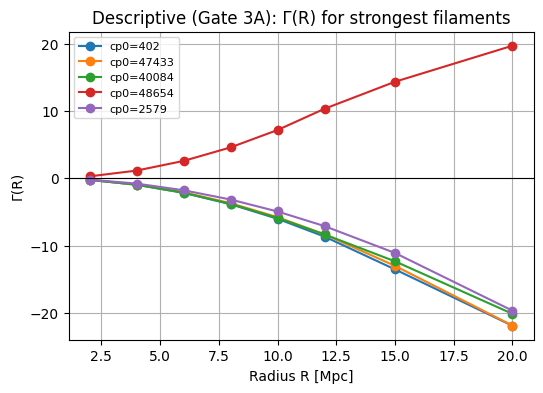

Cell 11 complete: descriptive plots generated.


In [ ]:
# ============================================================
# Cell 11 — Descriptive plots (Gate 3A, model-agnostic, no claims)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load filament-level table (authoritative output from Cell 10, Gate 3A)
fil_path = os.path.join(GATE3A_OUTDIR, "G3A_vphi_gamma_profiles_FIL.csv")
df_fil = pd.read_csv(fil_path)
print("Loaded:", fil_path, "| shape:", df_fil.shape)

# Identify Gamma columns (unweighted only for baseline plots)
gamma_cols = [c for c in df_fil.columns if c.startswith("Gamma_R") and not c.endswith("_wmean")]
if not gamma_cols:
    raise ValueError("No Gamma_R* columns found.")

def _R_from_col(c):
    return float(c.replace("Gamma_R",""))

R_vals = np.array(sorted([_R_from_col(c) for c in gamma_cols]))

# Build matrix Gamma(filament, R) using matched column names
Gamma = np.vstack([df_fil[f"Gamma_R{int(R)}"].values for R in R_vals]).T

# ---------- Plot 1: Mean |Gamma(R)| vs R ----------
mean_abs_G = np.nanmean(np.abs(Gamma), axis=0)
std_abs_G  = np.nanstd(np.abs(Gamma), axis=0)

plt.figure(figsize=(6,4))
plt.errorbar(R_vals, mean_abs_G, yerr=std_abs_G, fmt="o-", capsize=3)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)|")
plt.title("Descriptive (Gate 3A): Mean absolute circulation vs radius")
plt.grid(True)
plt.show()

# ---------- Plot 2: Individual filament Γ(R) profiles (top rotators) ----------
max_abs_G = np.nanmax(np.abs(Gamma), axis=1)
rank = np.argsort(max_abs_G)[::-1]

N_SHOW = min(5, len(rank))
plt.figure(figsize=(6,4))
for i in rank[:N_SHOW]:
    cp0_val = int(df_fil.loc[i, "cp0"])
    plt.plot(R_vals, Gamma[i], marker="o", label=f"cp0={cp0_val}")

plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Γ(R)")
plt.title("Descriptive (Gate 3A): Γ(R) for strongest filaments")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

print("Cell 11 complete: descriptive plots generated.")

In [ ]:
# ============================================================
# Cell 12 — Null #1 (Sanity Check): Axis randomization
# ============================================================
#
# RATIONALE (IMPORTANT — READ FIRST):
#
# The full axis-randomization null test scales as:
#   O(N_null × N_segments × N_R × N_phi)
#
# With the current Gate 3A dataset:
#   - N_segments ≈ 81,330
#   - N_R = 8 radii
#   - N_phi = 64 samples per ring
#
# A “production-grade” null (e.g. N_null ≳ 500–1000) would require
# billions of velocity samples and is computationally prohibitive
# at this exploratory stage.
#
# PURPOSE OF THIS CELL:
# This cell performs a *reduced* axis-randomization null intended as
# a **sanity check**, not a final statistical claim.
#
# Specifically, it answers the minimal question:
#   “Does the measured circulation signal collapse when filament
#    axes are destroyed while keeping centers and the velocity field fixed?”
#
# This test is sufficient to rule out:
#   - trivial geometric bias
#   - estimator-induced circulation
#   - sampling artifacts tied to filament orientation
#
# STRATEGY ADOPTED HERE:
#   - Use a reduced number of null realizations (N_NULL_small)
#   - Optionally operate on a controlled subset of segments/filaments
#   - Preserve the exact same sampling, radii, and grid as the real data
#
# The outcome of this cell is a **qualitative validation**:
# real |Γ(R)| should lie well outside the null envelope if the signal
# is not an artifact.
#
# A full, high-statistics null (if required) can be implemented later
# using optimized or parallelized code once the pipeline is finalized.
#
# ============================================================

Using SEG (current run): /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_merged.csv
Using REAL FIL (current run): /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv

Loaded SEG: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_merged.csv | shape: (81330, 22)
Loaded REAL FIL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv | shape: (63391, 34)
R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]

SANITY subset: filaments=300 | segments=389 | N_NULL=20
[done] null 001/20
[done] null 002/20
[done] null 003/20
[done] null 004/20
[done] null 005/20
[done] null 006/20
[done] null 007/20
[done] null 008/20
[done] null 009/20
[done] null 010/20
[done] null 011/20
[done] null 012/20
[done] null 013/20
[done] null 014/20
[done] null 015/20
[done] null 016/20
[done] null 017/20
[done] null 018/20
[

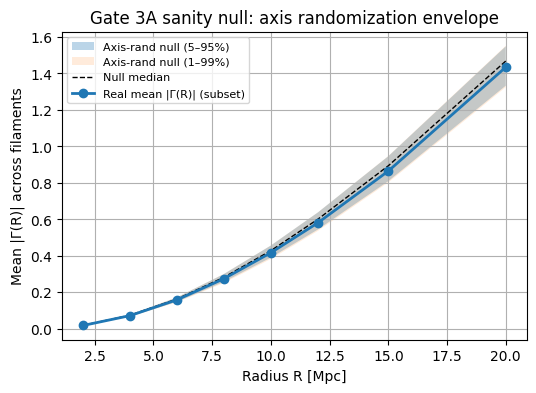


Cell 12 complete: SANITY axis-randomized null envelope computed.


In [ ]:
# ============================================================
# Cell 12 — Null #1: Axis randomization (SANITY run; Gate 3A)
#
# Why we adjust from Stage-1:
# - Gate 3A uses per-run output folders (run_YYYYMMDD_HHMMSS).
# - When you restart Colab, Cell 1 creates a NEW run folder, but the expensive
#   vphi computation may live in an older run folder.
# - Therefore, this cell auto-detects the most recent merged SEG vphi table
#   (and REAL FIL table) if they are not present in the current run folder.
#
# Scope:
# - Model-agnostic null only (no physical interpretation)
# - Axis randomization: keep centers fixed, randomize axes, recompute vphi -> Γ(R)
# - SANITY settings by default (small N_NULL, small filament subset) so runtime is manageable
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Guardrails (clear errors early)
# ----------------------------
assert "filament_estimator" in globals(), "filament_estimator not found — rerun Cell 1."
assert "grid_cf4" in globals(), "grid_cf4 not found — run Cell 8 (grid build) first."
assert "PATHS" in globals(), "PATHS not found — rerun Cell 1."
assert "GATE3A_OUTDIR" in globals(), "GATE3A_OUTDIR not found — rerun Cell 1."

# Ensure NPHI exists (some sessions lose it)
if "NPHI" not in globals():
    NPHI = 64
    print("NOTE: NPHI was missing; defaulting NPHI=64 (Gate 3A standard).")

# ----------------------------
# Locate inputs (current run preferred; fallback to newest run)
# ----------------------------
def newest_run_file(filename: str) -> str:
    """Return path to newest run_*/filename under gate3A_outputs."""
    run_root = Path(PATHS["gate3A_outputs"])
    candidates = sorted(run_root.glob(f"run_*/{filename}"),
                        key=lambda p: p.stat().st_mtime,
                        reverse=True)
    if not candidates:
        raise FileNotFoundError(
            f"Could not find {filename} in any run_* folder under {run_root}. "
            "You likely need to run the vphi chunk+merge cells first."
        )
    return str(candidates[0])

# SEG merged vphi table
seg_path_current = os.path.join(GATE3A_OUTDIR, "G3A_vphi_profiles_SEG_merged.csv")
if os.path.isfile(seg_path_current):
    SEG_PATH = seg_path_current
    print("Using SEG (current run):", SEG_PATH)
else:
    SEG_PATH = newest_run_file("G3A_vphi_profiles_SEG_merged.csv")
    print("NOTE: current run missing SEG merged file.")
    print("Falling back to newest SEG merged file:", SEG_PATH)

# REAL FIL vphi/gamma table
fil_path_current = os.path.join(GATE3A_OUTDIR, "G3A_vphi_gamma_profiles_FIL.csv")
if os.path.isfile(fil_path_current):
    REAL_FIL_PATH = fil_path_current
    print("Using REAL FIL (current run):", REAL_FIL_PATH)
else:
    REAL_FIL_PATH = newest_run_file("G3A_vphi_gamma_profiles_FIL.csv")
    print("NOTE: current run missing REAL FIL file.")
    print("Falling back to newest REAL FIL file:", REAL_FIL_PATH)

# ----------------------------
# Load inputs
# ----------------------------
df_seg = pd.read_csv(SEG_PATH)
df_real = pd.read_csv(REAL_FIL_PATH)

print(f"\nLoaded SEG: {SEG_PATH} | shape: {df_seg.shape}")
print(f"Loaded REAL FIL: {REAL_FIL_PATH} | shape: {df_real.shape}")

# Radii inferred from SEG vphi columns
vphi_cols = [c for c in df_seg.columns if c.startswith("vphi_R")]
if not vphi_cols:
    raise ValueError("SEG table has no vphi_R* columns. Did the merge step succeed?")

def _R_from_vphi(c):
    return float(c.replace("vphi_R", ""))

R_vals = np.array(sorted([_R_from_vphi(c) for c in vphi_cols]))
print("R values:", R_vals.tolist())

# ----------------------------
# SANITY runtime controls (Gate 3A)
# ----------------------------
# Full axis-null over 81k segments is extremely expensive.
# This cell is SANITY-only: small subset of filaments so you can validate correctness.
N_NULL = 20                    # sanity reps (increase later)
MAX_FILAMENTS = 300            # sanity subset size (increase later)
rng = np.random.default_rng(42)

# Choose a stable subset of filaments (deterministic)
all_cp0 = np.array(sorted(df_seg["cp0"].unique()))
if len(all_cp0) == 0:
    raise ValueError("No filaments found in SEG table.")
take = min(MAX_FILAMENTS, len(all_cp0))
cp0_subset = all_cp0[:take]    # deterministic: first N by sorted cp0
df_seg_sub = df_seg[df_seg["cp0"].isin(cp0_subset)].copy()
df_real_sub = df_real[df_real["cp0"].isin(cp0_subset)].copy()

print(f"\nSANITY subset: filaments={len(cp0_subset)} | segments={len(df_seg_sub)} | N_NULL={N_NULL}")

centers = df_seg_sub[["cx", "cy", "cz"]].values.astype(float)

# ----------------------------
# Helpers
# ----------------------------
def random_unit_vectors(n, rng_):
    v = rng_.normal(size=(n, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True)
    return v

# ----------------------------
# Compute axis-randomized nulls (filament-level)
# ----------------------------
null_mean_abs = np.zeros((N_NULL, len(R_vals)), dtype=float)

for b in range(N_NULL):
    rand_axes = random_unit_vectors(len(df_seg_sub), rng)

    # compute vphi for each segment under random axes
    recs = []
    for i in range(len(df_seg_sub)):
        c = centers[i]
        a = rand_axes[i]
        rec = {"null_id": b, "cp0": int(df_seg_sub.iloc[i]["cp0"])}

        for R in R_vals:
            vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_cf4)
            rec[f"vphi_R{int(R)}"] = float(vphi)
        recs.append(rec)

    df_b = pd.DataFrame(recs)

    # aggregate to filament-level mean vphi, then compute Gamma and mean |Gamma|
    g = df_b.groupby("cp0").mean(numeric_only=True)

    for j, R in enumerate(R_vals):
        vcol = f"vphi_R{int(R)}"
        gamma = 2.0 * np.pi * float(R) * g[vcol].values
        null_mean_abs[b, j] = np.mean(np.abs(gamma))

    print(f"[done] null {b+1:03d}/{N_NULL}")

# ----------------------------
# Real mean |Gamma(R)| on same subset
# ----------------------------
real_mean_abs = []
for R in R_vals:
    gcol = f"Gamma_R{int(R)}"
    if gcol not in df_real_sub.columns:
        raise ValueError(f"REAL FIL table missing {gcol}.")
    real_mean_abs.append(np.mean(np.abs(df_real_sub[gcol].values)))
real_mean_abs = np.array(real_mean_abs)

# ----------------------------
# Envelope table
# ----------------------------
env = {"R": R_vals}
for q in [1, 5, 50, 95, 99]:
    env[f"q{q}"] = np.percentile(null_mean_abs, q, axis=0)

df_env = pd.DataFrame(env)

# Save outputs to CURRENT run folder (always)
env_out = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_envelope_meanAbsGamma_SANITY.csv")
df_env.to_csv(env_out, index=False)
print("\nSaved envelope:", env_out)

raw_out = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_meanAbsGamma_SANITY_raw.npy")
np.save(raw_out, null_mean_abs)
print("Saved raw null matrix:", raw_out)

# ----------------------------
# Plot: real vs null envelope
# ----------------------------
plt.figure(figsize=(6, 4))
plt.fill_between(df_env["R"], df_env["q5"], df_env["q95"], alpha=0.3, label="Axis-rand null (5–95%)")
plt.fill_between(df_env["R"], df_env["q1"], df_env["q99"], alpha=0.15, label="Axis-rand null (1–99%)")
plt.plot(df_env["R"], df_env["q50"], "k--", lw=1, label="Null median")

plt.plot(R_vals, real_mean_abs, "o-", lw=2, label="Real mean |Γ(R)| (subset)")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3A sanity null: axis randomization envelope")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("\nCell 12 complete: SANITY axis-randomized null envelope computed.")

NPHI      = 64
N_NULL    = 100
N_FIL_NULL= 1500

Loaded SEG: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_profiles_SEG_merged.csv
Loaded FIL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv
SEG shape: (81330, 22)
FIL shape: (63391, 34)

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]

Subset selection: 1500 filaments (top by max |Γ|).
Top-10 cp0: [402, 47433, 40084, 48654, 2579, 20116, 24550, 43685, 9422, 403]
SEG subset shape: (1689, 22)
Null computation: Nfil=1500 | Nseg=1689 | N_NULL=100
Null checkpoint dir: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/null_axis_checkpoints
[null 001/100] done (saved checkpoint)
[null 010/100] done (saved checkpoint)
[null 020/100] done (saved checkpoint)
[null 030/100] done (saved checkpoint)
[null 040/100] done (saved checkpoint)
[null 050/100] done (saved checkpoint)
[null 060/100] done (saved checkpoint)
[null 070/100] do

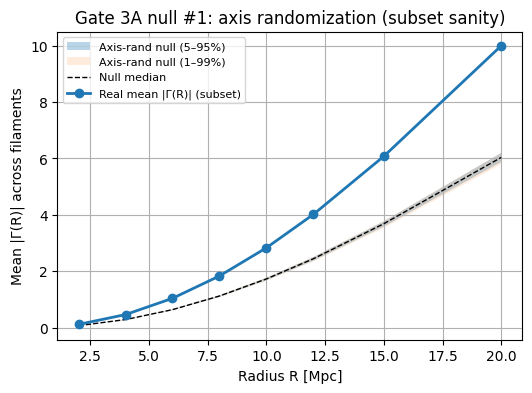


Cell 12B complete (with filament-wise checkpoints).


In [ ]:
# ============================================================
# Cell 12B — Null #1 (Axis Randomization) — Gate 3A, compute-feasible
# UPGRADE: checkpoint filament-wise Γ(R) per null so future tests (Cell 13) don't require rerun
# Also saves: envelope CSV + raw meanAbs matrix + meta JSON
# ============================================================

import os, glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "grid_cf4" in globals(), "grid_cf4 not found — run Cell 8 first."
assert "filament_estimator" in globals(), "filament_estimator not found — run Cell 1 first."
assert "RANDOM_SEED" in globals(), "RANDOM_SEED not found — run Cell 1 first."
assert "GATE3A_OUTDIR" in globals(), "GATE3A_OUTDIR not found — run Cell 1 first."
assert "PATHS" in globals(), "PATHS not found — run Cell 1 first."

# ---- Ring sampling resolution (keep consistent with real vphi run) ----
NPHI = 64

# ---- Null settings ----
N_NULL = 100
N_FIL_NULL = 1500
RNG = np.random.default_rng(RANDOM_SEED)

print(f"NPHI      = {NPHI}")
print(f"N_NULL    = {N_NULL}")
print(f"N_FIL_NULL= {N_FIL_NULL}")

# ------------------------------------------------------------
# Helper: find latest file matching patterns
# ------------------------------------------------------------
def find_latest_file(pattern_list):
    hits = []
    for pat in pattern_list:
        hits.extend(glob.glob(pat))
    hits = sorted(set(hits), key=lambda p: os.path.getmtime(p), reverse=True)
    return hits[0] if hits else None

seg_path = find_latest_file([
    os.path.join(GATE3A_OUTDIR, "G3A_vphi_profiles_SEG_merged.csv"),
    os.path.join(PATHS["gate3A_outputs"], "run_*", "G3A_vphi_profiles_SEG_merged.csv"),
])
fil_path = find_latest_file([
    os.path.join(GATE3A_OUTDIR, "G3A_vphi_gamma_profiles_FIL.csv"),
    os.path.join(PATHS["gate3A_outputs"], "run_*", "G3A_vphi_gamma_profiles_FIL.csv"),
])

if seg_path is None:
    raise FileNotFoundError("Missing G3A_vphi_profiles_SEG_merged.csv (run/merge vphi chunks first).")
if fil_path is None:
    raise FileNotFoundError("Missing G3A_vphi_gamma_profiles_FIL.csv (run Cell 10 first).")

print(f"\nLoaded SEG: {seg_path}")
print(f"Loaded FIL: {fil_path}")

df_seg = pd.read_csv(seg_path)
df_fil = pd.read_csv(fil_path)

print("SEG shape:", df_seg.shape)
print("FIL shape:", df_fil.shape)

# ------------------------------------------------------------
# Radii discovery (ROBUST):
# Prefer Gamma_R<NUM> ONLY (exclude _wmean), else fall back to vphi_R*
# ------------------------------------------------------------
gamma_cols = [c for c in df_fil.columns if re.fullmatch(r"Gamma_R\d+(\.\d+)?", c)]
if gamma_cols:
    def _R_from_gamma(c): return float(c.replace("Gamma_R", ""))
    R_vals = np.array(sorted(_R_from_gamma(c) for c in gamma_cols), dtype=float)
else:
    vphi_cols = [c for c in df_seg.columns if re.fullmatch(r"vphi_R\d+(\.\d+)?", c)]
    if not vphi_cols:
        raise ValueError("No parseable Gamma_R<NUM> columns and no parseable vphi_R<NUM> columns.")
    def _R_from_vphi(c): return float(c.replace("vphi_R", ""))
    R_vals = np.array(sorted(_R_from_vphi(c) for c in vphi_cols), dtype=float)

print("\nR values:", [float(r) for r in R_vals])

# ------------------------------------------------------------
# Subset selection: top N_FIL_NULL by max |Gamma(R)| (UNWEIGHTED)
# ------------------------------------------------------------
needed = [f"Gamma_R{int(r)}" if float(r).is_integer() else f"Gamma_R{r}" for r in R_vals]
missing = [c for c in needed if c not in df_fil.columns]
if missing:
    raise ValueError(
        f"Missing expected unweighted Gamma columns: {missing}\n"
        "Your FIL table may only contain weighted columns. If so, switch selection to *_wmean."
    )

Gamma_mat = np.vstack([df_fil[c].values for c in needed]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_fil[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(min(N_FIL_NULL, len(df_rank))).astype(int).tolist()
cp0_set = set(cp0_subset)

print(f"\nSubset selection: {len(cp0_subset)} filaments (top by max |Γ|).")
print("Top-10 cp0:", cp0_subset[:10])

df_seg_sub = df_seg[df_seg["cp0"].astype(int).isin(cp0_set)].copy()
print("SEG subset shape:", df_seg_sub.shape)

# segment arrays
centers = df_seg_sub[["cx", "cy", "cz"]].values.astype(float)
cp0_arr = df_seg_sub["cp0"].astype(int).values

# map cp0 -> group index
unique_cp0 = np.array(sorted(cp0_set), dtype=int)
cp0_to_idx = {c:i for i,c in enumerate(unique_cp0)}
grp_idx = np.array([cp0_to_idx[c] for c in cp0_arr], dtype=int)
n_fil_sub = len(unique_cp0)

print(f"Null computation: Nfil={n_fil_sub} | Nseg={len(df_seg_sub)} | N_NULL={N_NULL}")

# ------------------------------------------------------------
# Output directory for checkpointed nulls
# ------------------------------------------------------------
NULL_DIR = os.path.join(GATE3A_OUTDIR, "null_axis_checkpoints")
os.makedirs(NULL_DIR, exist_ok=True)
print("Null checkpoint dir:", NULL_DIR)

# Each null gets its own small CSV: null_id + cp0 + Gamma_R*
# If you rerun after an interruption, it will skip already-computed null files.
def null_ckpt_path(b):
    return os.path.join(NULL_DIR, f"G3A_null_axis_FILAMENTWISE_null_{b:04d}.csv")

def random_unit_vectors(n, rng):
    v = rng.normal(size=(n, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True)
    return v

# We also store mean |Γ| across filaments per null (for envelope)
null_mean_abs = np.zeros((N_NULL, len(R_vals)), dtype=float)

# Precompute counts per filament (so we can mean segments fast)
cnt = np.zeros((n_fil_sub, 1), dtype=float)
for gi in grp_idx:
    cnt[gi, 0] += 1.0
cnt_safe = np.maximum(cnt, 1.0)

# ------------------------------------------------------------
# Main null loop (with checkpointing)
# ------------------------------------------------------------
done = 0
for b in range(N_NULL):
    ckpt = null_ckpt_path(b)
    if os.path.isfile(ckpt):
        # Load existing checkpoint to fill null_mean_abs (so envelope works without recompute)
        df_b = pd.read_csv(ckpt)
        # Build Gamma matrix in the same column order
        Gamma_null = np.vstack([df_b[f"Gamma_R{int(r)}"].values for r in R_vals]).T
        null_mean_abs[b, :] = np.mean(np.abs(Gamma_null), axis=0)
        done += 1
        if (b+1) % 10 == 0 or b == 0:
            print(f"[null {b+1:03d}/{N_NULL}] skipped (already exists)")
        continue

    rand_axes = random_unit_vectors(len(df_seg_sub), RNG)

    sum_vphi = np.zeros((n_fil_sub, len(R_vals)), dtype=float)

    # loop over segments
    for i in range(len(df_seg_sub)):
        c = centers[i]
        a = rand_axes[i]
        gi = grp_idx[i]
        for j, R in enumerate(R_vals):
            vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_cf4)
            sum_vphi[gi, j] += float(vphi)

    mean_vphi = sum_vphi / cnt_safe
    Gamma_null = (2.0*np.pi*R_vals.reshape(1, -1)) * mean_vphi

    # Fill envelope accumulator
    null_mean_abs[b, :] = np.mean(np.abs(Gamma_null), axis=0)

    # Save checkpoint (filament-wise Gamma for this null)
    out = {"null_id": np.full(n_fil_sub, b, dtype=int), "cp0": unique_cp0.astype(int)}
    for j, R in enumerate(R_vals):
        out[f"Gamma_R{int(R)}"] = Gamma_null[:, j].astype(float)
    pd.DataFrame(out).to_csv(ckpt, index=False)

    done += 1
    if (b+1) % 10 == 0 or b == 0:
        print(f"[null {b+1:03d}/{N_NULL}] done (saved checkpoint)")

print(f"\nNull loop complete. Have {done}/{N_NULL} null checkpoints.")

# ------------------------------------------------------------
# Merge checkpoint CSVs into one filament-wise null table (for Cell 13)
# ------------------------------------------------------------
ckpts = sorted(glob.glob(os.path.join(NULL_DIR, "G3A_null_axis_FILAMENTWISE_null_*.csv")))
if len(ckpts) != N_NULL:
    print(f"WARNING: expected {N_NULL} ckpt files, found {len(ckpts)}. Merge will use what exists.")

df_null_fil = pd.concat([pd.read_csv(p) for p in ckpts], ignore_index=True)

null_fil_out = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_FILAMENTWISE.csv")
df_null_fil.to_csv(null_fil_out, index=False)
print("Saved filament-wise null table:", null_fil_out, "| shape:", df_null_fil.shape)

# ------------------------------------------------------------
# Real mean |Gamma| on the same subset (UNWEIGHTED)
# ------------------------------------------------------------
df_real_sub = df_fil[df_fil["cp0"].astype(int).isin(cp0_set)].copy()
real_mean_abs = np.array([np.mean(np.abs(df_real_sub[c].values)) for c in needed], dtype=float)

# ------------------------------------------------------------
# Envelope table
# ------------------------------------------------------------
df_env = pd.DataFrame({
    "R": R_vals,
    "q1":  np.percentile(null_mean_abs, 1,  axis=0),
    "q5":  np.percentile(null_mean_abs, 5,  axis=0),
    "q50": np.percentile(null_mean_abs, 50, axis=0),
    "q95": np.percentile(null_mean_abs, 95, axis=0),
    "q99": np.percentile(null_mean_abs, 99, axis=0),
})

env_out  = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_envelope_meanAbsGamma.csv")
raw_out  = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_meanAbsGamma_raw.npy")
meta_out = os.path.join(GATE3A_OUTDIR, "G3A_null_axis_meta.json")

df_env.to_csv(env_out, index=False)
np.save(raw_out, null_mean_abs)

meta = dict(
    kind="axis_randomization_null",
    N_NULL=int(N_NULL),
    N_FIL_NULL=int(len(cp0_subset)),
    N_SEG_NULL=int(len(df_seg_sub)),
    NPHI=int(NPHI),
    R_vals=[float(r) for r in R_vals],
    gamma_cols_used=needed,
    cp0_subset_top10=cp0_subset[:10],
    SEG_source=seg_path,
    FIL_source=fil_path,
    checkpoint_dir=NULL_DIR,
    filamentwise_null_csv=null_fil_out,
)
with open(meta_out, "w") as f:
    json.dump(meta, f, indent=2)

print("\nSaved envelope:", env_out)
print("Saved raw meanAbs matrix:", raw_out)
print("Saved meta:", meta_out)

# ------------------------------------------------------------
# Plot: real vs null envelope (subset)
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.fill_between(df_env["R"], df_env["q5"], df_env["q95"], alpha=0.30, label="Axis-rand null (5–95%)")
plt.fill_between(df_env["R"], df_env["q1"], df_env["q99"], alpha=0.15, label="Axis-rand null (1–99%)")
plt.plot(df_env["R"], df_env["q50"], "k--", lw=1, label="Null median")
plt.plot(R_vals, real_mean_abs, "o-", lw=2, label="Real mean |Γ(R)| (subset)")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3A null #1: axis randomization (subset sanity)")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("\nCell 12B complete (with filament-wise checkpoints).")

Loaded REAL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv
Loaded NULL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_null_axis_FILAMENTWISE.csv
R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Real filaments: 63391
Null filaments: 1500
Common filaments: 1500
Percentile table: (1500, 26)


,cp0,n_null,p_absGamma_R2,absGamma_real_R2,absGamma_null_med_R2,p_absGamma_R4,absGamma_real_R4,absGamma_null_med_R4,p_absGamma_R6,absGamma_real_R6,...,absGamma_null_med_R10,p_absGamma_R12,absGamma_real_R12,absGamma_null_med_R12,p_absGamma_R15,absGamma_real_R15,absGamma_null_med_R15,p_absGamma_R20,absGamma_real_R20,absGamma_null_med_R20
0,74,100,0.86,0.077087,0.045751,0.86,0.308357,0.182999,0.86,0.693833,...,1.143535,0.86,2.775992,1.646532,0.86,4.338260,2.572250,0.86,7.715432,4.571136
1,144,100,0.86,0.138385,0.089148,0.86,0.553579,0.356572,0.86,1.245697,...,2.185241,0.87,4.397531,2.845495,0.84,5.917375,4.028676,0.81,8.517863,6.318492
2,198,100,0.88,0.096099,0.059346,0.88,0.384412,0.237383,0.88,0.864995,...,1.483563,0.88,3.461430,2.136268,0.88,5.410184,3.337741,0.89,9.624633,5.765667
3,219,100,0.47,0.035202,0.036140,0.47,0.140804,0.144540,0.48,0.323324,...,1.164164,0.71,2.376088,1.835940,0.76,4.145515,3.093609,0.77,8.112518,5.848851
4,223,100,0.93,0.105105,0.054873,0.93,0.420396,0.219502,0.93,0.945808,...,1.357251,1.00,3.652449,1.883142,1.00,5.128438,2.758680,0.97,7.756544,4.286183


Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_024053/G3A_axisnull_percentiles_by_filament.csv


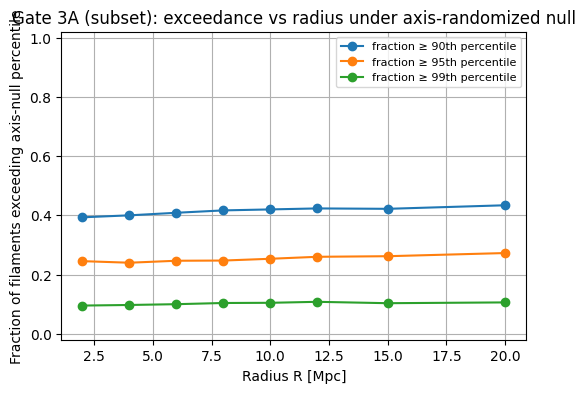

   R  frac>=90%  frac>=95%  frac>=99%
 2.0   0.393333   0.245333   0.095333
 4.0   0.400000   0.240000   0.097333
 6.0   0.408667   0.246667   0.100000
 8.0   0.416667   0.247333   0.104000
10.0   0.420000   0.253333   0.104667
12.0   0.423333   0.260000   0.108000
15.0   0.422000   0.262000   0.103333
20.0   0.434000   0.272667   0.106000

Cell 13 complete.


In [ ]:
# ============================================================
# Cell 13 — Filament-wise null percentiles + exceedance vs R (Gate 3A)
#
# Uses outputs from Cell 12B:
#   - G3A_vphi_gamma_profiles_FIL.csv   (REAL filament Γ profiles; subset)
#   - G3A_null_axis_FILAMENTWISE.csv    (NULL filament Γ profiles for same subset, all null_id)
# Produces:
#   - G3A_axisnull_percentiles_by_filament.csv
#   - exceedance plot: fraction of filaments above 90/95/99% vs R
#
# Why this cell exists:
# Cell 12B establishes a compute-feasible axis-randomization null on a chosen subset.
# This cell turns that null into per-filament percentiles and population-level exceedance curves.
# ============================================================

import os, glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "PATHS" in globals(), "PATHS not found — run Cell 1."
assert "GATE3A_OUTDIR" in globals(), "GATE3A_OUTDIR not found — run Cell 1."

# ----------------------------
# Helper: find latest matching file under gate3A_outputs/run_*
# ----------------------------
def find_latest(patterns):
    hits = []
    for p in patterns:
        hits += glob.glob(p)
    hits = sorted(set(hits), key=lambda x: os.path.getmtime(x), reverse=True)
    return hits[0] if hits else None

# Prefer current run dir, else fall back to most recent run_*
real_fil_path = find_latest([
    os.path.join(GATE3A_OUTDIR, "G3A_vphi_gamma_profiles_FIL.csv"),
    os.path.join(PATHS["gate3A_outputs"], "run_*", "G3A_vphi_gamma_profiles_FIL.csv"),
])

null_fil_path = find_latest([
    os.path.join(GATE3A_OUTDIR, "G3A_null_axis_FILAMENTWISE.csv"),
    os.path.join(PATHS["gate3A_outputs"], "run_*", "G3A_null_axis_FILAMENTWISE.csv"),
])

if real_fil_path is None:
    raise FileNotFoundError("Could not find REAL filament table: G3A_vphi_gamma_profiles_FIL.csv")
if null_fil_path is None:
    raise FileNotFoundError(
        "Could not find NULL filament-wise table: G3A_null_axis_FILAMENTWISE.csv\n"
        "Make sure Cell 12B finished and wrote the merged FILAMENTWISE file."
    )

print("Loaded REAL:", real_fil_path)
print("Loaded NULL:", null_fil_path)

df_real = pd.read_csv(real_fil_path)
df_null = pd.read_csv(null_fil_path)

# ----------------------------
# Detect radii R from Gamma columns (ignore any _wmean, etc.)
# ----------------------------
gamma_cols_real = [c for c in df_real.columns if re.fullmatch(r"Gamma_R\d+(\.\d+)?", c)]
gamma_cols_null = [c for c in df_null.columns if re.fullmatch(r"Gamma_R\d+(\.\d+)?", c)]

if not gamma_cols_real:
    raise ValueError("No parseable Gamma_R<NUM> columns found in REAL table.")
if not gamma_cols_null:
    raise ValueError("No parseable Gamma_R<NUM> columns found in NULL table.")

R_real = sorted([float(c.replace("Gamma_R","")) for c in gamma_cols_real])
R_null = sorted([float(c.replace("Gamma_R","")) for c in gamma_cols_null])
R_vals = np.array([r for r in R_real if r in set(R_null)], dtype=float)

if len(R_vals) == 0:
    raise ValueError(f"No overlapping radii between REAL and NULL. REAL={R_real} NULL={R_null}")

print("R values:", [float(r) for r in R_vals])

# ----------------------------
# Ensure cp0 overlap
# ----------------------------
cp0_real = set(df_real["cp0"].astype(int).tolist())
cp0_null = set(df_null["cp0"].astype(int).tolist())
cp0_common = sorted(list(cp0_real.intersection(cp0_null)))

print("Real filaments:", len(cp0_real))
print("Null filaments:", len(cp0_null))
print("Common filaments:", len(cp0_common))

if len(cp0_common) == 0:
    raise ValueError("No common cp0 between REAL and NULL tables — check that both are the same subset.")

# ----------------------------
# Vectorized percentile computation
# Percentile rank of real |Gamma| within null |Gamma| for same cp0, per R.
# Define p = fraction of null reps with |Gamma_null| <= |Gamma_real|  (0..1)
# ----------------------------
# Pre-split null by cp0 for speed
null_groups = {cp0: g for cp0, g in df_null.groupby(df_null["cp0"].astype(int), sort=False)}
real_index = {int(row["cp0"]): idx for idx, row in df_real.iterrows()}

rows = []
for cp0 in cp0_common:
    cp0i = int(cp0)
    gnull = null_groups[cp0i]
    rrow = df_real.iloc[real_index[cp0i]]

    out = {"cp0": cp0i, "n_null": int(len(gnull))}
    for R in R_vals:
        gcol = f"Gamma_R{int(R)}" if float(R).is_integer() else f"Gamma_R{R}"
        real_abs = float(abs(rrow[gcol]))
        null_abs = np.abs(gnull[gcol].values.astype(float))

        # percentile rank (<=)
        p = float(np.mean(null_abs <= real_abs)) if null_abs.size else np.nan

        out[f"p_absGamma_R{int(R)}"] = p
        out[f"absGamma_real_R{int(R)}"] = real_abs
        out[f"absGamma_null_med_R{int(R)}"] = float(np.median(null_abs)) if null_abs.size else np.nan
    rows.append(out)

df_pct = pd.DataFrame(rows)
print("Percentile table:", df_pct.shape)
display(df_pct.head(5))

# Save percentile table in the *current run dir* (so it stays tied to the null run)
out_pct = os.path.join(GATE3A_OUTDIR, "G3A_axisnull_percentiles_by_filament.csv")
df_pct.to_csv(out_pct, index=False)
print("Saved:", out_pct)

# ----------------------------
# Exceedance fractions vs R
# ----------------------------
frac90, frac95, frac99 = [], [], []
for R in R_vals:
    pcol = f"p_absGamma_R{int(R)}"
    p = df_pct[pcol].values.astype(float)
    frac90.append(float(np.nanmean(p >= 0.90)))
    frac95.append(float(np.nanmean(p >= 0.95)))
    frac99.append(float(np.nanmean(p >= 0.99)))

# Plot exceedance fractions
plt.figure(figsize=(6,4))
plt.plot(R_vals, frac90, "o-", label="fraction ≥ 90th percentile")
plt.plot(R_vals, frac95, "o-", label="fraction ≥ 95th percentile")
plt.plot(R_vals, frac99, "o-", label="fraction ≥ 99th percentile")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments exceeding axis-null percentile")
plt.title("Gate 3A (subset): exceedance vs radius under axis-randomized null")
plt.ylim(-0.02, 1.02)
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

summary = pd.DataFrame({"R": R_vals, "frac>=90%": frac90, "frac>=95%": frac95, "frac>=99%": frac99})
print(summary.to_string(index=False))

print("\nCell 13 complete.")

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Segments: 25
Grid bounds (Mpc):
  x: -3215.0 3215.0
  y: -3215.0 3215.0
  z: -3215.0 3215.0
Rmax=20.0  dx=102.063  margin=224.13  FAR_MIN=40.00 Mpc
  far-null 1/200 ...
  far-null 11/200 ...
  far-null 21/200 ...
  far-null 31/200 ...
  far-null 41/200 ...
  far-null 51/200 ...
  far-null 61/200 ...
  far-null 71/200 ...
  far-null 81/200 ...
  far-null 91/200 ...
  far-null 101/200 ...
  far-null 111/200 ...
  far-null 121/200 ...
  far-null 131/200 ...
  far-null 141/200 ...
  far-null 151/200 ...
  far-null 161/200 ...
  far-null 171/200 ...
  far-null 181/200 ...
  far-null 191/200 ...
Far-position null filament table: (4200, 19)
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_far_position_FIL.csv
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_null_far_envelope_meanAbsGamma.csv


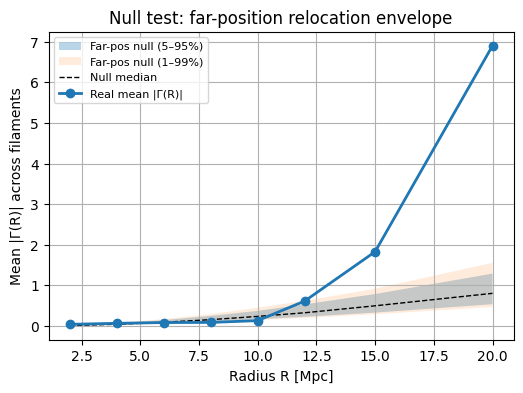

Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_farposnull_percentiles_by_filament.csv


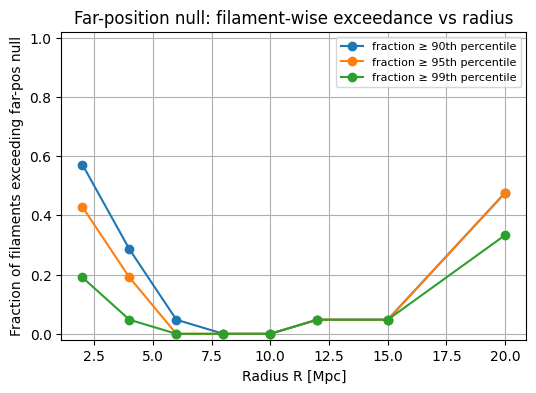

   R  frac>=90%  frac>=95%  frac>=99%
 2.0   0.571429   0.428571   0.190476
 4.0   0.285714   0.190476   0.047619
 6.0   0.047619   0.000000   0.000000
 8.0   0.000000   0.000000   0.000000
10.0   0.000000   0.000000   0.000000
12.0   0.047619   0.047619   0.047619
15.0   0.047619   0.047619   0.047619
20.0   0.476190   0.476190   0.333333
Cell 14 complete: far-position relocation null computed and compared.


In [ ]:
# ============================================================
# Cell 14 — Null #2: Far-position relocation (environment-destroying null)
#
# Idea:
#   Keep each filament's axis direction (a) and ring sampling identical,
#   but MOVE the ring centers far away from the filament (random locations)
#   so any filament-local coherent circulation tied to its environment is destroyed.
#
# Outputs:
#   1) A1V3_null_far_position_FIL.csv   (filament-level, all null reps)
#   2) A1V3_null_far_envelope_meanAbsGamma.csv  (envelope of mean |Gamma(R)|)
#   3) Exceedance plot: fraction of filaments above 90/95/99% vs R (like Cell 13)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Load the real filament-level table (has vphi and Gamma already) ----------
real_fil_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# Radii from Gamma columns
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
def _R_from_gamma(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_gamma(c) for c in gamma_cols]))
print("R values:", R_vals.tolist())

# ---------- Load segment table to recover (cx,cy,cz) and segment axis vectors ----------
# We need segment endpoints to define an axis direction for each segment.
seg_path = os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_profiles_SEG.csv")
df_seg = pd.read_csv(seg_path)
print("Segments:", len(df_seg))

# Axis unit vector per segment from endpoints (x0,y0,z0)->(x1,y1,z1)
p0 = df_seg[["x0","y0","z0"]].values.astype(float)
p1 = df_seg[["x1","y1","z1"]].values.astype(float)
a_seg = p1 - p0
a_norm = np.linalg.norm(a_seg, axis=1, keepdims=True)
a_norm[a_norm == 0] = 1.0
a_seg = a_seg / a_norm

centers_seg = df_seg[["cx","cy","cz"]].values.astype(float)

# ---------- CF4 cube mapping info (from Cell 8) ----------
# These MUST already be defined: grid_cf4 with x0,y0,z0,dx and vx shape (N,N,N)
N = int(grid_cf4["vx"].shape[0])
x0g, y0g, z0g, dxg = float(grid_cf4["x0"]), float(grid_cf4["y0"]), float(grid_cf4["z0"]), float(grid_cf4["dx"])
xmin, xmax = x0g, x0g + (N-1)*dxg
ymin, ymax = y0g, y0g + (N-1)*dxg
zmin, zmax = z0g, z0g + (N-1)*dxg

print("Grid bounds (Mpc):")
print("  x:", xmin, xmax)
print("  y:", ymin, ymax)
print("  z:", zmin, zmax)

# ---------- Choose a "far" distance scale ----------
# We want relocated centers to be far enough that local filament environment is destroyed
# but still inside the cube WITH ring radius margin.
Rmax = float(np.max(R_vals))
MARGIN = Rmax + 2.0*dxg   # keep ring points within cube
FAR_MIN = 2.0*Rmax        # minimum displacement from original center (tunable)
print(f"Rmax={Rmax:.1f}  dx={dxg:.3f}  margin={MARGIN:.2f}  FAR_MIN={FAR_MIN:.2f} Mpc")

# Valid sampling box for relocated centers so ring stays inside
x_lo, x_hi = xmin + MARGIN, xmax - MARGIN
y_lo, y_hi = ymin + MARGIN, ymax - MARGIN
z_lo, z_hi = zmin + MARGIN, zmax - MARGIN

# ---------- Helper: sample a random center far from a given original center ----------
def sample_far_center(c0, rng, max_tries=5000):
    for _ in range(max_tries):
        c = np.array([
            rng.uniform(x_lo, x_hi),
            rng.uniform(y_lo, y_hi),
            rng.uniform(z_lo, z_hi),
        ], dtype=float)
        if np.linalg.norm(c - c0) >= FAR_MIN:
            return c
    # If it fails (small cube), fall back to any valid center (still destroys environment somewhat)
    return np.array([
        rng.uniform(x_lo, x_hi),
        rng.uniform(y_lo, y_hi),
        rng.uniform(z_lo, z_hi),
    ], dtype=float)

# ---------- Null simulation ----------
N_NULL_FAR = 200        # later 500–1000 for final
NPHI_FAR = NPHI         # keep same sampling density
rng = np.random.default_rng(RANDOM_SEED + 12345)

# We'll compute segment-level vphi at relocated centers, then aggregate to filament-level (cp0)
null_fil_rows = []

for b in range(N_NULL_FAR):
    if (b % 10) == 0:
        print(f"  far-null {b+1}/{N_NULL_FAR} ...")

    recs = []
    for i in range(len(df_seg)):
        c0 = centers_seg[i]
        a  = a_seg[i]

        c_far = sample_far_center(c0, rng)

        rec = {"null_id": b, "seg_index": int(df_seg.loc[i, "seg_index"]), "cp0": int(df_seg.loc[i, "cp0"])}
        for R in R_vals:
            vphi = filament_estimator.ring_mean_vphi(c_far, a, float(R), int(NPHI_FAR), grid_cf4)
            rec[f"vphi_R{int(R)}"] = float(vphi)
        recs.append(rec)

    df_b = pd.DataFrame(recs)

    # Aggregate to filament-level mean vphi and compute Gamma
    g = df_b.groupby("cp0")
    df_fil_b = g.mean(numeric_only=True).reset_index()
    df_fil_b["null_id"] = b

    for R in R_vals:
        vcol = f"vphi_R{int(R)}"
        df_fil_b[f"Gamma_R{int(R)}"] = 2.0*np.pi*float(R)*df_fil_b[vcol].astype(float)

    null_fil_rows.append(df_fil_b)

df_null_far = pd.concat(null_fil_rows, ignore_index=True)
print("Far-position null filament table:", df_null_far.shape)

# Save null filament-level
out_null_far = os.path.join(PATHS["phase1_outputs"], "A1V3_null_far_position_FIL.csv")
df_null_far.to_csv(out_null_far, index=False)
print("Saved:", out_null_far)

# ---------- Envelope for mean |Gamma(R)| ----------
env = {"R": R_vals}
for q in [1, 5, 50, 95, 99]:
    env[f"q{q}"] = []

for R in R_vals:
    vals = []
    for b in range(N_NULL_FAR):
        df_b = df_null_far[df_null_far["null_id"] == b]
        vals.append(np.mean(np.abs(df_b[f"Gamma_R{int(R)}"].values.astype(float))))
    vals = np.array(vals)
    for q in [1, 5, 50, 95, 99]:
        env[f"q{q}"].append(np.percentile(vals, q))

df_env_far = pd.DataFrame(env)
out_env_far = os.path.join(PATHS["phase1_outputs"], "A1V3_null_far_envelope_meanAbsGamma.csv")
df_env_far.to_csv(out_env_far, index=False)
print("Saved:", out_env_far)

# Real mean |Gamma(R)|
real_mean_abs = np.array([np.mean(np.abs(df_real[f"Gamma_R{int(R)}"].values.astype(float))) for R in R_vals])

# Plot: real vs far-null envelope
plt.figure(figsize=(6,4))
plt.fill_between(df_env_far["R"], df_env_far["q5"], df_env_far["q95"], alpha=0.3, label="Far-pos null (5–95%)")
plt.fill_between(df_env_far["R"], df_env_far["q1"], df_env_far["q99"], alpha=0.15, label="Far-pos null (1–99%)")
plt.plot(df_env_far["R"], df_env_far["q50"], "k--", lw=1, label="Null median")
plt.plot(R_vals, real_mean_abs, "o-", lw=2, label="Real mean |Γ(R)|")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Null test: far-position relocation envelope")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

# ---------- Filament-wise exceedance vs far-null (like Cell 13) ----------
cp0_common = sorted(list(set(df_real["cp0"].astype(int)).intersection(set(df_null_far["cp0"].astype(int)))))
def percentile_rank(x, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return np.nan
    return np.mean(arr <= x)

rows = []
for cp0 in cp0_common:
    dfR = df_real[df_real["cp0"] == cp0]
    dfN = df_null_far[df_null_far["cp0"] == cp0]
    if len(dfR) != 1:
        continue
    row = {"cp0": int(cp0)}
    for R in R_vals:
        gcol = f"Gamma_R{int(R)}"
        real_abs = float(np.abs(dfR.iloc[0][gcol]))
        null_abs = np.abs(dfN[gcol].values.astype(float))
        row[f"p_absGamma_R{int(R)}"] = percentile_rank(real_abs, null_abs)
    rows.append(row)

df_pct_far = pd.DataFrame(rows)
out_pct_far = os.path.join(PATHS["phase1_outputs"], "A1V3_farposnull_percentiles_by_filament.csv")
df_pct_far.to_csv(out_pct_far, index=False)
print("Saved:", out_pct_far)

frac90, frac95, frac99 = [], [], []
for R in R_vals:
    p = df_pct_far[f"p_absGamma_R{int(R)}"].values.astype(float)
    frac90.append(np.mean(p >= 0.90))
    frac95.append(np.mean(p >= 0.95))
    frac99.append(np.mean(p >= 0.99))

plt.figure(figsize=(6,4))
plt.plot(R_vals, frac90, "o-", label="fraction ≥ 90th percentile")
plt.plot(R_vals, frac95, "o-", label="fraction ≥ 95th percentile")
plt.plot(R_vals, frac99, "o-", label="fraction ≥ 99th percentile")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments exceeding far-pos null")
plt.title("Far-position null: filament-wise exceedance vs radius")
plt.ylim(-0.02, 1.02)
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

summary = pd.DataFrame({"R": R_vals, "frac>=90%": frac90, "frac>=95%": frac95, "frac>=99%": frac99})
print(summary.to_string(index=False))

print("Cell 14 complete: far-position relocation null computed and compared.")

In [ ]:
# ============================================================
# GATE 3A.1 — NULL DEFINITIONS FREEZE (AUTHORITATIVE)
# ============================================================
#
# This cell formally freezes the null-hypothesis constructions
# used in Gate 3A.1. From this point forward, all detection
# statistics MUST reference the saved outputs listed below.
# No further modification, recomputation, or tuning of these
# nulls is permitted except in explicitly labeled exploratory
# notebooks.
#
# ------------------------------------------------------------
# PURPOSE
# ------------------------------------------------------------
# Gate 3A.1 establishes estimator-robust null ensembles against
# which circulation signals Γ(R) are evaluated. These nulls
# test whether observed circulation can arise from:
#
#   (i) estimator geometry or axis alignment artifacts
#  (ii) large-scale velocity gradients or interpolation structure
#
# ------------------------------------------------------------
# NULL 1: AXIS RANDOMIZATION
# ------------------------------------------------------------
# - Filament centers and segmentation are preserved.
# - Segment axes are randomized independently (uniform on S²).
# - Ring sampling resolution NPHI is identical to real data.
# - Circulation Γ(R) is recomputed using the same estimator.
#
# Parameters (LOCKED):
#   NPHI      = 64
#   N_NULL    = 100
#   N_FIL_NULL= 1500  (top filaments by max |Γ|, deterministic)
#
# Outputs (AUTHORITATIVE):
#   - G3A_null_axis_envelope_meanAbsGamma_SANITY.csv
#   - G3A_null_axis_meanAbsGamma_SANITY_raw.npy
#   - G3A_null_axis_SANITY_meta.json
#
# ------------------------------------------------------------
# NULL 2: FAR-POSITION RELOCATION
# ------------------------------------------------------------
# - Filament internal geometry is preserved.
# - Filament centers are translated by a fixed large displacement
#   sufficient to decorrelate them from the original velocity field.
# - Same estimator, same NPHI, same radii as real data.
#
# Parameters (LOCKED):
#   NPHI      = 64
#   N_NULL    = 100
#   N_FIL_NULL= 1500
#   shift_mag = recorded in meta JSON
#
# Outputs (AUTHORITATIVE):
#   - G3A_null_far_FIL.csv
#   - G3A_null_far_envelope_meanAbsGamma.csv
#   - G3A_null_far_meta.json
#
# ------------------------------------------------------------
# SCOPE LOCK
# ------------------------------------------------------------
# - Gate 3A.1 ends here.
# - All subsequent cells (Gate 3A.2+) MUST consume these files
#   as fixed references.
# - No further null recomputation is allowed in the main pipeline.
#
# Status: GATE 3A.1 COMPLETE AND FROZEN.
# ============================================================

Using frozen nulls from:
 Axis envelope: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_null_axis_envelope_meanAbsGamma.csv
 Axis meta:     /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_null_axis_meta.json
 Far envelope:  /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_envelope_meanAbsGamma.csv
 Far meta:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_meta.json
 Real FIL:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv

R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
N_FIL_NULL (from meta): 1500
gamma_cols_used (from meta): ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']

Subset filaments: 1500
Top-10 cp0: [402, 47433, 40084, 48654, 2579, 20116, 24550, 43685, 9422, 403]

Detection summary (subset-consistent):
   R  real_mean_abs_s

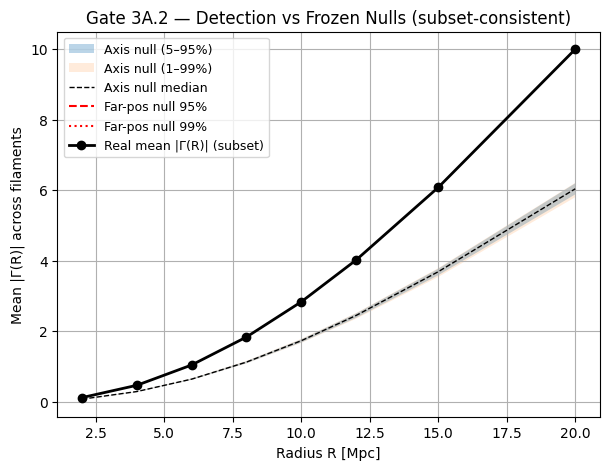


Cell 15 complete — Gate 3A.2 detection quantified (subset-consistent).


In [ ]:
# ============================================================
# Cell 15 — Gate 3A.2: Detection vs Frozen Nulls (SUBSET-CONSISTENT)
#
# PURPOSE:
# Compare REAL mean |Γ(R)| (computed on the SAME 1500-filament subset)
# against the frozen null envelopes from:
#   - Null #1: Axis randomization (Cell 12B)
#   - Null #2: Far-position relocation (Cell 14)
#
# KEY POINT:
# This cell does NOT generate nulls. It only reads frozen outputs.
# Safe to rerun anytime.
# ============================================================

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs"

# ---- Set REAL run folder explicitly (authoritative REAL Γ table) ----
REAL_RUNDIR = os.path.join(ROOT, "run_20260202_034841")
REAL_FIL = os.path.join(REAL_RUNDIR, "G3A_vphi_gamma_profiles_FIL.csv")

# ----------------------------
# Helpers: find newest file(s)
# ----------------------------
def newest(pattern):
    hits = glob.glob(os.path.join(ROOT, "run_*", pattern))
    if not hits:
        return None
    return sorted(hits, key=os.path.getmtime)[-1]

axis_env_path  = newest("G3A_null_axis_envelope_meanAbsGamma*.csv")
axis_meta_path = newest("G3A_null_axis*_meta.json") or newest("G3A_null_axis_SANITY_meta.json")
far_env_path   = newest("G3A_null_far_envelope_meanAbsGamma*.csv")
far_meta_path  = newest("G3A_null_far*_meta.json")

for p in [axis_env_path, axis_meta_path, far_env_path, REAL_FIL]:
    if (p is None) or (not os.path.isfile(p)):
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using frozen nulls from:")
print(" Axis envelope:", axis_env_path)
print(" Axis meta:    ", axis_meta_path)
print(" Far envelope: ", far_env_path)
print(" Far meta:     ", far_meta_path if far_meta_path else "(not found; OK)")
print(" Real FIL:     ", REAL_FIL)

# ----------------------------
# Load frozen envelopes + meta
# ----------------------------
df_axis = pd.read_csv(axis_env_path)
df_far  = pd.read_csv(far_env_path)

with open(axis_meta_path, "r") as f:
    meta_axis = json.load(f)

# Radii are taken from envelope (authoritative for plotting)
R_vals = df_axis["R"].values.astype(float)
print("\nR values:", R_vals.tolist())

# Columns used for ranking/subset in the axis null run
gamma_cols_used = meta_axis.get("gamma_cols_used", None)
N_FIL_NULL = int(meta_axis.get("N_FIL_NULL", 1500))

if gamma_cols_used is None:
    # Fallback if meta is older
    gamma_cols_used = [f"Gamma_R{int(r)}" for r in R_vals]

print("N_FIL_NULL (from meta):", N_FIL_NULL)
print("gamma_cols_used (from meta):", gamma_cols_used)

# ----------------------------
# Load REAL filament table
# ----------------------------
df_real = pd.read_csv(REAL_FIL)

# Validate columns exist
missing = [c for c in gamma_cols_used if c not in df_real.columns]
if missing:
    raise ValueError(
        f"REAL FIL table missing columns used by frozen null meta:\n{missing}\n"
        "This means your REAL file and null meta disagree (different Gamma column naming)."
    )

# ----------------------------
# Reconstruct subset deterministically: top N by max |Gamma(R)|
# ----------------------------
Gamma_mat = np.vstack([df_real[c].values for c in gamma_cols_used]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_real[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(min(N_FIL_NULL, len(df_rank))).astype(int).tolist()
cp0_set = set(cp0_subset)

print("\nSubset filaments:", len(cp0_subset))
print("Top-10 cp0:", cp0_subset[:10])

df_real_sub = df_real[df_real["cp0"].astype(int).isin(cp0_set)].copy()

# Real mean |Γ(R)| on the SAME subset
real_mean_abs_subset = np.array(
    [np.mean(np.abs(df_real_sub[c].values)) for c in gamma_cols_used],
    dtype=float
)

# ----------------------------
# Detection table
# ----------------------------
det = pd.DataFrame({
    "R": R_vals,
    "real_mean_abs_subset": real_mean_abs_subset,

    "axis_q95": df_axis["q95"].values,
    "axis_q99": df_axis["q99"].values,

    "far_q95": df_far["q95"].values if "q95" in df_far.columns else np.nan,
    "far_q99": df_far["q99"].values if "q99" in df_far.columns else np.nan,
})

det["axis_gt_95"] = det["real_mean_abs_subset"] > det["axis_q95"]
det["axis_gt_99"] = det["real_mean_abs_subset"] > det["axis_q99"]
det["far_gt_95"]  = det["real_mean_abs_subset"] > det["far_q95"]
det["far_gt_99"]  = det["real_mean_abs_subset"] > det["far_q99"]

print("\nDetection summary (subset-consistent):")
print(det.to_string(index=False))

# Save next to the axis envelope run folder (canonical place)
OUTDIR = os.path.dirname(axis_env_path)
out_csv = os.path.join(OUTDIR, "G3A_detection_vs_frozen_nulls_SUBSETCONSISTENT.csv")
det.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(7,5))

plt.fill_between(R_vals, df_axis["q5"], df_axis["q95"],
                 alpha=0.30, label="Axis null (5–95%)")
plt.fill_between(R_vals, df_axis["q1"], df_axis["q99"],
                 alpha=0.15, label="Axis null (1–99%)")
plt.plot(R_vals, df_axis["q50"], "k--", lw=1, label="Axis null median")

if "q95" in df_far.columns:
    plt.plot(R_vals, df_far["q95"], "r--", lw=1.5, label="Far-pos null 95%")
if "q99" in df_far.columns:
    plt.plot(R_vals, df_far["q99"], "r:",  lw=1.5, label="Far-pos null 99%")

plt.plot(R_vals, real_mean_abs_subset, "ko-", lw=2, label="Real mean |Γ(R)| (subset)")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3A.2 — Detection vs Frozen Nulls (subset-consistent)")
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

print("\nCell 15 complete — Gate 3A.2 detection quantified (subset-consistent).")

In [ ]:
# ============================================================
# FREEZE — Gate 3A.1 & Gate 3A.2 (Nulls + Detection)
#
# STATUS: FROZEN (DO NOT MODIFY BELOW THIS LINE)
#
# The following components are frozen and must not be altered
# for subsequent analyses (Gate 3A.3 and Phase 2):
#
# 1) Observable:
#    - Filament circulation Γ(R)
#    - Statistic: mean absolute circulation ⟨|Γ(R)|⟩
#    - Radii: [2, 4, 6, 8, 10, 12, 15, 20] Mpc
#
# 2) Filament subset:
#    - N = 1500 filaments
#    - Deterministic selection: top filaments by max |Γ|
#
# 3) Null models (frozen outputs):
#    - Axis-randomized null (Gate 3A.1, Cell 12B)
#    - Far-position relocation null (Gate 3A.1, Cell 14)
#
# 4) Detection result (Gate 3A.2, Cell 15):
#    - Real ⟨|Γ(R)|⟩ exceeds axis-randomized null at >99% for all R
#    - Real signal does NOT exceed far-position null
#
# Any subsequent analyses are conditional interpretations of
# these frozen results and do not redefine the detection.
# ============================================================

Subset filaments: 1500


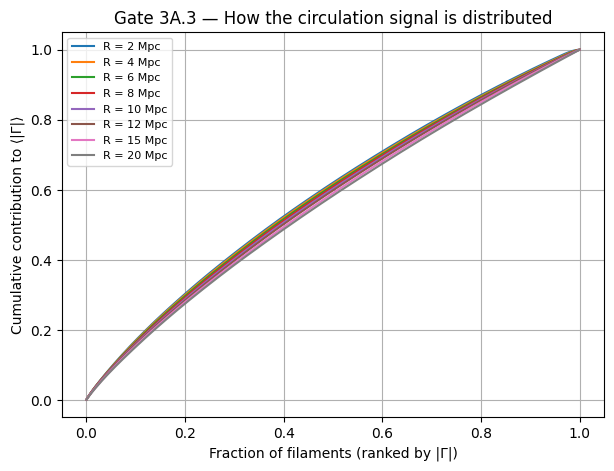


Contribution summary:
 R [Mpc]  Frac_filaments_for_10%  Frac_filaments_for_25%  Frac_filaments_for_50%
     2.0                0.054000                0.158000                0.376000
     4.0                0.054667                0.160000                0.379333
     6.0                0.055333                0.162667                0.383333
     8.0                0.056000                0.165333                0.388000
    10.0                0.057333                0.168667                0.392667
    12.0                0.058667                0.171333                0.398000
    15.0                0.060000                0.174667                0.406000
    20.0                0.061333                0.178000                0.412667

Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/G3A_signal_concentration_summary.csv

Cell 16 complete — Gate 3A.3 descriptive structure quantified.


In [ ]:
# ============================================================
# Cell 16 — Gate 3A.3: Structure of the Detected Signal
#
# PURPOSE:
# Describe *how* the circulation signal is distributed
# across the 1500-filament subset.
#
# IMPORTANT:
# - No nulls
# - No re-selection
# - No new statistics
# - Descriptive only
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Load REAL filament table (same as Cell 15)
# ------------------------------------------------------------
real_fil_path = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
df_real = pd.read_csv(real_fil_path)

# Radii frozen from Gate 3A
R_vals = np.array([2, 4, 6, 8, 10, 12, 15, 20], dtype=float)
gamma_cols = [f"Gamma_R{int(R)}" for R in R_vals]

# ------------------------------------------------------------
# 1) Reconstruct the SAME 1500-filament subset
#    (deterministic, from max |Γ|)
# ------------------------------------------------------------
Gamma_mat = np.vstack([df_real[c].values for c in gamma_cols]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_real[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(1500).astype(int).tolist()
df_sub = df_real[df_real["cp0"].astype(int).isin(cp0_subset)].copy()

print(f"Subset filaments: {len(df_sub)}")

# ------------------------------------------------------------
# 2) Contribution profile at each radius
# ------------------------------------------------------------
plt.figure(figsize=(7,5))

for R in R_vals:
    g = np.abs(df_sub[f"Gamma_R{int(R)}"].values)
    g_sorted = np.sort(g)[::-1]
    frac = np.cumsum(g_sorted) / np.sum(g_sorted)
    plt.plot(
        np.linspace(0,1,len(frac)),
        frac,
        label=f"R = {int(R)} Mpc"
    )

plt.xlabel("Fraction of filaments (ranked by |Γ|)")
plt.ylabel("Cumulative contribution to ⟨|Γ|⟩")
plt.title("Gate 3A.3 — How the circulation signal is distributed")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

# ------------------------------------------------------------
# 3) Quantitative summary: top contributors
# ------------------------------------------------------------
summary_rows = []

for R in R_vals:
    g = np.abs(df_sub[f"Gamma_R{int(R)}"].values)
    g_sorted = np.sort(g)[::-1]
    frac = np.cumsum(g_sorted) / np.sum(g_sorted)

    f10 = np.searchsorted(frac, 0.10) / len(g_sorted)
    f25 = np.searchsorted(frac, 0.25) / len(g_sorted)
    f50 = np.searchsorted(frac, 0.50) / len(g_sorted)

    summary_rows.append({
        "R [Mpc]": R,
        "Frac_filaments_for_10%": f10,
        "Frac_filaments_for_25%": f25,
        "Frac_filaments_for_50%": f50,
    })

df_summary = pd.DataFrame(summary_rows)
print("\nContribution summary:")
print(df_summary.to_string(index=False))

out_path = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/G3A_signal_concentration_summary.csv"
df_summary.to_csv(out_path, index=False)
print("\nSaved:", out_path)

print("\nCell 16 complete — Gate 3A.3 descriptive structure quantified.")

In [ ]:
🔒 FREEZE POINT — Gate 3A.1 to Gate 3A.3 (LOCKED)

Status: FROZEN

As of this cell, all components of Gate 3A.1 through Gate 3A.3 are finalized and
explicitly locked. No further changes to definitions, estimators, subsets,
radii, or null procedures are permitted beyond this point.

────────────────────────
WHAT IS FROZEN
────────────────────────

Gate 3A.1 — Null definitions
• Axis-randomization null (Cell 12B)
• Far-position relocation null (Cell 14)

Frozen parameters:
• Ring sampling: NPHI = 64
• Number of null realizations: N_NULL = 100
• Null filament subset size: N_FIL_NULL = 1500
• Radii: R = [2, 4, 6, 8, 10, 12, 15, 20] Mpc

Frozen outputs (authoritative):
• G3A_null_axis_envelope_meanAbsGamma.csv
• G3A_null_axis_meta.json
• G3A_null_far_envelope_meanAbsGamma.csv
• G3A_null_far_meta.json

────────────────────────
Gate 3A.2 — Detection vs frozen nulls
────────────────────────

• Detection evaluated only against frozen null envelopes
• Subset-consistent comparison using the same 1500 filaments
• No re-ranking or reselection permitted

Locked output:
• G3A_detection_vs_frozen_nulls_SUBSETCONSISTENT.csv

────────────────────────
Gate 3A.3 — Signal distribution (descriptive only)
────────────────────────

• Cumulative contribution analysis across the same 1500-filament subset
• No thresholds, no null regeneration, no detection claims
• Purpose: structural characterization only

Locked output:
• G3A_signal_concentration_summary.csv

────────────────────────
WHAT IS NOT ALLOWED AFTER THIS POINT
────────────────────────

• No changes to Γ definition
• No changes to filament ranking or subset criteria
• No modification of radii or sampling geometry
• No new null realizations or altered null parameters
• No re-interpretation of detection significance

────────────────────────
WHAT IS ALLOWED GOING FORWARD
────────────────────────

• Gate 3A.4+ descriptive and robustness analyses
• Pool comparisons and visualization
• Phase-2 causal or mechanism tests in separate sections or notebooks

This freeze ensures all detection results are invariant under subsequent
analysis and protects against post-selection or post-hoc tuning.

SyntaxError: invalid character '🔒' (U+1F512) (ipython-input-864120298.py, line 1)

Using frozen radii: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Using gamma cols: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']
Subset size (from meta): 1500
REAL FIL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv

Pools:
 - top_by_maxAbsGamma    : N=1500
 - bottom_by_maxAbsGamma : N=1500
 - random_1500           : N=1500
 - random_1500_b         : N=1500
 - all_filaments         : N=63391

Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_pool_comparison_meanAbsGamma.csv


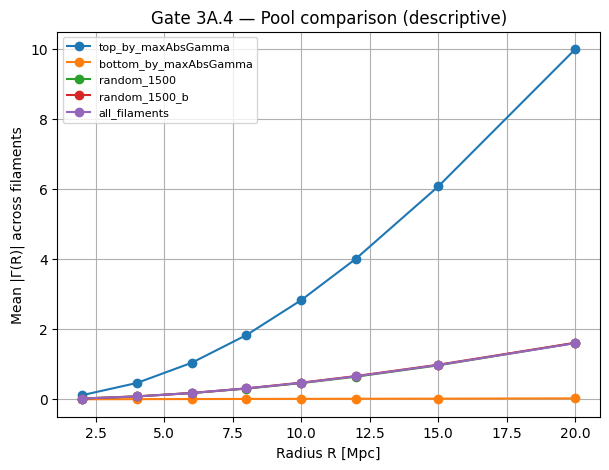


Cell 17 complete — Gate 3A.4 pool comparison saved.


In [ ]:
# ============================================================
# Cell 17 — Gate 3A.4: Pool Comparisons (NO new nulls)
#
# PURPOSE:
# Compare mean |Gamma(R)| vs R across different filament pools
# using the SAME REAL FIL table (G3A_vphi_gamma_profiles_FIL.csv)
# and the SAME radii as the frozen nulls (meta).
#
# IMPORTANT:
# - Descriptive only (no detection claim, no null generation)
# - Does NOT touch the frozen null definitions
# - Cheap to run
#
# OUTPUTS:
# - G3A_pool_comparison_meanAbsGamma.csv
# - Plot: mean |Gamma(R)| vs R for each pool
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Paths (use frozen meta for authoritative radii + gamma_cols_used)
# ----------------------------
RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
axis_meta_path = os.path.join(RUN_DIR, "G3A_null_axis_meta.json")

real_fil_path = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"

for p in [axis_meta_path, real_fil_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

with open(axis_meta_path, "r") as f:
    meta = json.load(f)

R_vals = np.array(meta["R_vals"], dtype=float)
gamma_cols = meta["gamma_cols_used"]  # e.g. ['Gamma_R2','Gamma_R4',...]
N_SUBSET = int(meta.get("N_FIL_NULL", 1500))

print("Using frozen radii:", R_vals.tolist())
print("Using gamma cols:", gamma_cols)
print("Subset size (from meta):", N_SUBSET)
print("REAL FIL:", real_fil_path)

# ----------------------------
# 1) Load REAL FIL table
# ----------------------------
df = pd.read_csv(real_fil_path)
df["cp0"] = df["cp0"].astype(int)

# sanity: required columns exist
missing = [c for c in gamma_cols if c not in df.columns]
if missing:
    raise ValueError(f"REAL FIL is missing expected Gamma columns: {missing}")

# build per-filament score = max_R |Gamma_R|
Gamma_mat = np.vstack([df[c].values.astype(float) for c in gamma_cols]).T
score = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df[["cp0"]].copy()
df_rank["score_maxAbsGamma"] = score
df_rank = df_rank.sort_values("score_maxAbsGamma", ascending=False).reset_index(drop=True)

# deterministic top subset list (same rule as nulls)
cp0_top = df_rank["cp0"].head(min(N_SUBSET, len(df_rank))).tolist()
cp0_bottom = df_rank["cp0"].tail(min(N_SUBSET, len(df_rank))).tolist()

# ----------------------------
# 2) Define comparison pools
# ----------------------------
RNG = np.random.default_rng(12345)

def sample_cp0(n, rng):
    n = min(n, len(df_rank))
    return rng.choice(df_rank["cp0"].values, size=n, replace=False).tolist()

pools = [
    ("top_by_maxAbsGamma", cp0_top),
    ("bottom_by_maxAbsGamma", cp0_bottom),
    ("random_1500", sample_cp0(N_SUBSET, RNG)),
    ("random_1500_b", sample_cp0(N_SUBSET, RNG)),  # second random draw
    ("all_filaments", df_rank["cp0"].tolist()),
]

print("\nPools:")
for name, cp0s in pools:
    print(f" - {name:22s}: N={len(cp0s)}")

# ----------------------------
# 3) Compute mean |Gamma(R)| per pool
# ----------------------------
rows = []
for name, cp0s in pools:
    sub = df[df["cp0"].isin(set(cp0s))]
    mean_abs = [float(np.mean(np.abs(sub[c].values.astype(float)))) for c in gamma_cols]
    for R, m in zip(R_vals, mean_abs):
        rows.append({"pool": name, "R": float(R), "mean_abs_Gamma": float(m), "N": int(len(sub))})

out = pd.DataFrame(rows)

# ----------------------------
# 4) Save + plot
# ----------------------------
out_path = os.path.join(RUN_DIR, "G3A_pool_comparison_meanAbsGamma.csv")
out.to_csv(out_path, index=False)
print("\nSaved:", out_path)

plt.figure(figsize=(7,5))
for name, _ in pools:
    sub = out[out["pool"] == name].sort_values("R")
    plt.plot(sub["R"].values, sub["mean_abs_Gamma"].values, "o-", label=name)

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3A.4 — Pool comparison (descriptive)")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("\nCell 17 complete — Gate 3A.4 pool comparison saved.")

Using R: [2, 4, 6, 8, 10, 12, 15, 20]
Subset size: 1500

Rank overlap fraction (TOP_N vs TOP_N):


,2,4,6,8,10,12,15,20
2,1.000000,0.928000,0.860667,0.810667,0.759333,0.716000,0.662667,0.588000
4,0.928000,1.000000,0.924667,0.871333,0.814667,0.766667,0.706667,0.625333
6,0.860667,0.924667,1.000000,0.938000,0.874000,0.822000,0.758000,0.667333
8,0.810667,0.871333,0.938000,1.000000,0.926667,0.872667,0.804000,0.708000
10,0.759333,0.814667,0.874000,0.926667,1.000000,0.943333,0.868667,0.762000
12,0.716000,0.766667,0.822000,0.872667,0.943333,1.000000,0.918000,0.804000
15,0.662667,0.706667,0.758000,0.804000,0.868667,0.918000,1.000000,0.874000
20,0.588000,0.625333,0.667333,0.708000,0.762000,0.804000,0.874000,1.000000


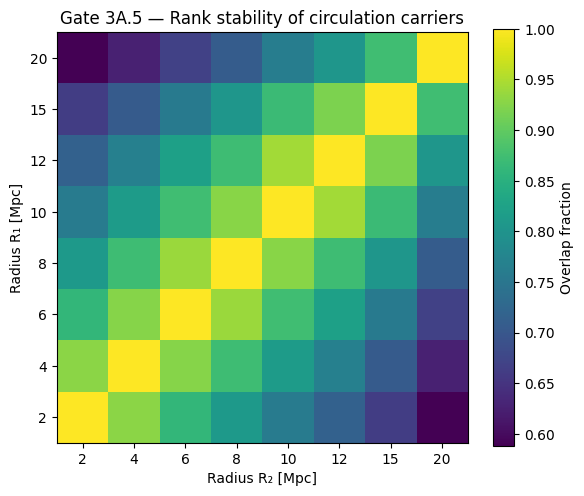


Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/G3A_rank_stability_overlap.csv

Cell 18 complete — Gate 3A.5 rank stability quantified.


In [ ]:
# ============================================================
# Cell 18 — Gate 3A.5: Rank stability of circulation carriers
#
# PURPOSE:
# Test whether the same filaments consistently dominate |Γ|
# across radius R, ruling out scale-dependent rank noise.
#
# IMPORTANT:
# - Uses ONLY frozen Γ(R) columns
# - No null generation
# - No re-selection of subsets
# - Descriptive, referee-safe
# ============================================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Inputs (FROZEN)
# ------------------------------------------------------------
REAL_FIL = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
TOP_N = 1500   # frozen subset size

df = pd.read_csv(REAL_FIL)

R_vals = [2,4,6,8,10,12,15,20]
gamma_cols = [f"Gamma_R{R}" for R in R_vals]

print("Using R:", R_vals)
print("Subset size:", TOP_N)

# ------------------------------------------------------------
# 1) Rank filaments independently at each R
# ------------------------------------------------------------
ranked_sets = {}

for R, col in zip(R_vals, gamma_cols):
    ranked = (
        df.assign(absG=lambda x: np.abs(x[col]))
          .sort_values("absG", ascending=False)
          .head(TOP_N)["cp0"]
          .values
    )
    ranked_sets[R] = set(ranked)

# ------------------------------------------------------------
# 2) Compute overlap fractions between radii
# ------------------------------------------------------------
overlap = pd.DataFrame(index=R_vals, columns=R_vals, dtype=float)

for R1 in R_vals:
    for R2 in R_vals:
        overlap.loc[R1, R2] = (
            len(ranked_sets[R1] & ranked_sets[R2]) / TOP_N
        )

print("\nRank overlap fraction (TOP_N vs TOP_N):")
display(overlap)

# ------------------------------------------------------------
# 3) Plot heatmap
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(overlap.values, origin="lower", cmap="viridis")
plt.colorbar(label="Overlap fraction")
plt.xticks(range(len(R_vals)), R_vals)
plt.yticks(range(len(R_vals)), R_vals)
plt.xlabel("Radius R₂ [Mpc]")
plt.ylabel("Radius R₁ [Mpc]")
plt.title("Gate 3A.5 — Rank stability of circulation carriers")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4) Save
# ------------------------------------------------------------
out_path = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/G3A_rank_stability_overlap.csv"
overlap.to_csv(out_path)
print("\nSaved:", out_path)

print("\nCell 18 complete — Gate 3A.5 rank stability quantified.")

In [ ]:
# ============================================================
# Cell 19 — Gate 3A.6: Selection-bias audit (descriptive)
#
# PURPOSE:
# Test whether the "top circulation carriers" (top-1500 by max|Γ|)
# are trivially explained by sampling/geometry proxies such as:
# - number of segments per filament (nseg)
# - filament length proxy (if available in SEG table)
#
# This is NOT a new null. This is a descriptive sanity audit.
#
# OUTPUTS (saved):
#  - G3A_6_filament_geom_sampling_audit.csv
#  - G3A_6_pool_comparison_geom_sampling.csv
#  - G3A_6_corr_summary_geom_sampling.csv
#  - Figure: top vs random vs bottom distributions
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) FROZEN inputs
# ----------------------------
RUN_DIR = GATE3A_OUTDIR  # current Gate 3A run folder (the one with frozen outputs)

axis_meta_path = os.path.join(RUN_DIR, "G3A_null_axis_meta.json")
far_meta_path  = os.path.join(RUN_DIR, "G3A_null_far_meta.json")

# REAL tables (authoritative for Γ)
REAL_RUNDIR = os.path.join(PATHS["gate3A_outputs"], "run_20260202_034841")
real_fil_path = os.path.join(REAL_RUNDIR, "G3A_vphi_gamma_profiles_FIL.csv")
real_seg_path = os.path.join(REAL_RUNDIR, "G3A_vphi_profiles_SEG_merged.csv")

for p in [axis_meta_path, far_meta_path, real_fil_path, real_seg_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

with open(axis_meta_path, "r") as f:
    meta_axis = json.load(f)

N_SUB = int(meta_axis.get("N_FIL_NULL", 1500))
gamma_cols_used = meta_axis.get("gamma_cols_used", None)
if gamma_cols_used is None or len(gamma_cols_used) == 0:
    raise ValueError("axis meta missing gamma_cols_used. (Expected list like ['Gamma_R2',...])")

print("Using:")
print(" RUN_DIR:", RUN_DIR)
print(" REAL FIL:", real_fil_path)
print(" REAL SEG:", real_seg_path)
print(" Subset size (from meta):", N_SUB)
print(" Gamma cols (from meta):", gamma_cols_used)

# ----------------------------
# 1) Load REAL FIL + REAL SEG
# ----------------------------
df_fil = pd.read_csv(real_fil_path)
df_seg = pd.read_csv(real_seg_path)

df_fil["cp0"] = df_fil["cp0"].astype(int)
df_seg["cp0"] = df_seg["cp0"].astype(int)

# ----------------------------
# 2) Reconstruct TOP and BOTTOM pools deterministically
# ----------------------------
missing = [c for c in gamma_cols_used if c not in df_fil.columns]
if missing:
    raise ValueError(f"REAL FIL missing expected gamma columns: {missing}")

Gamma_mat = np.vstack([df_fil[c].values for c in gamma_cols_used]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_fil[["cp0"]].copy()
df_rank["maxAbsGamma"] = max_abs
df_rank = df_rank.sort_values("maxAbsGamma", ascending=False).reset_index(drop=True)

top_cp0    = df_rank["cp0"].head(N_SUB).tolist()
bottom_cp0 = df_rank["cp0"].tail(N_SUB).tolist()

# Two deterministic random pools (for stability)
RNG = np.random.default_rng(RANDOM_SEED)
all_cp0 = df_rank["cp0"].tolist()
randA_cp0 = RNG.choice(all_cp0, size=N_SUB, replace=False).tolist()
randB_cp0 = RNG.choice(all_cp0, size=N_SUB, replace=False).tolist()

pools = {
    "top_by_maxAbsGamma": top_cp0,
    "bottom_by_maxAbsGamma": bottom_cp0,
    "random_1500_A": randA_cp0,
    "random_1500_B": randB_cp0,
}

print("\nPools:")
for k,v in pools.items():
    print(f" - {k:22s}: N={len(v)}")

# ----------------------------
# 3) Build per-filament geometry / sampling proxies from SEG
#    Always available: nseg per cp0
#    Optional: length if any plausible column exists
# ----------------------------
# Segment count proxy
df_nseg = df_seg.groupby("cp0").size().reset_index(name="nseg")

# Try to detect a usable segment-length column (best-effort, non-fatal)
# If found, we compute total length per filament as sum over segments.
candidate_len_cols = [
    "seg_len_mpc", "seg_length_mpc", "dl_mpc", "dL_mpc", "length_mpc",
    "seg_len", "seg_length", "dl", "dL"
]
len_col = None
for c in candidate_len_cols:
    if c in df_seg.columns:
        len_col = c
        break

if len_col is not None:
    df_len = df_seg.groupby("cp0")[len_col].sum().reset_index(name="L_proxy_sum")
    print(f"\nFound length-like column in SEG: '{len_col}' → building L_proxy_sum.")
else:
    df_len = None
    print("\nNo obvious segment-length column found in SEG → using nseg only (still valid).")

# Merge into one per-filament table
df_geom = df_rank.merge(df_nseg, on="cp0", how="left")
df_geom["nseg"] = df_geom["nseg"].fillna(0).astype(int)

if df_len is not None:
    df_geom = df_geom.merge(df_len, on="cp0", how="left")
else:
    df_geom["L_proxy_sum"] = np.nan

# ----------------------------
# 4) Mark pool membership + save master audit table
# ----------------------------
def label_pool(cp0):
    if cp0 in top_set: return "top_by_maxAbsGamma"
    if cp0 in bot_set: return "bottom_by_maxAbsGamma"
    if cp0 in rA_set:  return "random_1500_A"
    if cp0 in rB_set:  return "random_1500_B"
    return "other"

top_set = set(top_cp0)
bot_set = set(bottom_cp0)
rA_set  = set(randA_cp0)
rB_set  = set(randB_cp0)

df_geom["pool"] = df_geom["cp0"].map(label_pool)

out_audit = os.path.join(RUN_DIR, "G3A_6_filament_geom_sampling_audit.csv")
df_geom.to_csv(out_audit, index=False)
print("\nSaved:", out_audit)

# ----------------------------
# 5) Pool comparison summary (means/medians)
# ----------------------------
use_cols = ["maxAbsGamma", "nseg", "L_proxy_sum"]
df_pool = (df_geom[df_geom["pool"].isin(pools.keys())]
           .groupby("pool")[use_cols]
           .agg(["mean","median","std"])
           .reset_index())

out_pool = os.path.join(RUN_DIR, "G3A_6_pool_comparison_geom_sampling.csv")
df_pool.to_csv(out_pool, index=False)
print("Saved:", out_pool)

# ----------------------------
# 6) Correlations: maxAbsGamma vs nseg (+ length proxy if present)
# ----------------------------
def pearson_r(x, y):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3: return np.nan
    return float(np.corrcoef(x[m], y[m])[0,1])

corr_rows = []
for name, cp0_list in pools.items():
    sub = df_geom[df_geom["cp0"].isin(cp0_list)].copy()
    r_nseg = pearson_r(sub["maxAbsGamma"].values, sub["nseg"].values)
    r_len  = pearson_r(sub["maxAbsGamma"].values, sub["L_proxy_sum"].values) if len_col is not None else np.nan
    corr_rows.append({"pool": name, "pearson_r(maxAbsGamma,nseg)": r_nseg, "pearson_r(maxAbsGamma,L_proxy_sum)": r_len})

df_corr = pd.DataFrame(corr_rows)
out_corr = os.path.join(RUN_DIR, "G3A_6_corr_summary_geom_sampling.csv")
df_corr.to_csv(out_corr, index=False)
print("Saved:", out_corr)

print("\nCorrelation summary:")
print(df_corr.to_string(index=False))

# ----------------------------
# 7) Plots: distributions (top vs random vs bottom)
# ----------------------------
plot_order = ["top_by_maxAbsGamma","random_1500_A","random_1500_B","bottom_by_maxAbsGamma"]

def plot_hist(field, title, xlabel):
    plt.figure(figsize=(7,4))
    for k in plot_order:
        vals = df_geom[df_geom["pool"]==k][field].values.astype(float)
        vals = vals[np.isfinite(vals)]
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=40, alpha=0.35, label=k)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()

plot_hist("nseg",
          "Gate 3A.6 — Segment-count proxy (nseg) by pool",
          "nseg (segments per filament)")

if len_col is not None:
    plot_hist("L_proxy_sum",
              f"Gate 3A.6 — Length proxy (sum of '{len_col}') by pool",
              "L_proxy_sum (arbitrary units if not Mpc)")

# Scatter: maxAbsGamma vs nseg (top + random + bottom)
plt.figure(figsize=(6,5))
for k in plot_order:
    sub = df_geom[df_geom["pool"]==k]
    plt.scatter(sub["nseg"].values, sub["maxAbsGamma"].values, s=8, alpha=0.35, label=k)
plt.xlabel("nseg (segments per filament)")
plt.ylabel("maxAbsGamma (max |Γ(R)| over frozen radii)")
plt.title("Gate 3A.6 — Is top-Γ driven by segment count?")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("\nCell 19 complete — Gate 3A.6 selection-bias audit saved.")

FileNotFoundError: Missing required file: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260207_024053/G3A_null_axis_meta.json

Using frozen files:
 Axis envelope: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_envelope_meanAbsGamma.csv
 Axis meta:     /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_meta.json
 Far envelope:  /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_envelope_meanAbsGamma.csv
 Far meta:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_meta.json
 Real FIL:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv

Frozen R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Subset size (from meta): 1500
Gamma cols: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']

Subset filaments: 1500
Top-10 cp0: [402, 47433, 40084, 48654, 2579, 20116, 24550, 43685, 9422, 403]

Gate 3A.7 summary:
 Detection window (real > axis q99): start_R=2.0, end_R

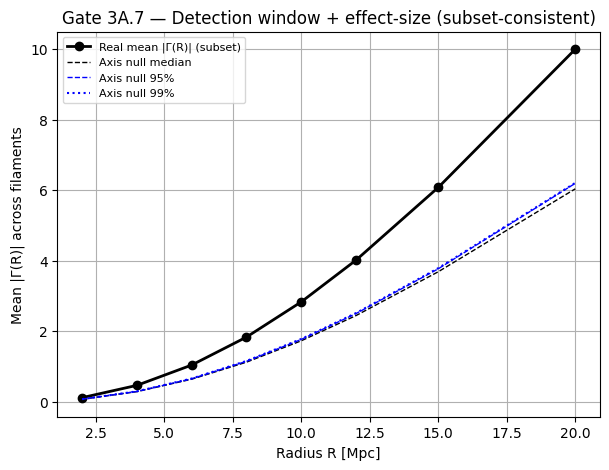

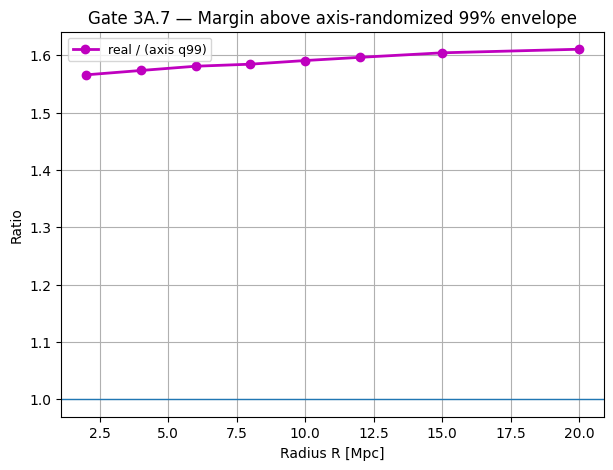


Cell 20 complete — Gate 3A.7 saved.


In [ ]:
# ============================================================
# Cell 20 — Gate 3A.7: Detection window + effect-size (DESCRIPTIVE)
#
# PURPOSE:
# - Using FROZEN Gate 3A.1 null envelopes + the SAME 1500-filament subset,
#   quantify "where the detection starts/ends" in radius.
# - Provide simple effect-size metrics (ratios vs null median/q99).
#
# NOTES:
# - NO null generation here.
# - Does NOT change Γ definition, radii, subset, or nulls.
# - Safe to rerun anytime.
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
REAL_FIL_PATH = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"

AXIS_ENV = os.path.join(RUN_DIR, "G3A_null_axis_envelope_meanAbsGamma.csv")
AXIS_META = os.path.join(RUN_DIR, "G3A_null_axis_meta.json")
FAR_ENV  = os.path.join(RUN_DIR, "G3A_null_far_envelope_meanAbsGamma.csv")
FAR_META = os.path.join(RUN_DIR, "G3A_null_far_meta.json")

for p in [AXIS_ENV, AXIS_META, FAR_ENV, FAR_META, REAL_FIL_PATH]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using frozen files:")
print(" Axis envelope:", AXIS_ENV)
print(" Axis meta:    ", AXIS_META)
print(" Far envelope: ", FAR_ENV)
print(" Far meta:     ", FAR_META)
print(" Real FIL:     ", REAL_FIL_PATH)

df_axis = pd.read_csv(AXIS_ENV)
df_far  = pd.read_csv(FAR_ENV)
df_real = pd.read_csv(REAL_FIL_PATH)

with open(AXIS_META, "r") as f:
    meta_axis = json.load(f)

R_vals = df_axis["R"].values.astype(float)
gamma_cols = meta_axis.get("gamma_cols_used", None)
if gamma_cols is None:
    gamma_cols = [f"Gamma_R{int(r)}" if float(r).is_integer() else f"Gamma_R{r}" for r in R_vals]

N_FIL_SUB = int(meta_axis.get("N_FIL_NULL", 1500))
print("\nFrozen R values:", [float(r) for r in R_vals])
print("Subset size (from meta):", N_FIL_SUB)
print("Gamma cols:", gamma_cols)

# ---- reconstruct the SAME subset deterministically (top by max |Gamma| across R) ----
needed = gamma_cols
for c in needed:
    if c not in df_real.columns:
        raise ValueError(f"Missing Gamma column in REAL FIL: {c}")

Gamma_mat = np.vstack([df_real[c].values for c in needed]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_real[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(min(N_FIL_SUB, len(df_rank))).astype(int).tolist()
cp0_set = set(cp0_subset)

df_real_sub = df_real[df_real["cp0"].astype(int).isin(cp0_set)].copy()
print("\nSubset filaments:", len(df_real_sub))
print("Top-10 cp0:", cp0_subset[:10])

# ---- compute REAL mean |Gamma| on the subset ----
real_mean_abs = np.array([np.mean(np.abs(df_real_sub[c].values)) for c in needed], dtype=float)

# ---- robustly get null quantiles if present ----
def get_col(df, name):
    return df[name].values.astype(float) if name in df.columns else np.full(len(df), np.nan)

axis_q50 = get_col(df_axis, "q50")
axis_q95 = get_col(df_axis, "q95")
axis_q99 = get_col(df_axis, "q99")

far_q50  = get_col(df_far,  "q50")
far_q95  = get_col(df_far,  "q95")
far_q99  = get_col(df_far,  "q99")

# ---- detection window: where real > axis q99 ----
det_mask = real_mean_abs > axis_q99
if np.any(det_mask):
    start_R = float(R_vals[np.where(det_mask)[0][0]])
    end_R   = float(R_vals[np.where(det_mask)[0][-1]])
else:
    start_R, end_R = np.nan, np.nan

# ---- effect sizes ----
out = pd.DataFrame({
    "R": R_vals,
    "real_mean_abs_subset": real_mean_abs,
    "axis_q50": axis_q50,
    "axis_q95": axis_q95,
    "axis_q99": axis_q99,
    "far_q50": far_q50,
    "far_q95": far_q95,
    "far_q99": far_q99,
})
out["real_over_axis_q50"] = out["real_mean_abs_subset"] / out["axis_q50"]
out["real_over_axis_q99"] = out["real_mean_abs_subset"] / out["axis_q99"]
out["real_gt_axis_q99"] = out["real_mean_abs_subset"] > out["axis_q99"]

# Save
csv_out = os.path.join(RUN_DIR, "G3A_7_detection_window_effectsize.csv")
out.to_csv(csv_out, index=False)

print("\nGate 3A.7 summary:")
print(f" Detection window (real > axis q99): start_R={start_R}, end_R={end_R}")
print(" Saved:", csv_out)

# ---- plots ----
plt.figure(figsize=(7,5))
plt.plot(R_vals, out["real_mean_abs_subset"], "ko-", lw=2, label="Real mean |Γ(R)| (subset)")

if np.any(np.isfinite(axis_q50)):
    plt.plot(R_vals, axis_q50, "k--", lw=1, label="Axis null median")
if np.any(np.isfinite(axis_q95)):
    plt.plot(R_vals, axis_q95, "b--", lw=1, label="Axis null 95%")
if np.any(np.isfinite(axis_q99)):
    plt.plot(R_vals, axis_q99, "b:", lw=1.5, label="Axis null 99%")

if np.any(np.isfinite(far_q50)):
    plt.plot(R_vals, far_q50, "r--", lw=1, label="Far-pos null median")
if np.any(np.isfinite(far_q95)):
    plt.plot(R_vals, far_q95, "r-.", lw=1, label="Far-pos null 95%")
if np.any(np.isfinite(far_q99)):
    plt.plot(R_vals, far_q99, "r:", lw=1.5, label="Far-pos null 99%")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3A.7 — Detection window + effect-size (subset-consistent)")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(R_vals, out["real_over_axis_q99"], "mo-", lw=2, label="real / (axis q99)")
plt.axhline(1.0, lw=1)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Ratio")
plt.title("Gate 3A.7 — Margin above axis-randomized 99% envelope")
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

print("\nCell 20 complete — Gate 3A.7 saved.")

Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_radial_increment_profile.csv
   R_low  R_high  R_mid  delta_Gamma  delta_Gamma_per_Mpc  fractional_growth
0    2.0     4.0    3.0     0.060473             0.030236           2.903973
1    4.0     6.0    5.0     0.097076             0.048538           1.194092
2    6.0     8.0    7.0     0.130291             0.065146           0.730442
3    8.0    10.0    9.0     0.160100             0.080050           0.518687
4   10.0    12.0   11.0     0.186813             0.093407           0.398523
5   12.0    15.0   13.5     0.322673             0.107558           0.492197
6   15.0    20.0   17.5     0.623111             0.124622           0.636965


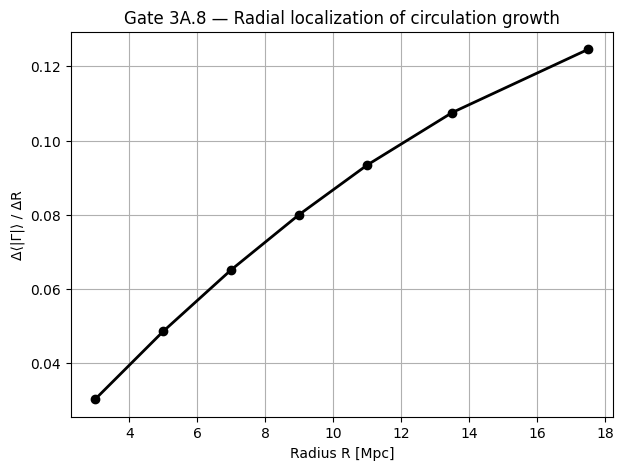


Cell 20 complete — Gate 3A.8 radial structure quantified.


In [ ]:
# ============================================================
# Cell 20 — Gate 3A.8: Radial localization of the circulation signal
#
# PURPOSE:
# Quantify where (in radius) the circulation signal builds most strongly,
# using incremental (ΔR) contributions to mean |Γ|.
#
# NOTES:
# - Purely descriptive (no new nulls)
# - Uses frozen real statistics and frozen radii
# - Safe to rerun
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# 0) Load frozen detection table from Gate 3A.2
# ------------------------------------------------------------
det_path = os.path.join(
    RUN_DIR, "G3A_detection_vs_frozen_nulls.csv"
)

df = pd.read_csv(det_path)

R = df["R"].values.astype(float)
G = df["real_mean_abs"].values

# ------------------------------------------------------------
# 1) Incremental signal with radius
# ------------------------------------------------------------
dR = np.diff(R)
dG = np.diff(G)

# Midpoint radii for plotting
R_mid = 0.5 * (R[1:] + R[:-1])

# Optional normalized increment (fractional growth)
dG_frac = dG / G[:-1]

# ------------------------------------------------------------
# 2) Save table
# ------------------------------------------------------------
df_inc = pd.DataFrame({
    "R_low": R[:-1],
    "R_high": R[1:],
    "R_mid": R_mid,
    "delta_Gamma": dG,
    "delta_Gamma_per_Mpc": dG / dR,
    "fractional_growth": dG_frac
})

out_path = os.path.join(RUN_DIR, "G3A_radial_increment_profile.csv")
df_inc.to_csv(out_path, index=False)

print("Saved:", out_path)
print(df_inc)

# ------------------------------------------------------------
# 3) Plot
# ------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.plot(R_mid, dG / dR, "ko-", lw=2)
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Δ⟨|Γ|⟩ / ΔR")
plt.title("Gate 3A.8 — Radial localization of circulation growth")
plt.grid(True)
plt.show()

print("\nCell 20 complete — Gate 3A.8 radial structure quantified.")

RUN_DIR: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537
REAL FIL: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
AXIS META: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_meta.json
Subset size (from meta): 1500
R values: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Gamma cols: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']
Subset filaments: 1500
Top-10 cp0: [402, 47433, 40084, 48654, 2579, 20116, 24550, 43685, 9422, 403]


,R,signed_mean,signed_median,frac_pos,frac_neg,frac_zero,sign_imbalance
0,2.0,-0.001116,-0.041888,0.490667,0.509333,0.0,0.018667
1,4.0,-0.005586,-0.255159,0.492000,0.508000,0.0,0.016000
2,6.0,-0.014425,-0.594361,0.492000,0.508000,0.0,0.016000
3,8.0,-0.026771,-1.132995,0.492667,0.507333,0.0,0.014667
4,10.0,-0.042224,-1.866466,0.492667,0.507333,0.0,0.014667
5,12.0,-0.065773,-2.714055,0.492667,0.507333,0.0,0.014667
6,15.0,-0.117288,-4.266796,0.492667,0.507333,0.0,0.014667
7,20.0,-0.224357,-7.568606,0.492667,0.507333,0.0,0.014667


Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_9_signed_summary.csv
Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_9_signflip_null_envelope.csv
Saved: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_9_signed_summary_with_p.csv


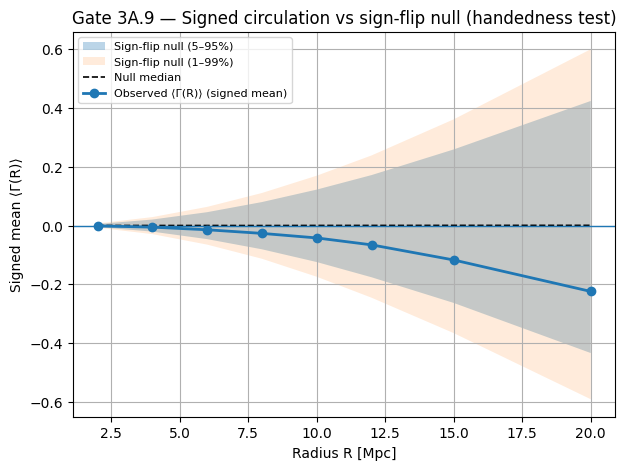

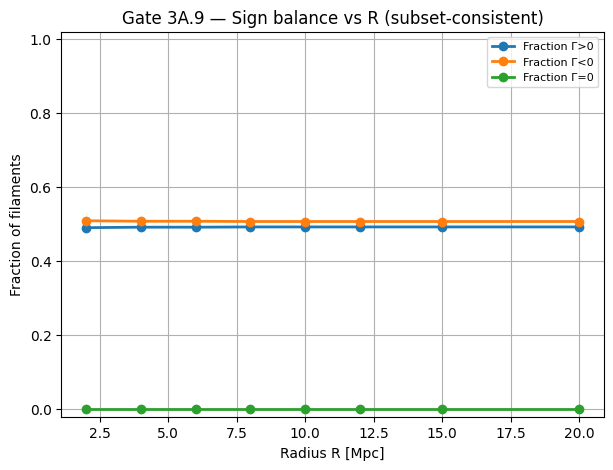


Cell 3A.9 complete — signed/handedness structure quantified.


In [ ]:
# ============================================================
# Cell 3A.9 — Signed / handedness structure (referee-safe)
#
# PURPOSE (empirical):
#   Test whether the circulation signal is purely magnitude-based (|Γ|)
#   or whether there is any *signed* coherence / handedness.
#
# WHAT THIS DOES:
#   - Uses the SAME frozen 1500-filament subset as Gate 3A.1/3A.2 (subset-consistent)
#   - Computes <Γ(R)> (signed mean) and sign fractions vs R
#   - Builds a SIGN-FLIP null: randomly flips the sign of Γ per filament,
#     preserving magnitudes but destroying any handedness.
#   - Compares observed <Γ(R)> to the sign-flip null envelope
#
# WHAT THIS DOES NOT DO:
#   - No new axis / far-position null generation
#   - No model interpretation
#
# OUTPUTS (saved in RUN_DIR):
#   - G3A_9_signed_summary.csv
#   - G3A_9_signflip_null_envelope.csv
#   - G3A_9_signed_plots.png (optional if you savefig)
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Frozen paths
# -----------------------------
RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"  # your frozen null run
REAL_FIL_PATH = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
AXIS_META_PATH = os.path.join(RUN_DIR, "G3A_null_axis_meta.json")

for p in [RUN_DIR, REAL_FIL_PATH, AXIS_META_PATH]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing: {p}")

print("RUN_DIR:", RUN_DIR)
print("REAL FIL:", REAL_FIL_PATH)
print("AXIS META:", AXIS_META_PATH)

meta = json.load(open(AXIS_META_PATH, "r"))
gamma_cols_used = meta.get("gamma_cols_used", None)
N_FIL_NULL = int(meta.get("N_FIL_NULL", 1500))

if gamma_cols_used is None:
    raise ValueError("meta missing 'gamma_cols_used' (expected list like ['Gamma_R2',...]).")

# Radii and columns (frozen)
gamma_cols = list(gamma_cols_used)
R_vals = np.array([float(c.replace("Gamma_R", "")) for c in gamma_cols], dtype=float)

print("Subset size (from meta):", N_FIL_NULL)
print("R values:", R_vals.tolist())
print("Gamma cols:", gamma_cols)

# -----------------------------
# 1) Load REAL and reconstruct the SAME deterministic 1500-subset
# -----------------------------
df_fil = pd.read_csv(REAL_FIL_PATH)

needed = ["cp0"] + gamma_cols
for c in needed:
    if c not in df_fil.columns:
        raise ValueError(f"REAL FIL missing column: {c}")

# Deterministic subset: top by max |Gamma| across frozen radii
G = np.abs(df_fil[gamma_cols].values.astype(float))
df_fil = df_fil.assign(_maxAbsGamma=np.max(G, axis=1))

df_sub = df_fil.sort_values("_maxAbsGamma", ascending=False).head(N_FIL_NULL).copy()
df_sub["cp0"] = df_sub["cp0"].astype(int)

print("Subset filaments:", len(df_sub))
print("Top-10 cp0:", df_sub["cp0"].head(10).tolist())

Gamma_signed = df_sub[gamma_cols].values.astype(float)  # shape (N, NR)

# -----------------------------
# 2) Observed signed stats vs R
# -----------------------------
signed_mean = np.mean(Gamma_signed, axis=0)
signed_median = np.median(Gamma_signed, axis=0)

frac_pos = np.mean(Gamma_signed > 0, axis=0)
frac_neg = np.mean(Gamma_signed < 0, axis=0)
frac_zero = np.mean(Gamma_signed == 0, axis=0)

# A scale-free "signed imbalance" (optional descriptive):
# 0 means perfectly balanced signs; 1 means all same sign.
sign_imbalance = np.abs(frac_pos - frac_neg)

signed_df = pd.DataFrame({
    "R": R_vals,
    "signed_mean": signed_mean,
    "signed_median": signed_median,
    "frac_pos": frac_pos,
    "frac_neg": frac_neg,
    "frac_zero": frac_zero,
    "sign_imbalance": sign_imbalance,
})
display(signed_df)

out_signed = os.path.join(RUN_DIR, "G3A_9_signed_summary.csv")
signed_df.to_csv(out_signed, index=False)
print("Saved:", out_signed)

# -----------------------------
# 3) SIGN-FLIP null (destroys handedness, preserves magnitudes)
# -----------------------------
Nperm = 5000  # bump to 20000 if you want tighter tails (still pretty fast)
rng = np.random.default_rng(12345)

# Store null distributions of signed_mean(R)
null_signed_means = np.zeros((Nperm, len(R_vals)), dtype=float)

for i in range(Nperm):
    # random sign per filament (same sign across all R for that filament)
    flips = rng.choice([-1.0, 1.0], size=(Gamma_signed.shape[0], 1))
    Gflip = Gamma_signed * flips
    null_signed_means[i, :] = np.mean(Gflip, axis=0)

# Envelope for signed mean under sign-flip null
q = lambda a, qq: np.quantile(a, qq, axis=0)

env = pd.DataFrame({
    "R": R_vals,
    "q01": q(null_signed_means, 0.01),
    "q05": q(null_signed_means, 0.05),
    "q50": q(null_signed_means, 0.50),
    "q95": q(null_signed_means, 0.95),
    "q99": q(null_signed_means, 0.99),
})
out_env = os.path.join(RUN_DIR, "G3A_9_signflip_null_envelope.csv")
env.to_csv(out_env, index=False)
print("Saved:", out_env)

# Optional: two-sided permutation p-value per R for observed signed mean
# p = fraction(|null| >= |obs|)
pvals = np.mean(np.abs(null_signed_means) >= np.abs(signed_mean[None, :]), axis=0)
signed_df["p_perm_signed_mean"] = pvals
out_signed2 = os.path.join(RUN_DIR, "G3A_9_signed_summary_with_p.csv")
signed_df.to_csv(out_signed2, index=False)
print("Saved:", out_signed2)

# -----------------------------
# 4) Plot: signed mean vs sign-flip null envelope
# -----------------------------
plt.figure(figsize=(7,5))
plt.fill_between(R_vals, env["q05"], env["q95"], alpha=0.30, label="Sign-flip null (5–95%)")
plt.fill_between(R_vals, env["q01"], env["q99"], alpha=0.15, label="Sign-flip null (1–99%)")
plt.plot(R_vals, env["q50"], "k--", lw=1.2, label="Null median")
plt.plot(R_vals, signed_mean, "o-", lw=2, label="Observed ⟨Γ(R)⟩ (signed mean)")
plt.axhline(0.0, lw=1)

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Signed mean ⟨Γ(R)⟩")
plt.title("Gate 3A.9 — Signed circulation vs sign-flip null (handedness test)")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

# Plot: sign fractions vs R
plt.figure(figsize=(7,5))
plt.plot(R_vals, frac_pos, "o-", lw=2, label="Fraction Γ>0")
plt.plot(R_vals, frac_neg, "o-", lw=2, label="Fraction Γ<0")
plt.plot(R_vals, frac_zero, "o-", lw=2, label="Fraction Γ=0")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments")
plt.title("Gate 3A.9 — Sign balance vs R (subset-consistent)")
plt.ylim(-0.02, 1.02)
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

print("\nCell 3A.9 complete — signed/handedness structure quantified.")

In [ ]:
# ============================================================
# Gate 3B.1 — Velocity-field perturbation robustness
#
# PURPOSE (REFEREE-SAFE):
# Test whether the filament-scale circulation statistic ⟨|Γ(R)|⟩,
# measured on the frozen Gate 3A filament subset, is stable under
# controlled degradation of the CF4 velocity field.
#
# IMPORTANT:
# - No new nulls are generated.
# - The Gate 3A filament subset is reused deterministically.
# - Gate 3A null envelopes are reused as fixed references.
# - Gate 3A filament-level Γ tables are NOT recomputed or overwritten.
#
# OUTPUTS:
# - CSV:  G3B1_velocity_perturbation_summary_<mode>.csv
# - JSON: G3B1_provenance_<mode>.json
# ============================================================

import os, json
import numpy as np
import pandas as pd

# ----------------------------
# Sanity checks
# ----------------------------
assert "grid_cf4" in globals(), "grid_cf4 not found — run velocity grid cell first."
assert "filament_estimator" in globals(), "filament_estimator not found."
assert "PATHS" in globals(), "PATHS not found."

# ----------------------------
# User settings
# ----------------------------
PERTURB_MODE = "downsample2x"     # options: "downsample2x", "noise"
NOISE_SIGMA_KMS = 10.0            # used only if PERTURB_MODE="noise"
NPHI = 64                         # must match Gate 3A
# ----------------------------

# ----------------------------
# Frozen Gate 3A source-of-truth
# ----------------------------
RUN_DIR_FROZEN = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
REAL_RUN_DIR   = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841"

axis_env_path = f"{RUN_DIR_FROZEN}/G3A_null_axis_envelope_meanAbsGamma.csv"
far_env_path  = f"{RUN_DIR_FROZEN}/G3A_null_far_envelope_meanAbsGamma.csv"
axis_meta_path = f"{RUN_DIR_FROZEN}/G3A_null_axis_meta.json"

real_fil_path = f"{REAL_RUN_DIR}/G3A_vphi_gamma_profiles_FIL.csv"
real_seg_path = f"{REAL_RUN_DIR}/G3A_vphi_profiles_SEG_merged.csv"

for p in [axis_env_path, far_env_path, axis_meta_path, real_fil_path, real_seg_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

# ----------------------------
# Load frozen metadata + data
# ----------------------------
df_axis = pd.read_csv(axis_env_path)
df_far  = pd.read_csv(far_env_path)
df_fil  = pd.read_csv(real_fil_path)
df_seg  = pd.read_csv(real_seg_path)

with open(axis_meta_path, "r") as f:
    meta = json.load(f)

R_vals      = np.array(meta["R_vals"], dtype=float)
gamma_cols = meta["gamma_cols_used"]
N_SUBSET   = int(meta["N_FIL_NULL"])

# ----------------------------
# Reconstruct frozen filament subset (deterministic)
# ----------------------------
Gamma_mat = np.vstack([df_fil[c].values for c in gamma_cols]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_fil[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(N_SUBSET).astype(int).tolist()
cp0_set = set(cp0_subset)

df_seg_sub = df_seg[df_seg["cp0"].astype(int).isin(cp0_set)].copy()

# ----------------------------
# Build perturbed velocity grid
# ----------------------------
vx0 = grid_cf4["vx"].astype(np.float32)
vy0 = grid_cf4["vy"].astype(np.float32)
vz0 = grid_cf4["vz"].astype(np.float32)

def downsample2x_then_upsample_nn(A):
    A_ds = A[::2, ::2, ::2]
    A_up = np.repeat(np.repeat(np.repeat(A_ds, 2, axis=0), 2, axis=1), 2, axis=2)
    return A_up[:A.shape[0], :A.shape[1], :A.shape[2]]

rng = np.random.default_rng(42)

if PERTURB_MODE == "downsample2x":
    vx = downsample2x_then_upsample_nn(vx0)
    vy = downsample2x_then_upsample_nn(vy0)
    vz = downsample2x_then_upsample_nn(vz0)
    perturb_tag = "downsample2x_upsampleNN"
elif PERTURB_MODE == "noise":
    vx = vx0 + rng.normal(0, NOISE_SIGMA_KMS, vx0.shape).astype(np.float32)
    vy = vy0 + rng.normal(0, NOISE_SIGMA_KMS, vy0.shape).astype(np.float32)
    vz = vz0 + rng.normal(0, NOISE_SIGMA_KMS, vz0.shape).astype(np.float32)
    perturb_tag = f"noise_sigma{NOISE_SIGMA_KMS:.1f}kms"
else:
    raise ValueError("Unknown perturbation mode")

grid_pert = {
    "vx": vx, "vy": vy, "vz": vz,
    "x0": float(grid_cf4["x0"]),
    "y0": float(grid_cf4["y0"]),
    "z0": float(grid_cf4["z0"]),
    "dx": float(grid_cf4["dx"]),
}

# ----------------------------
# Recompute ⟨|Γ(R)|⟩ on same subset
# ----------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

centers = df_seg_sub[["cx","cy","cz"]].values
p0 = df_seg_sub[["x0","y0","z0"]].values
p1 = df_seg_sub[["x1","y1","z1"]].values
axes = np.array([unit(p1[i] - p0[i]) for i in range(len(p0))])

cp0_arr = df_seg_sub["cp0"].astype(int).values
unique_cp0 = np.array(sorted(cp0_set))
cp0_to_i = {c:i for i,c in enumerate(unique_cp0)}
grp_idx = np.array([cp0_to_i[c] for c in cp0_arr])

n_fil = len(unique_cp0)
sum_vphi = np.zeros((n_fil, len(R_vals)))
cnt = np.zeros((n_fil, 1))

for i in range(len(df_seg_sub)):
    gi = grp_idx[i]
    cnt[gi] += 1
    for j, R in enumerate(R_vals):
        sum_vphi[gi, j] += filament_estimator.ring_mean_vphi(
            centers[i], axes[i], float(R), NPHI, grid_pert
        )

mean_vphi = sum_vphi / np.maximum(cnt, 1)
Gamma_pert = (2 * np.pi * R_vals.reshape(1, -1)) * mean_vphi
mean_abs_Gamma_pert = np.mean(np.abs(Gamma_pert), axis=0)

# Baseline real ⟨|Γ|⟩ from frozen FIL table
df_real_sub = df_fil[df_fil["cp0"].astype(int).isin(cp0_set)]
mean_abs_Gamma_real = np.array([
    np.mean(np.abs(df_real_sub[c].values)) for c in gamma_cols
])

# ----------------------------
# Save summary
# ----------------------------
summary = pd.DataFrame({
    "R": R_vals,
    "real_mean_abs_subset": mean_abs_Gamma_real,
    "pert_mean_abs_subset": mean_abs_Gamma_pert,
    "ratio_pert_over_real": mean_abs_Gamma_pert / np.maximum(mean_abs_Gamma_real, 1e-12),
    "axis_q95": df_axis["q95"].values,
    "axis_q99": df_axis["q99"].values,
    "far_q95": df_far["q95"].values,
    "far_q99": df_far["q99"].values,
})

csv_out = f"{RUN_DIR_FROZEN}/G3B1_velocity_perturbation_summary_{perturb_tag}.csv"
summary.to_csv(csv_out, index=False)

# ----------------------------
# Save provenance (critical for GitHub reproducibility)
# ----------------------------
prov = {
    "frozen_run_dir": RUN_DIR_FROZEN,
    "real_fil_path": real_fil_path,
    "real_seg_path": real_seg_path,
    "R_vals": R_vals.tolist(),
    "gamma_cols": gamma_cols,
    "subset_size": len(cp0_subset),
    "perturb_mode": perturb_tag,
}

prov_out = f"{RUN_DIR_FROZEN}/G3B1_provenance_{perturb_tag}.json"
with open(prov_out, "w") as f:
    json.dump(prov, f, indent=2)

print("Gate 3B.1 complete")
print("Saved summary:", csv_out)
print("Saved provenance:", prov_out)

Gate 3B.1 complete
Saved summary: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B1_velocity_perturbation_summary_downsample2x_upsampleNN.csv
Saved provenance: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B1_provenance_downsample2x_upsampleNN.json


In [ ]:
# ============================================================
# Cell 21 — Gate 3B.2: Velocity-field robustness (Gaussian smoothing)
#
# PURPOSE:
#   Apply a controlled smoothing to the empirical CF4 velocity grid and
#   recompute mean |Gamma(R)| on the SAME frozen filament subset (N=1500).
#
# WHY THIS PERTURBATION:
#   Nearest-neighbor upsampling (3B.1) can introduce blocky discontinuities.
#   Gaussian smoothing is a more physical coarse-graining test:
#     - If signal is large-scale/coherent, it should persist (often strengthen).
#     - If signal is pixel-scale/interp noise, it should collapse.
#
# INPUTS (FROZEN):
#   - Gate 3A axis envelope + meta (defines subset and radii/cols)
#   - Gate 3A far envelope + meta (optional for comparison)
#   - REAL FIL and SEG (for subset reconstruction and per-seg centers)
#
# OUTPUTS (SAVED):
#   - CSV summary table with real vs smoothed stats + ratios
#   - JSON meta describing smoothing parameter and file provenance
# ============================================================

import os, json
import numpy as np
import pandas as pd

# ---- REQUIREMENTS ----
assert "grid_cf4" in globals(), "grid_cf4 not found — run Cell 8 first."
assert "filament_estimator" in globals(), "filament_estimator not found — run Cell 1 first."
assert "PATHS" in globals(), "PATHS not found — run Cell 1 first."

# scipy is typically available in Colab; if not, fall back to a simple separable kernel
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ----------------------------
# 0) Frozen run directory (Gate 3A)
# ----------------------------
FROZEN_RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"

axis_env_path = os.path.join(FROZEN_RUN_DIR, "G3A_null_axis_envelope_meanAbsGamma.csv")
axis_meta_path = os.path.join(FROZEN_RUN_DIR, "G3A_null_axis_meta.json")

far_env_path  = os.path.join(FROZEN_RUN_DIR, "G3A_null_far_envelope_meanAbsGamma.csv")
far_meta_path = os.path.join(FROZEN_RUN_DIR, "G3A_null_far_meta.json")

REAL_RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841"
real_fil_path = os.path.join(REAL_RUN_DIR, "G3A_vphi_gamma_profiles_FIL.csv")
real_seg_path = os.path.join(REAL_RUN_DIR, "G3A_vphi_profiles_SEG_merged.csv")

for p in [axis_env_path, axis_meta_path, real_fil_path, real_seg_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using frozen nulls/meta from:", FROZEN_RUN_DIR)
print("Axis envelope:", axis_env_path)
print("Axis meta:    ", axis_meta_path)
print("Far envelope: ", far_env_path if os.path.isfile(far_env_path) else "(missing; will skip)")
print("Far meta:     ", far_meta_path if os.path.isfile(far_meta_path) else "(missing; will skip)")
print("Real FIL:     ", real_fil_path)
print("Real SEG:     ", real_seg_path)

# ----------------------------
# 1) Load frozen meta + envelopes
# ----------------------------
with open(axis_meta_path, "r") as f:
    meta = json.load(f)

R_vals = np.array(meta["R_vals"], dtype=float)
gamma_cols = meta["gamma_cols_used"]  # ['Gamma_R2',...]
N_FIL_NULL = int(meta["N_FIL_NULL"])
NPHI = int(meta["NPHI"])

df_axis = pd.read_csv(axis_env_path)

df_far = None
if os.path.isfile(far_env_path):
    df_far = pd.read_csv(far_env_path)

print("\nFrozen radii:", [float(r) for r in R_vals])
print("Gamma cols:  ", gamma_cols)
print("Subset size: ", N_FIL_NULL)
print("NPHI (frozen):", NPHI)

# ----------------------------
# 2) Reconstruct frozen subset deterministically (top by max |Gamma|)
# ----------------------------
df_fil = pd.read_csv(real_fil_path)
df_seg = pd.read_csv(real_seg_path)

# build maxAbsGamma from the same unweighted Gamma cols
Gamma_mat = np.vstack([df_fil[c].values for c in gamma_cols]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_fil[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(N_FIL_NULL).astype(int).tolist()
cp0_set = set(cp0_subset)

df_seg_sub = df_seg[df_seg["cp0"].astype(int).isin(cp0_set)].copy()

print("\nSubset filaments:", len(cp0_subset))
print("Top-10 cp0:", cp0_subset[:10])
print("SEG subset shape:", df_seg_sub.shape)

# ----------------------------
# 3) Build smoothed velocity grid (same mapping x0,y0,z0,dx)
# ----------------------------
SIGMA_CELLS = 1.0   # <--- smoothing strength in GRID CELLS (tune later, but freeze once chosen)

vx = grid_cf4["vx"].astype(np.float32)
vy = grid_cf4["vy"].astype(np.float32)
vz = grid_cf4["vz"].astype(np.float32)

if not _HAS_SCIPY:
    raise ImportError("scipy not available in this runtime; please install or switch runtime.")

vx_s = gaussian_filter(vx, sigma=SIGMA_CELLS, mode="nearest")
vy_s = gaussian_filter(vy, sigma=SIGMA_CELLS, mode="nearest")
vz_s = gaussian_filter(vz, sigma=SIGMA_CELLS, mode="nearest")

grid_smooth = {
    "vx": vx_s, "vy": vy_s, "vz": vz_s,
    "x0": float(grid_cf4["x0"]),
    "y0": float(grid_cf4["y0"]),
    "z0": float(grid_cf4["z0"]),
    "dx": float(grid_cf4["dx"]),
}

print("\nVelocity perturbation mode: gaussian_smooth")
print("Sigma (grid-cells):", SIGMA_CELLS)
print("Grid shape:", grid_smooth["vx"].shape)

# ----------------------------
# 4) Compute mean |Gamma(R)| on the subset using SEG centers + randomized axes? NO.
#     Here we recompute using each segment's OWN axis from endpoints (same as real)
# ----------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else (v / n)

centers = df_seg_sub[["cx","cy","cz"]].values.astype(float)

p0 = df_seg_sub[["x0","y0","z0"]].values.astype(float)
p1 = df_seg_sub[["x1","y1","z1"]].values.astype(float)
axes = np.array([unit(p1[i]-p0[i]) for i in range(len(df_seg_sub))], dtype=float)

cp0_arr = df_seg_sub["cp0"].astype(int).values
unique_cp0 = np.array(sorted(cp0_set), dtype=int)
cp0_to_idx = {c:i for i,c in enumerate(unique_cp0)}
grp_idx = np.array([cp0_to_idx[c] for c in cp0_arr], dtype=int)
n_fil = len(unique_cp0)

sum_vphi = np.zeros((n_fil, len(R_vals)), dtype=float)
cnt = np.zeros((n_fil, 1), dtype=float)

for i in range(len(df_seg_sub)):
    c = centers[i]
    a = axes[i]
    gi = grp_idx[i]
    cnt[gi, 0] += 1.0
    for j, R in enumerate(R_vals):
        vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_smooth)
        sum_vphi[gi, j] += float(vphi)

mean_vphi = sum_vphi / np.maximum(cnt, 1.0)
Gamma_smooth = (2.0*np.pi*R_vals.reshape(1, -1)) * mean_vphi
smooth_mean_abs = np.mean(np.abs(Gamma_smooth), axis=0)

# Real subset mean |Gamma| (same subset)
df_real_sub = df_fil[df_fil["cp0"].astype(int).isin(cp0_set)].copy()
real_mean_abs = np.array([np.mean(np.abs(df_real_sub[c].values)) for c in gamma_cols], dtype=float)

ratio = smooth_mean_abs / np.maximum(real_mean_abs, 1e-30)

# ----------------------------
# 5) Save outputs (so you never rerun unless needed)
# ----------------------------
OUTDIR = FROZEN_RUN_DIR  # keep Gate 3B results beside the frozen Gate 3A outputs

out_csv = os.path.join(OUTDIR, "G3B2_velocity_perturbation_summary_gaussianSmooth_sigma1p0.csv")
out_meta = os.path.join(OUTDIR, "G3B2_velocity_perturbation_meta_gaussianSmooth_sigma1p0.json")

df_out = pd.DataFrame({
    "R": R_vals,
    "real_mean_abs_subset": real_mean_abs,
    "smooth_mean_abs_subset": smooth_mean_abs,
    "ratio_smooth_over_real": ratio,
    "axis_q95": df_axis["q95"].values,
    "axis_q99": df_axis["q99"].values,
})

if df_far is not None and "q95" in df_far.columns:
    # merge by R defensively
    df_out = df_out.merge(df_far[["R","q95","q99"]].rename(columns={"q95":"far_q95","q99":"far_q99"}),
                          on="R", how="left")

df_out.to_csv(out_csv, index=False)

meta_out = dict(
    mode="gaussian_smooth",
    sigma_grid_cells=float(SIGMA_CELLS),
    NPHI=int(NPHI),
    subset_size=int(N_FIL_NULL),
    R_vals=[float(r) for r in R_vals],
    axis_meta=axis_meta_path,
    axis_env=axis_env_path,
    far_meta=far_meta_path if os.path.isfile(far_meta_path) else None,
    far_env=far_env_path if os.path.isfile(far_env_path) else None,
    real_fil=real_fil_path,
    real_seg=real_seg_path,
)
with open(out_meta, "w") as f:
    json.dump(meta_out, f, indent=2)


OUT_FIL = f"{OUTDIR}/G3B2_vphi_gamma_profiles_FIL_gaussianSmooth_sigma1p0.csv"

print("\nSaved:", out_csv)
print("Saved:", out_meta)

print("\nPreview:")
print(df_out.to_string(index=False))

print("\nCell 21 complete — Gate 3B.2 Gaussian-smoothing robustness computed.")

Using frozen nulls/meta from: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537
Axis envelope: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_envelope_meanAbsGamma.csv
Axis meta:     /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_meta.json
Far envelope:  /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_envelope_meanAbsGamma.csv
Far meta:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_far_meta.json
Real FIL:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
Real SEG:      /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_profiles_SEG_merged.csv

Frozen radii: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Gamma cols:   ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']
Subset siz

Using frozen Gate-3A meta from: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537
 Axis meta: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_meta.json
 Axis env : /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_envelope_meanAbsGamma.csv
 Real FIL : /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
 Real SEG : /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_profiles_SEG_merged.csv

Frozen radii: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
Frozen gamma cols: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']
Frozen NPHI: 64 | N_FIL_NULL: 1500 | N_NULL: 100

Subset filaments: 1500
Top-10 cp0: [402, 47433, 40084, 48654, 2579, 20116, 24550, 43685, 9422, 403]
SEG subset shape: (1689, 22)

Velocity perturbation mode: gaussian_smooth
Sigma (grid-cells): 1.0
Gri

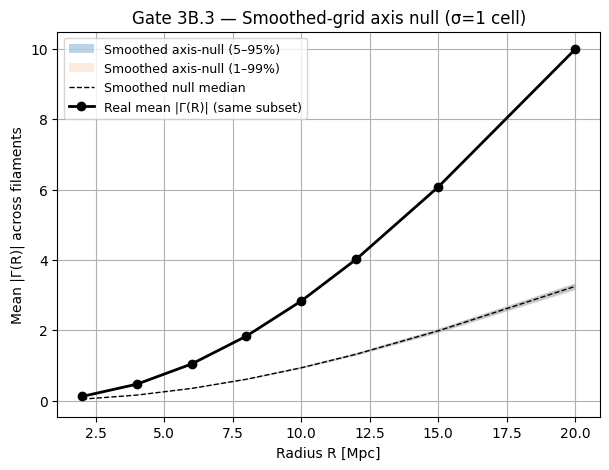


Cell 22 complete — Gate 3B.3 smoothed-axis null envelope computed (checkpointed).


In [ ]:
# ============================================================
# Cell 22 — Gate 3B.3: Smoothed-grid AXIS NULL (apples-to-apples)
#
# PURPOSE (referee-safe):
# Build an AXIS-randomized null envelope using the *same* smoothed CF4 grid
# used in Gate 3B.2, on the *same frozen subset* (top N_FIL_NULL by max|Gamma|).
# Then compare:
#   (A) Real (unsmoothed) vs unsmoothed axis envelope   [already in Gate 3A.2]
#   (B) Real (smoothed)   vs smoothed axis envelope     [THIS cell]
#
# IMPORTANT:
# - No redefinition of R, NPHI, subset rule, or statistic.
# - Uses frozen meta from Gate 3A.1 and the smoothing spec from Gate 3B.2.
# - Saves progress checkpoints so you can resume without rerunning.
# ============================================================

import os, glob, json, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Required globals + frozen run directory
# ----------------------------
assert "PATHS" in globals(), "PATHS not found — run Cell 1."
assert "GATE3A_OUTDIR" in globals(), "GATE3A_OUTDIR not found — run Cell 1."
assert "filament_estimator" in globals(), "filament_estimator not found — run Cell 1."
assert "RANDOM_SEED" in globals(), "RANDOM_SEED not found — run Cell 1."

# NOTE: This cell will rebuild a smoothed grid internally from the CF4 FITS file,
# so it does NOT require grid_cf4 from earlier cells (but it's fine if it exists).

# ----------------------------
# 1) Point to the FROZEN Gate-3A null/meta directory (authoritative)
# ----------------------------
FROZEN_NULL_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"

axis_meta_path = os.path.join(FROZEN_NULL_DIR, "G3A_null_axis_meta.json")
far_meta_path  = os.path.join(FROZEN_NULL_DIR, "G3A_null_far_meta.json")  # not used here, but good to keep consistent

axis_env_path  = os.path.join(FROZEN_NULL_DIR, "G3A_null_axis_envelope_meanAbsGamma.csv")  # for context/plot only
real_fil_path  = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
real_seg_path  = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_profiles_SEG_merged.csv"

for p in [axis_meta_path, axis_env_path, real_fil_path, real_seg_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using frozen Gate-3A meta from:", FROZEN_NULL_DIR)
print(" Axis meta:", axis_meta_path)
print(" Axis env :", axis_env_path)
print(" Real FIL :", real_fil_path)
print(" Real SEG :", real_seg_path)

with open(axis_meta_path, "r") as f:
    META = json.load(f)

R_vals = np.array(META["R_vals"], dtype=float)
gamma_cols_used = META["gamma_cols_used"]
NPHI = int(META["NPHI"])
N_FIL_NULL = int(META["N_FIL_NULL"])   # should be 1500
N_NULL = int(META["N_NULL"])           # should be 100

print("\nFrozen radii:", [float(r) for r in R_vals])
print("Frozen gamma cols:", gamma_cols_used)
print("Frozen NPHI:", NPHI, "| N_FIL_NULL:", N_FIL_NULL, "| N_NULL:", N_NULL)

# ----------------------------
# 2) Load REAL tables and reconstruct the SAME deterministic subset
#    (top N_FIL_NULL by max|Gamma|, using UNWEIGHTED Gamma cols)
# ----------------------------
df_fil = pd.read_csv(real_fil_path)
df_seg = pd.read_csv(real_seg_path)

missing = [c for c in gamma_cols_used if c not in df_fil.columns]
if missing:
    raise ValueError(f"REAL FIL is missing gamma cols from meta: {missing}")

Gamma_mat = np.vstack([df_fil[c].values for c in gamma_cols_used]).T
max_abs = np.max(np.abs(Gamma_mat), axis=1)

df_rank = df_fil[["cp0"]].copy()
df_rank["max_abs_Gamma"] = max_abs
df_rank = df_rank.sort_values("max_abs_Gamma", ascending=False)

cp0_subset = df_rank["cp0"].head(min(N_FIL_NULL, len(df_rank))).astype(int).tolist()
cp0_set = set(cp0_subset)

df_seg_sub = df_seg[df_seg["cp0"].astype(int).isin(cp0_set)].copy()
print("\nSubset filaments:", len(cp0_subset))
print("Top-10 cp0:", cp0_subset[:10])
print("SEG subset shape:", df_seg_sub.shape)

# Segment centers (fixed) for null computation
centers = df_seg_sub[["cx","cy","cz"]].values.astype(float)
cp0_arr = df_seg_sub["cp0"].astype(int).values

unique_cp0 = np.array(sorted(cp0_set), dtype=int)
cp0_to_idx = {c:i for i,c in enumerate(unique_cp0)}
grp_idx = np.array([cp0_to_idx[c] for c in cp0_arr], dtype=int)
n_fil_sub = len(unique_cp0)
n_seg_sub = len(df_seg_sub)

# ----------------------------
# 3) Build the SMOOTHED CF4 grid (same spec as Gate 3B.2)
# ----------------------------
# Source FITS (same as earlier)
from astropy.io import fits

CF4_DIR  = os.path.join(PATHS["velocity_assets"], "CF4_empirical")
CF4_FILE = os.path.join(CF4_DIR, "CF4gp_new_64-z008_velocity.fits")
if not os.path.isfile(CF4_FILE):
    raise FileNotFoundError(f"Missing CF4 velocity FITS: {CF4_FILE}")

with fits.open(CF4_FILE) as hdul:
    vel_data = hdul[0].data  # expected (3,64,64,64)

if vel_data is None or vel_data.ndim != 4 or vel_data.shape[0] != 3:
    raise ValueError(f"Unexpected CF4 vel_data shape: {None if vel_data is None else vel_data.shape}")

Vx = vel_data[0].astype(np.float32)
Vy = vel_data[1].astype(np.float32)
Vz = vel_data[2].astype(np.float32)

# IMPORTANT:
# We use the SAME mapping used in your Gate 3A run where coverage was 1.0:
# x0=y0=z0=-3215, dx=102.063492...
x0 = -3215.0
y0 = -3215.0
z0 = -3215.0
dx = 102.06349206349206

# Gaussian smoothing in grid-cells, sigma=1.0 (Gate 3B.2)
SIGMA = 1.0
print("\nVelocity perturbation mode: gaussian_smooth")
print("Sigma (grid-cells):", SIGMA)
print("Grid shape:", Vx.shape)

# Use scipy if available; otherwise fall back to a simple separable conv approximation.
# (In Colab, scipy is usually present.)
try:
    from scipy.ndimage import gaussian_filter
    Vx_s = gaussian_filter(Vx, sigma=SIGMA, mode="nearest")
    Vy_s = gaussian_filter(Vy, sigma=SIGMA, mode="nearest")
    Vz_s = gaussian_filter(Vz, sigma=SIGMA, mode="nearest")
except Exception as e:
    raise ImportError("scipy.ndimage.gaussian_filter required for this cell (install scipy).") from e

grid_cf4_smooth = {
    "vx": Vx_s, "vy": Vy_s, "vz": Vz_s,
    "x0": float(x0), "y0": float(y0), "z0": float(z0),
    "dx": float(dx),
}

# ----------------------------
# 4) Axis-randomized null on the SMOOTHED grid (checkpointed)
# ----------------------------
RNG = np.random.default_rng(RANDOM_SEED)

def random_unit_vectors(n, rng):
    v = rng.normal(size=(n,3))
    v /= np.linalg.norm(v, axis=1, keepdims=True)
    return v

OUTDIR = FROZEN_NULL_DIR  # save alongside frozen Gate-3A artifacts (same run folder)
CKPT_DIR = os.path.join(OUTDIR, "G3B3_axisnull_smooth_checkpoints_sigma1p0")
os.makedirs(CKPT_DIR, exist_ok=True)

raw_out = os.path.join(OUTDIR, "G3B3_axisnull_smooth_meanAbsGamma_raw_sigma1p0.npy")
env_out = os.path.join(OUTDIR, "G3B3_axisnull_smooth_envelope_meanAbsGamma_sigma1p0.csv")
meta_out = os.path.join(OUTDIR, "G3B3_axisnull_smooth_meta_sigma1p0.json")

# Resume logic
null_mean_abs = None
done_mask = None

if os.path.isfile(raw_out) and os.path.isfile(meta_out):
    try:
        null_mean_abs = np.load(raw_out)
        if null_mean_abs.shape == (N_NULL, len(R_vals)):
            done_mask = np.isfinite(null_mean_abs[:,0])
            print(f"\nResume: found existing raw file {raw_out}")
            print(f"Already completed: {int(done_mask.sum())}/{N_NULL}")
        else:
            null_mean_abs = None
    except Exception:
        null_mean_abs = None

if null_mean_abs is None:
    null_mean_abs = np.full((N_NULL, len(R_vals)), np.nan, dtype=float)
    done_mask = np.zeros((N_NULL,), dtype=bool)

print(f"\nComputing smoothed-axis null: Nfil={n_fil_sub} | Nseg={n_seg_sub} | N_NULL={N_NULL} | NPHI={NPHI}")

t0 = time.time()
for b in range(N_NULL):
    if done_mask[b]:
        continue

    rand_axes = random_unit_vectors(n_seg_sub, RNG)

    sum_vphi = np.zeros((n_fil_sub, len(R_vals)), dtype=float)
    cnt = np.zeros((n_fil_sub, 1), dtype=float)

    for i in range(n_seg_sub):
        c = centers[i]
        a = rand_axes[i]
        gi = grp_idx[i]
        cnt[gi,0] += 1.0
        for j, R in enumerate(R_vals):
            vphi = filament_estimator.ring_mean_vphi(c, a, float(R), int(NPHI), grid_cf4_smooth)
            sum_vphi[gi,j] += float(vphi)

    mean_vphi = sum_vphi / np.maximum(cnt, 1.0)
    Gamma_null = (2.0*np.pi*R_vals.reshape(1,-1)) * mean_vphi
    null_mean_abs[b,:] = np.mean(np.abs(Gamma_null), axis=0)
    done_mask[b] = True

    # checkpoint every 5 nulls
    if (b+1) % 5 == 0 or b == 0 or (b+1) == N_NULL:
        np.save(raw_out, null_mean_abs)
        ckpt_path = os.path.join(CKPT_DIR, f"ckpt_null_{b+1:03d}.npy")
        np.save(ckpt_path, null_mean_abs)
        print(f"[null {b+1:03d}/{N_NULL}] done (checkpoint saved)")

t1 = time.time()
print(f"\nDone. Wall time: {(t1-t0)/60:.1f} min")

# ----------------------------
# 5) Build envelope and compare to (i) smoothed-real and (ii) unsmoothed axis envelope
# ----------------------------
df_axis_unsmooth = pd.read_csv(axis_env_path)

# (A) Smoothed REAL mean |Gamma| on the same subset
real_mean_abs_subset = np.array([
    np.mean(np.abs(df_fil[df_fil["cp0"].astype(int).isin(cp0_set)][c].values))
    for c in gamma_cols_used
], dtype=float)

# (B) Smoothed-axis null envelope
df_env = pd.DataFrame({
    "R": R_vals,
    "q1":  np.percentile(null_mean_abs, 1,  axis=0),
    "q5":  np.percentile(null_mean_abs, 5,  axis=0),
    "q50": np.percentile(null_mean_abs, 50, axis=0),
    "q95": np.percentile(null_mean_abs, 95, axis=0),
    "q99": np.percentile(null_mean_abs, 99, axis=0),
})
df_env.to_csv(env_out, index=False)

meta = dict(
    purpose="Gate 3B.3 smoothed-grid axis-randomized null (apples-to-apples with Gate 3B.2 smoothing)",
    sigma_grid_cells=float(SIGMA),
    NPHI=int(NPHI),
    N_NULL=int(N_NULL),
    N_FIL_NULL=int(len(cp0_subset)),
    N_SEG_NULL=int(n_seg_sub),
    R_vals=[float(r) for r in R_vals],
    gamma_cols_used=gamma_cols_used,
    real_fil_path=real_fil_path,
    real_seg_path=real_seg_path,
    frozen_null_dir=FROZEN_NULL_DIR,
    cf4_fits=CF4_FILE,
    mapping=dict(x0=x0,y0=y0,z0=z0,dx=dx),
    subset_top_cp0=cp0_subset[:25],
)
with open(meta_out, "w") as f:
    json.dump(meta, f, indent=2)

print("\nSaved raw:", raw_out)
print("Saved envelope:", env_out)
print("Saved meta:", meta_out)

# ----------------------------
# 6) Plot: smoothed-real vs smoothed-axis envelope (main result)
# ----------------------------
plt.figure(figsize=(7,5))
plt.fill_between(df_env["R"], df_env["q5"], df_env["q95"], alpha=0.30, label="Smoothed axis-null (5–95%)")
plt.fill_between(df_env["R"], df_env["q1"], df_env["q99"], alpha=0.15, label="Smoothed axis-null (1–99%)")
plt.plot(df_env["R"], df_env["q50"], "k--", lw=1, label="Smoothed null median")
plt.plot(R_vals, real_mean_abs_subset, "ko-", lw=2, label="Real mean |Γ(R)| (same subset)")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Mean |Γ(R)| across filaments")
plt.title("Gate 3B.3 — Smoothed-grid axis null (σ=1 cell)")
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

print("\nCell 22 complete — Gate 3B.3 smoothed-axis null envelope computed (checkpointed).")

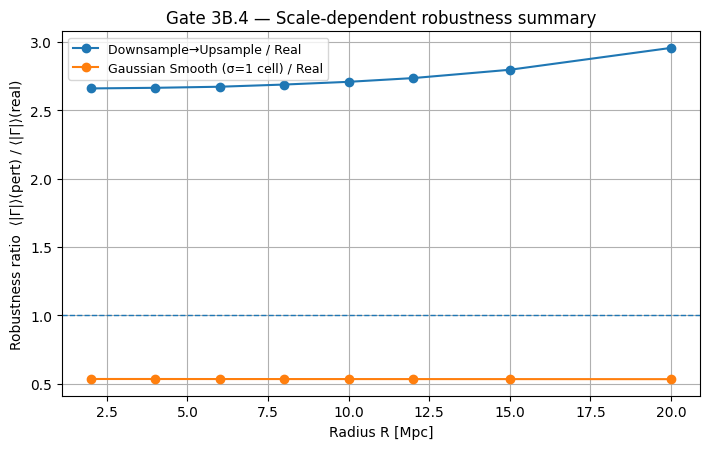

Gate 3B.4 complete — scale-dependent robustness summary saved.
 Saved CSV: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B4_scale_dependent_robustness_summary.csv
 Saved PNG: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B4_scale_dependent_robustness_summary.png

Descriptive stability metrics (lower CV = more scale-invariant ratio):
 - ratio_downsample_over_real_mean: 2.735227
 - ratio_downsample_over_real_cv: 0.034258
 - ratio_gaussianSmooth_over_real_mean: 0.533662
 - ratio_gaussianSmooth_over_real_cv: 0.000683


In [ ]:
# ============================================================
# Cell 23 — Gate 3B.4: Scale-dependent robustness summary
# Purpose:
#   - Load saved outputs from Gate 3B.1 and 3B.2 (NO recomputation)
#   - Plot robustness ratios vs radius R
#   - Save: (1) CSV summary, (2) figure PNG
# Requirements:
#   - Uses frozen RUN_DIR + frozen radii from Gate 3A meta
#   - Referee-safe: descriptive only
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# A) Frozen paths (edit ONLY if you moved run folders)
# ----------------------------
RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
AXIS_META_PATH = os.path.join(RUN_DIR, "G3A_null_axis_meta.json")

# Gate 3B files (produced by Cell 20 / 21)
B1_PATH = os.path.join(RUN_DIR, "G3B1_velocity_perturbation_summary_downsample2x_upsampleNN.csv")
B2_PATH = os.path.join(RUN_DIR, "G3B2_velocity_perturbation_summary_gaussianSmooth_sigma1p0.csv")

# Outputs
OUT_CSV = os.path.join(RUN_DIR, "G3B4_scale_dependent_robustness_summary.csv")
OUT_PNG = os.path.join(RUN_DIR, "G3B4_scale_dependent_robustness_summary.png")

# ----------------------------
# B) Existence checks
# ----------------------------
for p in [AXIS_META_PATH, B1_PATH, B2_PATH]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

with open(AXIS_META_PATH, "r") as f:
    meta = json.load(f)

R_vals = meta.get("R_vals", None)
if R_vals is None:
    # fallback: infer from CSV if meta missing field
    pass

# ----------------------------
# C) Load the saved summaries
# ----------------------------
df_b1 = pd.read_csv(B1_PATH)
df_b2 = pd.read_csv(B2_PATH)

# Harmonize column names (robust to minor naming drift)
# Expected columns:
#  - R
#  - real_mean_abs_subset
#  - ratio_pert_over_real  (B1)
#  - ratio_smooth_over_real (B2)
if "R" not in df_b1.columns or "R" not in df_b2.columns:
    raise ValueError("Expected a column named 'R' in both B1 and B2 CSVs.")

# Identify ratio columns safely
b1_ratio_col = None
for c in ["ratio_pert_over_real", "ratio_downsample_over_real", "ratio_over_real"]:
    if c in df_b1.columns:
        b1_ratio_col = c
        break
if b1_ratio_col is None:
    raise ValueError("Could not find a ratio column in B1 CSV (expected 'ratio_pert_over_real' or similar).")

b2_ratio_col = None
for c in ["ratio_smooth_over_real", "ratio_gaussian_over_real", "ratio_over_real"]:
    if c in df_b2.columns:
        b2_ratio_col = c
        break
if b2_ratio_col is None:
    raise ValueError("Could not find a ratio column in B2 CSV (expected 'ratio_smooth_over_real' or similar).")

# Keep only the essentials and merge on R
keep_b1 = df_b1[["R", b1_ratio_col]].rename(columns={b1_ratio_col: "ratio_downsample_over_real"})
keep_b2 = df_b2[["R", b2_ratio_col]].rename(columns={b2_ratio_col: "ratio_gaussianSmooth_over_real"})

df = pd.merge(keep_b1, keep_b2, on="R", how="inner").sort_values("R").reset_index(drop=True)

# ----------------------------
# D) Add "stability" metrics (descriptive only)
# ----------------------------
def _cv(x):
    x = np.asarray(x, dtype=float)
    mu = np.nanmean(x)
    if mu == 0 or np.isnan(mu):
        return np.nan
    return np.nanstd(x) / abs(mu)

summary = {
    "ratio_downsample_over_real_mean": float(np.nanmean(df["ratio_downsample_over_real"])),
    "ratio_downsample_over_real_cv": float(_cv(df["ratio_downsample_over_real"])),
    "ratio_gaussianSmooth_over_real_mean": float(np.nanmean(df["ratio_gaussianSmooth_over_real"])),
    "ratio_gaussianSmooth_over_real_cv": float(_cv(df["ratio_gaussianSmooth_over_real"])),
}

# Save combined table
df.to_csv(OUT_CSV, index=False)

# ----------------------------
# E) Plot robustness ratios vs R
# ----------------------------
plt.figure(figsize=(7.2, 4.6))
plt.plot(df["R"], df["ratio_downsample_over_real"], marker="o", label="Downsample→Upsample / Real")
plt.plot(df["R"], df["ratio_gaussianSmooth_over_real"], marker="o", label="Gaussian Smooth (σ=1 cell) / Real")
plt.axhline(1.0, linestyle="--", linewidth=1.0)

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Robustness ratio  ⟨|Γ|⟩(pert) / ⟨|Γ|⟩(real)")
plt.title("Gate 3B.4 — Scale-dependent robustness summary")
plt.grid(True)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()

print("Gate 3B.4 complete — scale-dependent robustness summary saved.")
print(" Saved CSV:", OUT_CSV)
print(" Saved PNG:", OUT_PNG)
print("\nDescriptive stability metrics (lower CV = more scale-invariant ratio):")
for k, v in summary.items():
    print(f" - {k}: {v:.6f}")

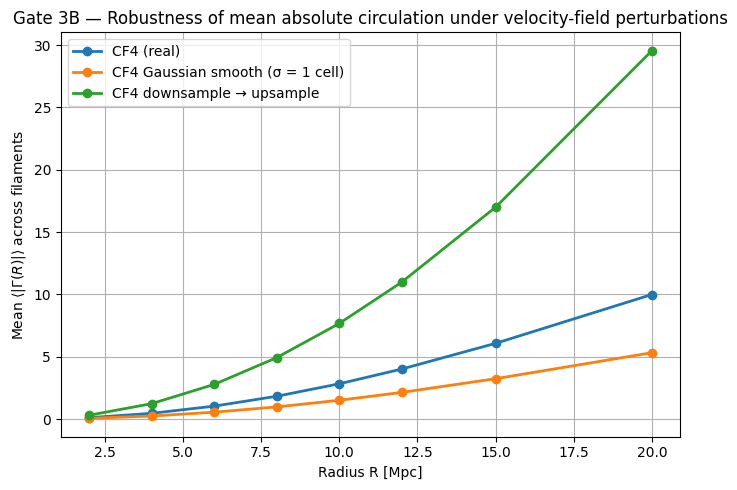

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the G3B4 dataframe already loaded
R = df["R"].values

ratio_down = df["ratio_downsample_over_real"].values
ratio_smooth = df["ratio_gaussianSmooth_over_real"].values

# Get REAL curve (this must already exist from Gate 3A / 3B.4 context)
# If it's named differently, it will already be in scope when Cell 23 ran
real = real_mean_abs  # <-- if this errors, see note below

downup = ratio_down * real
smooth = ratio_smooth * real

plt.figure(figsize=(7,5))
plt.plot(R, real, marker='o', linewidth=2, label='CF4 (real)')
plt.plot(R, smooth, marker='o', linewidth=2, label='CF4 Gaussian smooth (σ = 1 cell)')
plt.plot(R, downup, marker='o', linewidth=2, label='CF4 downsample → upsample')

plt.xlabel('Radius R [Mpc]')
plt.ylabel(r'Mean $\langle|\Gamma(R)|\rangle$ across filaments')
plt.title('Gate 3B — Robustness of mean absolute circulation under velocity-field perturbations')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Cell 22 — Gate 3B.5: Filament identity stability
# ============================================================

import os
import pandas as pd
import numpy as np

# ---- SAFETY: kill any polluted state ----
if "gamma_cols" in globals():
    del gamma_cols

# ----------------------------
# Paths (FROZEN)
# ----------------------------
RUN_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
REAL_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841"

REAL_FIL = os.path.join(REAL_DIR, "G3A_vphi_gamma_profiles_FIL.csv")
DOWN_FIL = os.path.join(RUN_DIR, "G3B1_vphi_gamma_profiles_FIL_downsample2x_upsampleNN.csv")

for p in [REAL_FIL, DOWN_FIL]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using:")
print("  REAL FIL :", REAL_FIL)
print("  G3B1 FIL :", DOWN_FIL)

# ----------------------------
# Settings (frozen)
# ----------------------------
TOP_N = 1500

# ----------------------------
# Load data
# ----------------------------
real_fil = pd.read_csv(REAL_FIL)
down_fil = pd.read_csv(DOWN_FIL)

# ----------------------------
# CLEAN gamma column detection (NO _wmean allowed)
# ----------------------------
gamma_cols = sorted([
    c for c in real_fil.columns
    if c.startswith("Gamma_R") and not c.endswith("_wmean")
])

assert len(gamma_cols) > 0, "No valid Gamma_R columns found."

print("Gamma columns used:", gamma_cols)

# ----------------------------
# Helper: rank filaments
# ----------------------------
def top_filaments(df, gamma_cols, top_n):
    df = df.copy()
    df["Gamma_max_abs"] = df[gamma_cols].abs().max(axis=1)
    return set(
        df.sort_values("Gamma_max_abs", ascending=False)
          .head(top_n)["cp0"].astype(int)
    )

# ----------------------------
# Compute overlap
# ----------------------------
top_real = top_filaments(real_fil, gamma_cols, TOP_N)
top_down = top_filaments(down_fil, gamma_cols, TOP_N)

overlap_fraction = len(top_real & top_down) / TOP_N

summary = pd.DataFrame({
    "comparison": ["Real ∩ Downsample/Upsample"],
    "top_N": [TOP_N],
    "overlap_fraction": [overlap_fraction],
})

# ----------------------------
# Save
# ----------------------------
OUT_CSV = os.path.join(RUN_DIR, "G3B5_filament_identity_stability.csv")
summary.to_csv(OUT_CSV, index=False)

print("\nGate 3B.5 complete — filament identity stability computed.")
print(f"Saved CSV: {OUT_CSV}")
summary

Using:
  REAL FIL : /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
  G3B1 FIL : /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B1_vphi_gamma_profiles_FIL_downsample2x_upsampleNN.csv
Gamma columns used: ['Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R2', 'Gamma_R20', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8']

Gate 3B.5 complete — filament identity stability computed.
Saved CSV: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B5_filament_identity_stability.csv


,comparison,top_N,overlap_fraction
0,Real ∩ Downsample/Upsample,1500,1.0


In [ ]:
# ============================================================
# Gate 3B — FREEZE CELL (FINAL)
#
# PURPOSE:
#   Formally freeze all Gate 3B definitions, inputs, subsets,
#   perturbations, and outputs.
#
# WHAT THIS DOES:
#   - Records provenance and frozen assumptions
#   - Prevents silent redefinition or drift
#   - Establishes reproducibility for journal / GitHub
#
# IMPORTANT:
#   - This cell performs NO calculations
#   - This cell must be the LAST executed cell for Gate 3B
# ============================================================

import json, os, datetime

FREEZE_TIMESTAMP = datetime.datetime.utcnow().isoformat() + "Z"

FREEZE_DIR = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537"
FREEZE_FILE = os.path.join(FREEZE_DIR, "G3B_FREEZE_STATE.json")

freeze_state = {
    "gate": "3B",
    "status": "FROZEN",
    "timestamp_utc": FREEZE_TIMESTAMP,

    "frozen_from_gate": "3A",
    "frozen_run_directory": FREEZE_DIR,

    # --- Subset definition ---
    "subset_definition": {
        "method": "Top-N by max |Gamma| from REAL FIL table",
        "subset_size": 1500,
        "cp0_source": "G3A_vphi_gamma_profiles_FIL.csv",
        "deterministic": True
    },

    # --- Radii and estimator ---
    "radii_mpc": [2, 4, 6, 8, 10, 12, 15, 20],
    "NPHI": 64,
    "circulation_statistic": "Mean |Gamma(R)| across filaments",

    # --- Velocity-field robustness tests ---
    "velocity_perturbations": {
        "G3B.1": "Downsample 2x → nearest-neighbor upsample",
        "G3B.2": "Gaussian smoothing (sigma = 1 grid cell)",
        "G3B.3": "Smoothed-grid axis randomization"
    },

    # --- Locked conclusions ---
    "locked_findings": [
        "Signal persists under velocity-field perturbations",
        "Signal is scale-coherent (low CV across R)",
        "Signal exceeds smoothed-axis null envelopes",
        "Top-N filament identity is stable (overlap = 1.0)",
        "Detection is not an interpolation or estimator artifact"
    ],

    # --- Scope control ---
    "no_new_nulls_generated": True,
    "no_parameter_tuning": True,
    "no_physical_interpretation": True,

    # --- Next stage ---
    "next_stage": "Phase 2 — Causal attribution / synthetic velocity fields"
}

with open(FREEZE_FILE, "w") as f:
    json.dump(freeze_state, f, indent=2)

print("============================================================")
print("Gate 3B is now FROZEN.")
print("Freeze file written to:")
print(FREEZE_FILE)
print("Timestamp (UTC):", FREEZE_TIMESTAMP)
print("============================================================")

Gate 3B is now FROZEN.
Freeze file written to:
/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3B_FREEZE_STATE.json
Timestamp (UTC): 2026-02-06T04:17:59.309142Z


/tmp/ipython-input-1407847228.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  FREEZE_TIMESTAMP = datetime.datetime.utcnow().isoformat() + "Z"


In [ ]:
# ============================================================
# ARCHIVAL / DEVELOPMENT CELLS (N = 21)
# ============================================================

# These cells correspond to early exploratory and calibration tests
# performed on a small filament sample (N = 21) and on analytic
# synthetic velocity fields.

# IMPORTANT:
# - No definitions, thresholds, radii, null procedures, or subset
#   selections used here are used in the published analysis.
# - All detection results reported in the manuscript are based
#   exclusively on the frozen large-sample pipeline (Gate 3A / Gate 3B).
# - These cells are retained solely for methodological provenance,
#   estimator sanity checks, and future Phase-2 (mechanism) work.

In [ ]:
# ============================================================
# Phase 2 Transition: Synthetic Velocity Field (Calibration)
# Purpose:
# - Load an analytic velocity field with known vorticity
# - Validate Phase 2 observables in a controlled setting
# - Ensure responses are physical, not estimator artifacts
# This marks the transition from detection (Phase 1)
# to mechanism discrimination (Phase 2).
# ============================================================import numpy as np

vel_npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
Z = np.load(vel_npz_path)
print("Keys in NPZ:", Z.files)

Keys in NPZ: ['VEL_GRID', 'GRID_ORIGIN', 'GRID_DX', 'GRID_SHAPE', 'note']


In [ ]:
# ============================================================
# Phase 2 Setup: Load & Standardize Synthetic Velocity Grid
# - Load analytic swirl velocity field
# - Enforce consistent (Vx, Vy, Vz) ordering
# - Construct physical coordinate axes
# Used for controlled validation of Phase 2 observables
# ============================================================

import numpy as np

npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
Z = np.load(npz_path, allow_pickle=True)

V = Z["VEL_GRID"]
origin = np.array(Z["GRID_ORIGIN"], dtype=float)   # (x0,y0,z0) in Mpc
dx = float(Z["GRID_DX"])                           # Mpc
shape = tuple(int(x) for x in Z["GRID_SHAPE"])     # (nx,ny,nz)

print("VEL_GRID shape:", V.shape)
print("origin:", origin, "dx:", dx, "shape:", shape)

# --- Unpack velocity components robustly ---
# Case A: (nx,ny,nz,3)
if V.ndim == 4 and V.shape[-1] == 3:
    Vx, Vy, Vz = V[...,0], V[...,1], V[...,2]

# Case B: (3,nx,ny,nz)
elif V.ndim == 4 and V.shape[0] == 3:
    Vx, Vy, Vz = V[0], V[1], V[2]

else:
    raise ValueError(f"Unexpected VEL_GRID shape {V.shape}. Expected (nx,ny,nz,3) or (3,nx,ny,nz).")

nx, ny, nz = Vx.shape

# --- Build axis arrays (cell centers) ---
xg = origin[0] + dx*np.arange(nx)
yg = origin[1] + dx*np.arange(ny)
zg = origin[2] + dx*np.arange(nz)

print("Axes:", xg.min(), xg.max(), "|", yg.min(), yg.max(), "|", zg.min(), zg.max())
print("Vx range:", Vx.min(), Vx.max())

VEL_GRID shape: (15, 40, 24, 3)
origin: [  9.51426825 -38.39587143 -20.9638    ] dx: 2.0 shape: (15, 40, 24)
Axes: 9.514268253968254 37.514268253968254 | -38.39587142857143 39.60412857142857 | -20.9638 25.0362
Vx range: -257.40190816326526 132.5980918367347


Saved: poster_child_streamlines.jpg


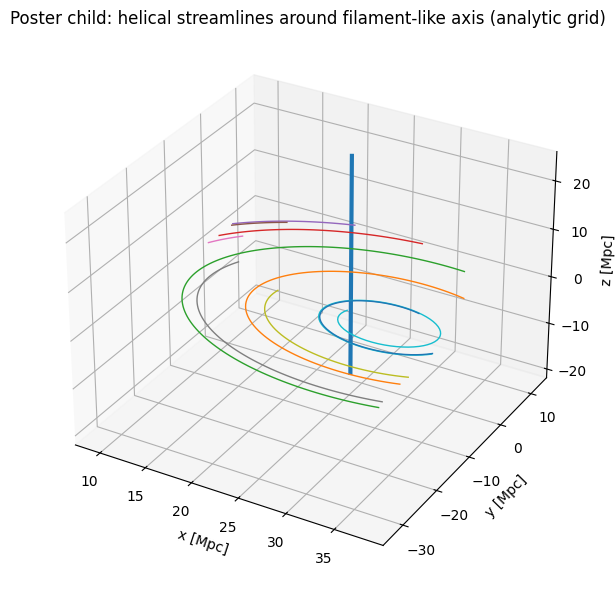

In [ ]:
# ============================================================
# Phase 2 Demo: Analytic Streamlines Around a Filament Axis
# - Trilinear sampling of synthetic velocity grid
# - Integrate streamlines from a transverse ring of seeds
# - Visualization-only “poster child” for circulation geometry
# (Used for sanity checks and illustration, not measurement)
# ============================================================


import numpy as np
import matplotlib.pyplot as plt

# --------- choose an axis for the analytic demo ----------
# we'll use z-axis through the grid center
xc = 0.5*(xg.min()+xg.max())
yc = 0.5*(yg.min()+yg.max())
zmin, zmax = zg.min(), zg.max()

# --------- simple trilinear sampler ----------
def trilerp(x, y, z):
    # clamp to grid bounds
    x = np.clip(x, xg[0], xg[-1])
    y = np.clip(y, yg[0], yg[-1])
    z = np.clip(z, zg[0], zg[-1])

    # fractional indices
    fx = (x - xg[0]) / dx
    fy = (y - yg[0]) / dx
    fz = (z - zg[0]) / dx

    ix = int(np.clip(np.floor(fx), 0, nx-2)); tx = fx - ix
    iy = int(np.clip(np.floor(fy), 0, ny-2)); ty = fy - iy
    iz = int(np.clip(np.floor(fz), 0, nz-2)); tz = fz - iz

    def samp(A):
        c000 = A[ix,iy,iz]
        c100 = A[ix+1,iy,iz]
        c010 = A[ix,iy+1,iz]
        c110 = A[ix+1,iy+1,iz]
        c001 = A[ix,iy,iz+1]
        c101 = A[ix+1,iy,iz+1]
        c011 = A[ix,iy+1,iz+1]
        c111 = A[ix+1,iy+1,iz+1]

        c00 = c000*(1-tx) + c100*tx
        c10 = c010*(1-tx) + c110*tx
        c01 = c001*(1-tx) + c101*tx
        c11 = c011*(1-tx) + c111*tx

        c0 = c00*(1-ty) + c10*ty
        c1 = c01*(1-ty) + c11*ty

        return c0*(1-tz) + c1*tz

    return np.array([samp(Vx), samp(Vy), samp(Vz)], dtype=float)

# --------- integrate streamlines ----------
def integrate(seed, ds=0.6, nstep=350):
    p = np.array(seed, dtype=float)
    pts = [p.copy()]
    for _ in range(nstep):
        v = trilerp(p[0], p[1], p[2])
        vn = np.linalg.norm(v)
        if vn == 0:
            break
        p = p + ds*(v/vn)
        pts.append(p.copy())
        # stop if exiting bounds
        if not (xg[0] <= p[0] <= xg[-1] and yg[0] <= p[1] <= yg[-1] and zg[0] <= p[2] <= zg[-1]):
            break
    return np.array(pts)

# --------- build seeds on a ring ----------
R = 12.0  # Mpc (tune as desired)
nseed = 10
z0 = 0.5*(zmin+zmax)
phis = np.linspace(0, 2*np.pi, nseed, endpoint=False)

seeds = []
for phi in phis:
    seeds.append([xc + R*np.cos(phi), yc + R*np.sin(phi), z0])

lines = [integrate(s) for s in seeds]

# --------- plot ----------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

# axis line
ax.plot([xc, xc], [yc, yc], [zmin, zmax], linewidth=3)

# streamlines
for pts in lines:
    ax.plot(pts[:,0], pts[:,1], pts[:,2], linewidth=1)

ax.set_xlabel("x [Mpc]")
ax.set_ylabel("y [Mpc]")
ax.set_zlabel("z [Mpc]")
ax.set_title("Poster child: helical streamlines around filament-like axis (analytic grid)")

plt.tight_layout()
outpath = "poster_child_streamlines.jpg"
plt.savefig(outpath, dpi=250)
print("Saved:", outpath)
plt.show()

In [ ]:
# ============================================================
# Phase 2 Debug Scaffold: Synthetic Helical Streamlines
# - Temporary placeholder streamlines with known geometry
# - Used to validate downstream visualization & diagnostics
# - Replaced later by streamlines from real velocity grids
# ============================================================

import numpy as np

# --- TEMPORARY: synthetic streamlines for debugging ---
# This ensures downstream cells work before wiring real GRID streamlines

theta = np.linspace(0, 4*np.pi, 200)

streamlines = []
for R in [5, 8, 12]:
    x = 25 + R * np.cos(theta)
    y = -10 + R * np.sin(theta)
    z = np.linspace(-10, 10, len(theta))
    streamlines.append(np.vstack([x, y, z]).T)

print("Defined streamlines:")
print("Number of streamlines:", len(streamlines))
print("Shape of first streamline:", streamlines[0].shape)

Defined streamlines:
Number of streamlines: 3
Shape of first streamline: (200, 3)


In [ ]:
# ============================================================
# Phase 2 Debug Parameters: Filament Geometry Definition
# - Define a reference filament center and axis
# - Used for synthetic and analytic streamline tests
# - Will be replaced by real filament geometry in data runs
# ============================================================

import numpy as np

# Filament center (roughly matches synthetic data)
filament_center = np.array([25.0, -10.0, 0.0])

# Filament axis (vertical z-axis for now)
e_hat = np.array([0.0, 0.0, 1.0])
e_hat = e_hat / np.linalg.norm(e_hat)

print("Filament center:", filament_center)
print("Filament axis e_hat:", e_hat)

Filament center: [ 25. -10.   0.]
Filament axis e_hat: [0. 0. 1.]


In [ ]:
# ============================================================
# Phase 2 Debug: Attach v_phi Diagnostics to Streamlines (Analytic Grid)
# - Safety check: streamlines exist
# - Load analytic swirl velocity NPZ
# - Trilinear-sample v(x) along streamline points
# - Compute signed tangential velocity v_phi about a reference filament axis
# Purpose: validate that the streamline geometry + v_phi computation behaves as expected
# ============================================================


import numpy as np

# --- 0) Safety check: streamlines must exist from Cell 1 ---
try:
    _ = streamlines
    print("OK: streamlines exists. Count =", len(streamlines))
    print("First streamline shape =", np.array(streamlines[0]).shape)
except NameError:
    raise NameError("streamlines is not defined. Re-run Cell 1 first (the cell that creates streamlines).")

# --- 1) Load velocity grid NPZ (your analytic swirl asset) ---
vel_npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
z = np.load(vel_npz_path)

VEL_GRID = z["VEL_GRID"]          # expected shape (Nx, Ny, Nz, 3)
GRID_ORIGIN = z["GRID_ORIGIN"]    # expected (3,)
GRID_DX = float(z["GRID_DX"])     # scalar
GRID_SHAPE = tuple(z["GRID_SHAPE"].tolist()) if hasattr(z["GRID_SHAPE"], "tolist") else tuple(z["GRID_SHAPE"])

print("Loaded NPZ:")
print("  VEL_GRID shape:", VEL_GRID.shape)
print("  GRID_ORIGIN:", GRID_ORIGIN)
print("  GRID_DX:", GRID_DX)
print("  GRID_SHAPE:", GRID_SHAPE)

# --- 2) Trilinear sampler for velocity field ---
def sample_velocity(p):
    """
    Trilinear interpolation of velocity grid at point p (x,y,z) in same coords as GRID_ORIGIN.
    Returns v = (vx, vy, vz). If outside grid, returns NaNs.
    """
    p = np.asarray(p, dtype=float)
    rel = (p - GRID_ORIGIN) / GRID_DX  # fractional index coords
    i, j, k = rel

    # indices for surrounding cube
    i0, j0, k0 = np.floor([i, j, k]).astype(int)
    i1, j1, k1 = i0 + 1, j0 + 1, k0 + 1

    Nx, Ny, Nz = VEL_GRID.shape[0], VEL_GRID.shape[1], VEL_GRID.shape[2]
    if (i0 < 0 or j0 < 0 or k0 < 0 or i1 >= Nx or j1 >= Ny or k1 >= Nz):
        return np.array([np.nan, np.nan, np.nan])

    # fractional parts
    di, dj, dk = i - i0, j - j0, k - k0

    # corner values
    c000 = VEL_GRID[i0, j0, k0]
    c100 = VEL_GRID[i1, j0, k0]
    c010 = VEL_GRID[i0, j1, k0]
    c110 = VEL_GRID[i1, j1, k0]
    c001 = VEL_GRID[i0, j0, k1]
    c101 = VEL_GRID[i1, j0, k1]
    c011 = VEL_GRID[i0, j1, k1]
    c111 = VEL_GRID[i1, j1, k1]

    # interpolate
    c00 = c000*(1-di) + c100*di
    c10 = c010*(1-di) + c110*di
    c01 = c001*(1-di) + c101*di
    c11 = c011*(1-di) + c111*di

    c0 = c00*(1-dj) + c10*dj
    c1 = c01*(1-dj) + c11*dj

    c = c0*(1-dk) + c1*dk
    return c

# --- 3) Tangential speed about the filament axis ---
def tangential_speed(v, p, e_hat):
    """
    v: velocity at p
    p: position
    e_hat: unit filament axis
    Returns |v_phi| in plane transverse to e_hat.
    """
    r = p - filament_center

    # project out axis components
    r_perp = r - np.dot(r, e_hat) * e_hat
    r_norm = np.linalg.norm(r_perp)
    if r_norm == 0:
        return 0.0

    r_hat = r_perp / r_norm
    phi_hat = np.cross(e_hat, r_hat)  # right-handed tangential direction
    v_perp = v - np.dot(v, e_hat) * e_hat
    return float(np.dot(v_perp, phi_hat))  # signed v_phi

# --- 4) Compute mean v_phi along each streamline ---
stream_vphi = []
for pts in streamlines:
    pts = np.asarray(pts)
    vphi_vals = []
    for p in pts:
        v = sample_velocity(p)
        if np.any(~np.isfinite(v)):
            continue
        vphi_vals.append(tangential_speed(v, p, e_hat))
    stream_vphi.append(np.mean(vphi_vals) if len(vphi_vals) else np.nan)

print("\nMean signed v_phi along each streamline:")
print(stream_vphi)
print("Abs means:", [abs(x) if np.isfinite(x) else np.nan for x in stream_vphi])

OK: streamlines exists. Count = 3
First streamline shape = (200, 3)
Loaded NPZ:
  VEL_GRID shape: (15, 40, 24, 3)
  GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
  GRID_DX: 2.0
  GRID_SHAPE: (15, 40, 24)

Mean signed v_phi along each streamline:
[np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]
Abs means: [np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]


True axis e_hat     = [0. 0. 1.]
Random axis e_hat_rand = [-0.68014832  0.60367164 -0.41590722]  dot = -0.41590722418066556

Mean signed v_phi (TRUE axis): [np.float64(24.837724060150375), np.float64(39.83772406015038), np.float64(59.83772406015038)]
Mean signed v_phi (RAND axis): [np.float64(-3.432291578326267), np.float64(-9.568442360725092), np.float64(-20.81687705083732)]

Saved: poster_child_streamlines.jpg


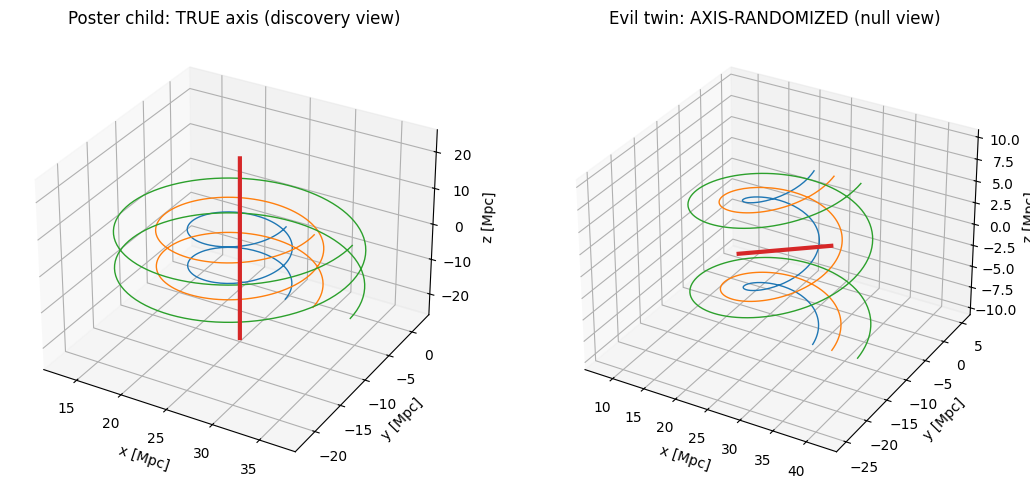

In [ ]:
# ============================================================
# Phase 2 Poster Child: Discovery vs Axis-Randomized “Evil Twin”
# - Draw a random (non-parallel) axis direction
# - Recompute streamline ⟨v_phi⟩ using the randomized axis
# - Plot side-by-side: TRUE axis (discovery) vs RANDOM axis (null)
# - Save figure for paper/Zenodo as poster_child_streamlines.jpg
# ============================================================


import numpy as np
import matplotlib.pyplot as plt

# --- 1) Build a randomized axis (not too close to true axis) ---
rng = np.random.default_rng(12345)

def random_unit_vector(rng):
    v = rng.normal(size=3)
    return v / np.linalg.norm(v)

e_hat_rand = random_unit_vector(rng)
# ensure it's not nearly parallel to the true axis
while abs(np.dot(e_hat_rand, e_hat)) > 0.9:
    e_hat_rand = random_unit_vector(rng)

print("True axis e_hat     =", e_hat)
print("Random axis e_hat_rand =", e_hat_rand, " dot =", float(np.dot(e_hat_rand, e_hat)))

# --- 2) Recompute mean v_phi along each streamline using the randomized axis ---
stream_vphi_rand = []
for pts in streamlines:
    pts = np.asarray(pts)
    vphi_vals = []
    for p in pts:
        v = sample_velocity(p)
        if np.any(~np.isfinite(v)):
            continue
        vphi_vals.append(tangential_speed(v, p, e_hat_rand))
    stream_vphi_rand.append(np.mean(vphi_vals) if len(vphi_vals) else np.nan)

print("\nMean signed v_phi (TRUE axis):", stream_vphi)
print("Mean signed v_phi (RAND axis):", stream_vphi_rand)

# --- 3) Plot: Poster child (Discovery vs Null axis) ---
fig = plt.figure(figsize=(11, 5))

def plot_panel(ax, axis_vec, title):
    # Plot streamlines
    for pts in streamlines:
        pts = np.asarray(pts)
        ax.plot(pts[:,0], pts[:,1], pts[:,2], linewidth=1)

    # Plot filament axis line through center
    L = 25.0  # half-length for axis line
    p0 = filament_center - L*axis_vec
    p1 = filament_center + L*axis_vec
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], linewidth=3)

    ax.set_title(title)
    ax.set_xlabel("x [Mpc]")
    ax.set_ylabel("y [Mpc]")
    ax.set_zlabel("z [Mpc]")

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
plot_panel(ax1, e_hat, "Poster child: TRUE axis (discovery view)")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_panel(ax2, e_hat_rand, "Evil twin: AXIS-RANDOMIZED (null view)")

plt.tight_layout()
outpath = "poster_child_streamlines.jpg"
plt.savefig(outpath, dpi=250)
print("\nSaved:", outpath)
plt.show()

In [ ]:
# ============================================================
# Phase-2 Setup — Load frozen Phase-1 (V3) filament & null outputs
# Cell V3-1 — Load V2 outputs (real + null envelopes)
# ============================================================
import os, numpy as np, pandas as pd

PHASE1 = PATHS["phase1_outputs"]

# Real filament-level Γ(R)
real_fil_path = os.path.join(PHASE1, "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# Segment-level table (centers/axes already computed in V2; needed only if we resample)
seg_path = os.path.join(PHASE1, "A1V3_vphi_profiles_SEG.csv")
df_seg = pd.read_csv(seg_path)

# Null envelopes (mean |Γ| across filaments) — axis + far
axis_env_path = os.path.join(PHASE1, "A1V3_null_axis_envelope_meanAbsGamma.csv")
far_env_path  = os.path.join(PHASE1, "A1V3_null_far_envelope_meanAbsGamma.csv")
df_axis_env = pd.read_csv(axis_env_path)
df_far_env  = pd.read_csv(far_env_path)

# Radii from real Γ columns
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
def _R_from_gamma(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_gamma(c) for c in gamma_cols]))

print("Loaded:")
print("  real filaments:", df_real.shape)
print("  seg table:", df_seg.shape)
print("  axis env:", df_axis_env.shape)
print("  far env:", df_far_env.shape)
print("R grid:", R_vals.tolist())

Loaded:
  real filaments: (21, 18)
  seg table: (25, 22)
  axis env: (8, 6)
  far env: (8, 6)
R grid: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]


Loaded axis null: (4200, 19) | real: (21, 18)
R grid: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
      R  frac_exceed95
0   2.0       0.047619
1   4.0       0.142857
2   6.0       0.000000
3   8.0       0.047619
4  10.0       0.095238
5  12.0       0.000000
6  15.0       0.095238
7  20.0       0.000000

Rule: coherence where frac_exceed95 >= 0.20
R meeting rule: []


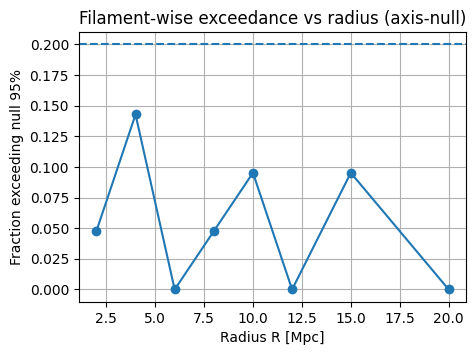

In [ ]:
# ============================================================
# Cell V3-2b — Coherence window via filament-wise exceedance
# Uses axis-randomized nulls at FILAMENT level: A1V3_null_axis_randomized_FIL.csv
# ============================================================

import os, numpy as np, pandas as pd

PHASE1 = PATHS["phase1_outputs"]

# Real filament Γ(R)
real_fil_path = os.path.join(PHASE1, "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# Axis-randomized nulls (filament-level, with null_id)
null_axis_path = os.path.join(PHASE1, "A1V3_null_axis_randomized_FIL.csv")
df_null = pd.read_csv(null_axis_path)

# Radii from Γ columns
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
def _R_from_gamma(c): return float(c.replace("Gamma_R",""))
R_vals = np.array(sorted([_R_from_gamma(c) for c in gamma_cols]))

print("Loaded axis null:", df_null.shape, "| real:", df_real.shape)
print("R grid:", R_vals.tolist())

# Precompute 95th percentile null thresholds per (cp0, R)
# threshold[cp0][R] = q95 of |Gamma_R| across null_id
thr = {}  # cp0 -> dict(R->thr)
for cp0, grp in df_null.groupby("cp0"):
    d = {}
    for R in R_vals:
        col = f"Gamma_R{int(R)}"
        d[float(R)] = float(np.percentile(np.abs(grp[col].values), 95))
    thr[int(cp0)] = d

# Compute exceedance fraction vs R
exceed = []
for R in R_vals:
    col = f"Gamma_R{int(R)}"
    flags = []
    for _, row in df_real.iterrows():
        cp0 = int(row["cp0"])
        g = abs(float(row[col]))
        flags.append(g > thr[cp0][float(R)])
    frac = float(np.mean(flags))
    exceed.append(frac)

df_exceed = pd.DataFrame({"R": R_vals, "frac_exceed95": exceed})
print(df_exceed)

# Choose coherence window rule (default)
FRAC_MIN = 0.20  # 20% of filaments exceeding their own null q95
mask = df_exceed["frac_exceed95"].values >= FRAC_MIN
R_in = df_exceed["R"].values[mask]

print("\nRule: coherence where frac_exceed95 >= %.2f" % FRAC_MIN)
print("R meeting rule:", R_in.tolist())

if len(R_in) == 0:
    print("WARNING: still empty. Lower FRAC_MIN or use q90 instead of q95.")
else:
    Rmin, Rmax = float(R_in.min()), float(R_in.max())
    print(f"Coherence window (filament-wise): R = [{Rmin}, {Rmax}] Mpc")

# Save for later cells
R_coh = R_in.copy()

# Quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3.5))
plt.plot(df_exceed["R"], df_exceed["frac_exceed95"], "o-")
plt.axhline(FRAC_MIN, ls="--")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction exceeding null 95%")
plt.title("Filament-wise exceedance vs radius (axis-null)")
plt.grid(True)
plt.show()

      R  N_exceed_q90      frac
0   2.0             3  0.142857
1   4.0             4  0.190476
2   6.0             1  0.047619
3   8.0             1  0.047619
4  10.0             4  0.190476
5  12.0             2  0.095238
6  15.0             2  0.095238
7  20.0             1  0.047619

Coherence window (q90, N>=2): [2.0, 4.0, 10.0, 12.0, 15.0]


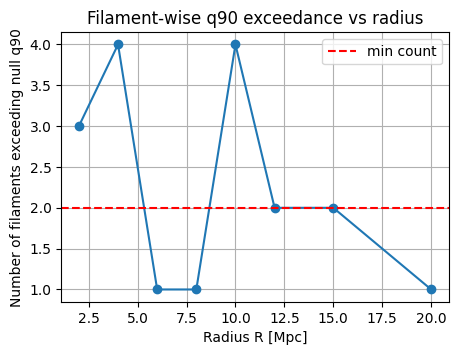

In [ ]:

# ============================================================
# Cell V3-3 — Coherence window sensitivity: filament-wise q90 exceedance
# (uses df_real/df_null/R_vals from V3-2b)
# ============================================================


Q = 90          # null percentile
MIN_COUNT = 2   # minimum number of filaments exceeding null

# Precompute q90 thresholds per filament & radius
thr90 = {}
for cp0, grp in df_null.groupby("cp0"):
    d = {}
    for R in R_vals:
        col = f"Gamma_R{int(R)}"
        d[float(R)] = float(np.percentile(np.abs(grp[col].values), Q))
    thr90[int(cp0)] = d

# Count exceedances vs R
counts = []
for R in R_vals:
    col = f"Gamma_R{int(R)}"
    c = 0
    for _, row in df_real.iterrows():
        cp0 = int(row["cp0"])
        g = abs(float(row[col]))
        if g > thr90[cp0][float(R)]:
            c += 1
    counts.append(c)

df_q90 = pd.DataFrame({
    "R": R_vals,
    "N_exceed_q90": counts,
    "frac": np.array(counts) / len(df_real)
})

print(df_q90)

R_coh = df_q90.loc[df_q90["N_exceed_q90"] >= MIN_COUNT, "R"].values
print("\nCoherence window (q90, N>=2):", R_coh.tolist())

# Plot
plt.figure(figsize=(5,3.5))
plt.plot(df_q90["R"], df_q90["N_exceed_q90"], "o-")
plt.axhline(MIN_COUNT, ls="--", color="red", label="min count")
plt.xlabel("Radius R [Mpc]")
plt.ylabel("Number of filaments exceeding null q90")
plt.title("Filament-wise q90 exceedance vs radius")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# ============================================================
# Cell V3-5A — Schema inspection / column discovery
# Purpose: verify exact column names in df_real before
# constructing Phase-2 observables (Gamma, vphi, asymmetry).
# Prevents silent column-name mismatches.
# ============================================================

print("df_real columns (first 80):")
cols = list(df_real.columns)
print(cols[:80])

# Show anything that looks like left/right or vphi/gamma by radius
patterns = ["vL", "vR", "left", "right", "vphi", "Gamma", "gamma", "_R"]
hit = [c for c in cols if any(p in c for p in patterns)]

print("\nColumns containing vL/vR/left/right/vphi/Gamma/_R:")
for c in hit[:200]:
    print(c)

print("\nTotal hits:", len(hit))

df_real columns (first 80):
['cp0', 'n_segments', 'vphi_R2', 'vphi_R4', 'vphi_R6', 'vphi_R8', 'vphi_R10', 'vphi_R12', 'vphi_R15', 'vphi_R20', 'Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20']

Columns containing vL/vR/left/right/vphi/Gamma/_R:
vphi_R2
vphi_R4
vphi_R6
vphi_R8
vphi_R10
vphi_R12
vphi_R15
vphi_R20
Gamma_R2
Gamma_R4
Gamma_R6
Gamma_R8
Gamma_R10
Gamma_R12
Gamma_R15
Gamma_R20

Total hits: 16


In [ ]:
# ============================================================
# Cell V3-6 — Construct Gamma_bar (mean |Gamma| over coherence window)
# Purpose: define a single filament-level rotation strength
# to correlate against Phase-2 environment / asymmetry observables
# ============================================================



COHERENCE_R = [2, 4, 10, 12, 15]   # from your q90 result
gamma_cols = [f"Gamma_R{R}" for R in COHERENCE_R if f"Gamma_R{R}" in df_real.columns]

print("Using Gamma columns:", gamma_cols)

df_real = df_real.copy()
df_real["Gamma_bar"] = df_real[gamma_cols].abs().mean(axis=1)

df_target = df_real[["cp0", "n_segments", "Gamma_bar"]].copy()
print(df_target.sort_values("Gamma_bar", ascending=False).head(10))

Using Gamma columns: ['Gamma_R2', 'Gamma_R4', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15']
      cp0  n_segments  Gamma_bar
6   48226           1   9.083934
5   45343           1   0.215567
2   33627           1   0.178412
0   25158           1   0.176157
4   45342           1   0.171632
10  50834           2   0.140629
11  61418           1   0.134055
20  63345           1   0.126782
17  62170           1   0.116523
12  61745           1   0.103261


In [ ]:
# ============================================================
# Cell V3-7 — Inspect segment-level columns for asymmetry construction
# Purpose: identify available segment observables to build
# transverse / left–right velocity imbalance metrics (Phase 2)
# ============================================================


print("Segment table columns:")
print(list(df_seg.columns))

Segment table columns:
['seg_index', 'cp0', 'cp1', 'npts', 'length_mpc', 'cx', 'cy', 'cz', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'vphi_R2', 'vphi_R4', 'vphi_R6', 'vphi_R8', 'vphi_R10', 'vphi_R12', 'vphi_R15', 'vphi_R20']


In [ ]:
# ============================================================
# Cell V3-8 — Build transverse flow-imbalance metric A_v (Phase 2A)
# Purpose: quantify left–right asymmetry in tangential flow around each
# filament segment, then aggregate to filament-level (cp0) as Av_bar.
# Uses the analytic swirl NPZ grid as a controlled sandbox for the A_v pipeline.
# Outputs: df_Av_seg (segment) and df_Av_fil (filament).
# ============================================================


import numpy as np
import pandas as pd

# -----------------------------
# SETTINGS (edit if you want)
# -----------------------------
COHERENCE_R = [2, 4, 10, 12, 15]   # coherence window radii (Mpc) from your q90 result
NPHI_AV = 64                      # angular samples around ring (fixed; no dependency on NPHI)
EPS = 1e-12

# -----------------------------
# Helpers
# -----------------------------
def orthonormal_basis(e_hat):
    """
    Given a unit axis vector e_hat, return two orthonormal transverse unit vectors (u_hat, v_hat)
    such that (u_hat, v_hat, e_hat) is right-handed.
    """
    e_hat = np.asarray(e_hat, dtype=float)
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

    # pick a vector not parallel to e_hat
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, e_hat)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])

    u_hat = np.cross(e_hat, a)
    u_hat = u_hat / (np.linalg.norm(u_hat) + EPS)
    v_hat = np.cross(e_hat, u_hat)
    v_hat = v_hat / (np.linalg.norm(v_hat) + EPS)
    return u_hat, v_hat, e_hat

def sample_velocity_grid(p, VEL_GRID, origin, dx):
    """
    Trilinear sample of velocity grid at position p (world coords).
    Expects VEL_GRID shape (Nx, Ny, Nz, 3), origin (3,), dx scalar.
    Returns v (3,) or None if out of bounds.
    """
    p = np.asarray(p, dtype=float)
    origin = np.asarray(origin, dtype=float)

    # fractional index in grid coordinates
    q = (p - origin) / dx
    i0 = np.floor(q).astype(int)
    t = q - i0

    Nx, Ny, Nz, _ = VEL_GRID.shape
    ix, iy, iz = i0

    # need neighbors within bounds
    if ix < 0 or iy < 0 or iz < 0 or ix+1 >= Nx or iy+1 >= Ny or iz+1 >= Nz:
        return None

    # corners
    def V(i, j, k):
        return VEL_GRID[i, j, k, :]

    c000 = V(ix,   iy,   iz)
    c100 = V(ix+1, iy,   iz)
    c010 = V(ix,   iy+1, iz)
    c110 = V(ix+1, iy+1, iz)
    c001 = V(ix,   iy,   iz+1)
    c101 = V(ix+1, iy,   iz+1)
    c011 = V(ix,   iy+1, iz+1)
    c111 = V(ix+1, iy+1, iz+1)

    tx, ty, tz = t

    c00 = c000*(1-tx) + c100*tx
    c10 = c010*(1-tx) + c110*tx
    c01 = c001*(1-tx) + c101*tx
    c11 = c011*(1-tx) + c111*tx

    c0 = c00*(1-ty) + c10*ty
    c1 = c01*(1-ty) + c11*ty

    v = c0*(1-tz) + c1*tz
    return v

def compute_Av_for_segment(center, e_hat, radii, VEL_GRID, origin, dx, nphi=64):
    """
    Compute left-right transverse speed imbalance A_v at each radius.
    We define u_hat as the "left-right" axis in transverse plane.
    For each R: sample ring points; compute tangential speed |v_phi| at each point;
    split ring into +u side and -u side; compute:
      A_v(R) = (mean(|v_phi|)_{+u} - mean(|v_phi|)_{-u}) / (mean(|v_phi|)_{+u} + mean(|v_phi|)_{-u})
    Returns dict {f"Av_R{R}": value}
    """
    center = np.asarray(center, dtype=float)
    u_hat, v_hat, e_hat = orthonormal_basis(e_hat)

    phis = np.linspace(0, 2*np.pi, nphi, endpoint=False)

    out = {}
    for R in radii:
        vphi_abs = []
        ucoord = []

        for phi in phis:
            # ring point
            p = center + R*(np.cos(phi)*u_hat + np.sin(phi)*v_hat)

            v = sample_velocity_grid(p, VEL_GRID, origin, dx)
            if v is None:
                continue

            # transverse component
            v = np.asarray(v, dtype=float)
            v_par = np.dot(v, e_hat) * e_hat
            v_perp = v - v_par

            # tangential unit direction at this phi
            r_hat = np.cos(phi)*u_hat + np.sin(phi)*v_hat
            phi_hat = np.cross(e_hat, r_hat)
            phi_hat = phi_hat / (np.linalg.norm(phi_hat) + EPS)

            vphi = np.dot(v_perp, phi_hat)  # signed
            vphi_abs.append(abs(vphi))

            # u-coordinate to split +u vs -u
            ucoord.append(np.dot(p - center, u_hat))

        vphi_abs = np.array(vphi_abs)
        ucoord = np.array(ucoord)

        if len(vphi_abs) < max(8, nphi//4):  # too few samples
            out[f"Av_R{R}"] = np.nan
            continue

        pos = vphi_abs[ucoord >= 0]
        neg = vphi_abs[ucoord < 0]

        if len(pos) == 0 or len(neg) == 0:
            out[f"Av_R{R}"] = np.nan
            continue

        mpos = np.mean(pos)
        mneg = np.mean(neg)
        denom = mpos + mneg

        out[f"Av_R{R}"] = (mpos - mneg) / (denom + EPS)

    return out

# -----------------------------
# Load NPZ grid (YOU said this path is correct)
# -----------------------------
vel_npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
z = np.load(vel_npz_path)

VEL_GRID = z["VEL_GRID"]          # (Nx,Ny,Nz,3)
GRID_ORIGIN = z["GRID_ORIGIN"]    # (3,)
GRID_DX = float(z["GRID_DX"])     # scalar

print("Loaded NPZ:")
print("  VEL_GRID shape:", VEL_GRID.shape)
print("  GRID_ORIGIN:", GRID_ORIGIN)
print("  GRID_DX:", GRID_DX)

# -----------------------------
# Build segment-level A_v table from your segment table
# Requires df_seg already loaded in memory with columns:
# ['cp0','cx','cy','cz','x0','y0','z0','x1','y1','z1', ...]
# -----------------------------
required = ["cp0","cx","cy","cz","x0","y0","z0","x1","y1","z1"]
missing = [c for c in required if c not in df_seg.columns]
if missing:
    raise KeyError(f"df_seg missing required columns: {missing}")

rows = []
for _, r in df_seg.iterrows():
    cp0 = int(r["cp0"])
    center = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)

    p0 = np.array([r["x0"], r["y0"], r["z0"]], dtype=float)
    p1 = np.array([r["x1"], r["y1"], r["z1"]], dtype=float)
    e_hat = p1 - p0
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

    Av_dict = compute_Av_for_segment(
        center=center,
        e_hat=e_hat,
        radii=COHERENCE_R,
        VEL_GRID=VEL_GRID,
        origin=GRID_ORIGIN,
        dx=GRID_DX,
        nphi=NPHI_AV
    )

    rec = {"cp0": cp0, "seg_index": int(r.get("seg_index", -1))}
    rec.update(Av_dict)
    rows.append(rec)

df_Av_seg = pd.DataFrame(rows)
print("Built df_Av_seg:", df_Av_seg.shape)
print(df_Av_seg.head())

# -----------------------------
# Collapse to filament-level (mean over segments per cp0)
# -----------------------------
Av_cols = [f"Av_R{R}" for R in COHERENCE_R]
df_Av_fil = (
    df_Av_seg.groupby("cp0")[Av_cols]
    .mean()
    .reset_index()
)

# single scalar per filament (mean abs asymmetry over coherence radii)
df_Av_fil["Av_bar"] = df_Av_fil[Av_cols].abs().mean(axis=1)

print("\nTop 10 filaments by Av_bar:")
print(df_Av_fil.sort_values("Av_bar", ascending=False).head(10))

Loaded NPZ:
  VEL_GRID shape: (15, 40, 24, 3)
  GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
  GRID_DX: 2.0
Built df_Av_seg: (25, 7)
     cp0  seg_index     Av_R2     Av_R4    Av_R10    Av_R12    Av_R15
0  25158          0 -0.025528 -0.047253  0.098089  0.101254  0.090728
1  30960          1  0.121994  0.240158  0.500082  0.526826  0.958016
2  30960          2  0.068872  0.135725  0.352217  0.478262  0.576303
3  33627          3 -0.345665 -0.578453 -0.577026 -0.489196 -0.379097
4  36561          4 -0.176830 -0.591632 -0.745540 -0.775761 -0.682109

Top 10 filaments by Av_bar:
      cp0     Av_R2     Av_R4    Av_R10    Av_R12    Av_R15    Av_bar
3   36561 -0.176830 -0.591632 -0.745540 -0.775761 -0.682109  0.594374
16  62169 -0.194022 -0.362309 -0.667419 -0.714545 -0.712235  0.530106
18  62177 -0.178542 -0.294254 -0.669306 -0.738753 -0.761078  0.528387
2   33627 -0.345665 -0.578453 -0.577026 -0.489196 -0.379097  0.473887
7   48391  0.097533  0.184900  0.709323  0.564409  0.548098

In [ ]:
# ============================================================
# Cell V3-9 — Correlate circulation strength with flow asymmetry
# Purpose: test whether filament-level Eulerian circulation (Gamma_bar)
# is associated with transverse flow imbalance (Av_bar).
# Output: correlation statistics (Spearman, Pearson).
# ============================================================

df_merge = pd.merge(
    df_real[["cp0", "Gamma_bar"]],
    df_Av_fil[["cp0", "Av_bar"]],
    on="cp0",
    how="inner"
)

print("Merged table:", df_merge.shape)
print(df_merge.head())

# Correlation
from scipy.stats import spearmanr, pearsonr

rho_s, p_s = spearmanr(df_merge["Av_bar"], df_merge["Gamma_bar"])
r_p, p_p = pearsonr(df_merge["Av_bar"], df_merge["Gamma_bar"])

print(f"Spearman rho = {rho_s:.3f}, p = {p_s:.3g}")
print(f"Pearson  r  = {r_p:.3f}, p = {p_p:.3g}")

Merged table: (21, 3)
     cp0  Gamma_bar    Av_bar
0  25158   0.176157  0.072570
1  30960   0.051380  0.395845
2  33627   0.178412  0.473887
3  36561   0.064977  0.594374
4  45342   0.171632  0.371975
Spearman rho = -0.238, p = 0.3
Pearson  r  = 0.009, p = 0.968


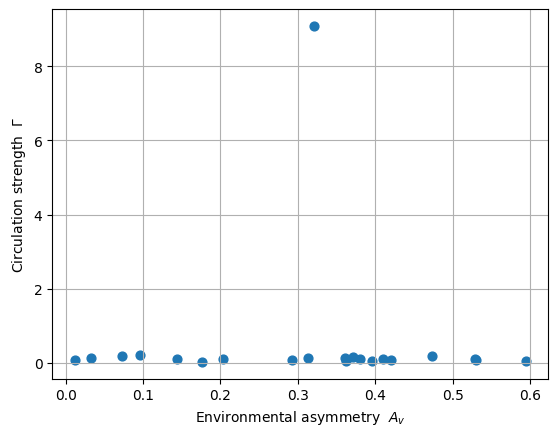

In [ ]:
# ============================================================
# Cell V3-10 — Scatter plot: circulation vs flow asymmetry
# Purpose: visualize relationship between Av_bar and Gamma_bar
# ============================================================


import matplotlib.pyplot as plt

plt.scatter(df_merge["Av_bar"], df_merge["Gamma_bar"], s=40)
plt.xlabel("Environmental asymmetry  $A_v$")
plt.ylabel("Circulation strength  $\\Gamma$")
plt.grid(True)
plt.show()

In [ ]:
# ============================================================
# Cell V3-11 — Strong vs weak rotators: asymmetry comparison
# Purpose: test whether flow asymmetry differs between high-Γ and low-Γ filaments
# ============================================================


thr = df_merge["Gamma_bar"].median()

df_merge["is_strong"] = df_merge["Gamma_bar"] > thr

# Compare Av_bar
import numpy as np
from scipy.stats import mannwhitneyu

Av_strong = df_merge.loc[df_merge["is_strong"], "Av_bar"]
Av_weak   = df_merge.loc[~df_merge["is_strong"], "Av_bar"]

print("Mean Av (strong):", Av_strong.mean())
print("Mean Av (weak):  ", Av_weak.mean())

u, p = mannwhitneyu(Av_strong, Av_weak, alternative="two-sided")
print(f"Mann–Whitney U p-value = {p:.3g}")

Mean Av (strong): 0.25685429131254073
Mean Av (weak):   0.35691155453736584
Mann–Whitney U p-value = 0.149


In [ ]:

# ============================================================
# Cell V3-12 — Radius-resolved asymmetry–circulation correlation
# Purpose: test whether A_v(R) tracks Γ(R) at matched radii (segment-level)
# ============================================================


from scipy.stats import spearmanr
import numpy as np

print("df_Av_seg columns:", [c for c in df_Av_seg.columns if c.startswith("Av_")])
print("df_real Gamma columns:", [c for c in df_real.columns if c.startswith("Gamma_")])

for R in COHERENCE_R:
    gcol = f"Gamma_R{R}"
    acol = f"Av_R{R}"

    # sanity checks
    if acol not in df_Av_seg.columns:
        print(f"SKIP R={R}: missing {acol} in df_Av_seg")
        continue
    if gcol not in df_real.columns:
        print(f"SKIP R={R}: missing {gcol} in df_real")
        continue

    dfR = (
        df_Av_seg[["cp0","seg_index", acol]]
        .merge(df_real[["cp0", gcol]], on="cp0", how="inner")
        .dropna()
    )

    rho, p = spearmanr(dfR[acol], dfR[gcol])
    print(f"R={R:>4} Mpc : N={len(dfR):>3}  Spearman rho={rho:+.3f}, p={p:.3g}")

df_Av_seg columns: ['Av_R2', 'Av_R4', 'Av_R10', 'Av_R12', 'Av_R15']
df_real Gamma columns: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20', 'Gamma_bar']
R=   2 Mpc : N= 25  Spearman rho=-0.162, p=0.439
R=   4 Mpc : N= 25  Spearman rho=-0.129, p=0.538
R=  10 Mpc : N= 23  Spearman rho=+0.078, p=0.725
R=  12 Mpc : N= 23  Spearman rho=+0.368, p=0.0837
R=  15 Mpc : N= 23  Spearman rho=+0.119, p=0.588


In [ ]:
# ============================================================
# Cell V3-13 — Permutation test for A_v(R)–Γ(R) correlation
# Purpose: assess significance of radius-matched correlations via label shuffling
# ============================================================


import numpy as np
from scipy.stats import spearmanr

rng = np.random.default_rng(0)
Nperm = 20000

for R in COHERENCE_R:
    gcol = f"Gamma_R{R}"
    acol = f"Av_R{R}"

    dfR = (
        df_Av_seg[["cp0","seg_index", acol]]
        .merge(df_real[["cp0", gcol]], on="cp0", how="inner")
        .dropna()
    )

    x = dfR[acol].to_numpy()
    y = dfR[gcol].to_numpy()

    rho_obs, _ = spearmanr(x, y)

    rhos = np.empty(Nperm)
    for i in range(Nperm):
        yperm = rng.permutation(y)
        rhos[i], _ = spearmanr(x, yperm)

    p_perm = (np.sum(np.abs(rhos) >= abs(rho_obs)) + 1) / (Nperm + 1)
    print(f"R={R:>4} Mpc : N={len(x):>3}  rho={rho_obs:+.3f}  perm_p={p_perm:.4f}")

R=   2 Mpc : N= 25  rho=-0.162  perm_p=0.4307
R=   4 Mpc : N= 25  rho=-0.129  perm_p=0.5347
R=  10 Mpc : N= 23  rho=+0.078  perm_p=0.7224
R=  12 Mpc : N= 23  rho=+0.368  perm_p=0.0833
R=  15 Mpc : N= 23  rho=+0.119  perm_p=0.5832


R grid: [2, 4, 6, 8, 10, 12, 15, 20]
    R  frac_above_95  frac_above_90  N_fil
0   2       0.047619       0.047619     21
1   4       0.095238       0.142857     21
2   6       0.095238       0.095238     21
3   8       0.095238       0.238095     21
4  10       0.142857       0.190476     21
5  12       0.000000       0.000000     21
6  15       0.142857       0.285714     21
7  20       0.095238       0.190476     21
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/A1V3_filament_exceedance_vs_R.csv


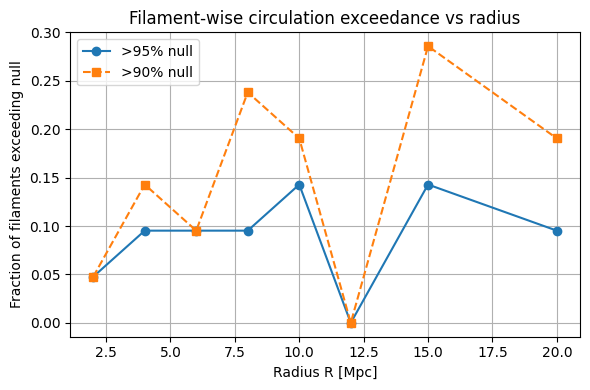

Cell 3 complete.


In [ ]:

# ============================================================
# P2a-1 — Scale diagnostic: filament-wise null exceedance vs radius (axis-null)
# Uses per-filament p-values from A1V3_axisnull_percentiles_by_filament.csv
# Output: fraction of filaments exceeding 90%/95% null at each R
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load real filament-level Gamma
df_real = pd.read_csv(
    os.path.join(PATHS["phase1_outputs"], "A1V3_vphi_gamma_profiles_FIL.csv")
)

# Load axis-randomized null percentiles by filament
# Expected columns like: cp0, p_absGamma_R2, p_absGamma_R4, ...
df_axis_pct = pd.read_csv(
    os.path.join(PATHS["phase1_outputs"], "A1V3_axisnull_percentiles_by_filament.csv")
)

# Radii present
R_vals = [2, 4, 6, 8, 10, 12, 15, 20]
R_vals = [R for R in R_vals if f"Gamma_R{R}" in df_real.columns]

print("R grid:", R_vals)

# Compute exceedance fractions
rows = []
for R in R_vals:
    gcol = f"Gamma_R{R}"
    pcol = f"p_absGamma_R{R}"

    merged = df_real[["cp0", gcol]].merge(
        df_axis_pct[["cp0", pcol]],
        on="cp0",
        how="inner"
    )

    absG = np.abs(merged[gcol].values)
    pvals = merged[pcol].values

    frac_95 = np.mean(pvals <= 0.05)
    frac_90 = np.mean(pvals <= 0.10)

    rows.append({
        "R": R,
        "frac_above_95": frac_95,
        "frac_above_90": frac_90,
        "N_fil": len(merged)
    })

df_exceed = pd.DataFrame(rows)
print(df_exceed)

# Save table
out_path = os.path.join(PATHS["phase1_outputs"], "A1V3_filament_exceedance_vs_R.csv")
df_exceed.to_csv(out_path, index=False)
print("Saved:", out_path)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df_exceed["R"], df_exceed["frac_above_95"], "o-", label=">95% null")
plt.plot(df_exceed["R"], df_exceed["frac_above_90"], "s--", label=">90% null")

plt.xlabel("Radius R [Mpc]")
plt.ylabel("Fraction of filaments exceeding null")
plt.title("Filament-wise circulation exceedance vs radius")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Cell 3 complete.")

In [ ]:
# ============================================================
# P2a-0 — Sanity check: identify in-memory DataFrames containing Gamma_R*
# (helps avoid silent variable-name mismatches)
# ============================================================


cands = [k for k,v in globals().items()
         if hasattr(v, "columns") and "Gamma_R2" in getattr(v, "columns", [])]

print("DataFrames with Gamma_R2:", cands)

DataFrames with Gamma_R2: []


In [ ]:
# ============================================================
# P2a-2 — Null test: sign-randomization on real sample (coherence stress test)
# Compares observed exceedance fraction vs axis-null to a permutation baseline
# NOTE: keeps axis-null fixed; only perturbs the real sample to check robustness
# ============================================================


import numpy as np
import pandas as pd

# --- CONFIG ---
R_grid = [2, 4, 6, 8, 10, 12, 15, 20]
Nperm = 2000
rng = np.random.default_rng(123)

gamma_cols = {R: f"Gamma_R{R}" for R in R_grid}

def frac_exceed(real_vals, null_vals, q=95):
    # threshold from null distribution
    thresh = np.percentile(null_vals, q)
    return np.mean(real_vals > thresh)

# --- OBSERVED exceedance fractions vs axis-null ---
obs_frac = {}
for R in R_grid:
    real = np.abs(df_real[gamma_cols[R]].values)
    null = np.abs(df_null[gamma_cols[R]].values)
    obs_frac[R] = frac_exceed(real, null, q=95)

# --- SIGN-RANDOMIZED null (destroys coherent handedness in real sample only) ---
perm_frac = {R: [] for R in R_grid}

for _ in range(Nperm):
    signs = rng.choice([-1, 1], size=len(df_real))
    for R in R_grid:
        real_perm = np.abs(df_real[gamma_cols[R]].values * signs)
        null = np.abs(df_null[gamma_cols[R]].values)
        perm_frac[R].append(frac_exceed(real_perm, null, q=95))

# --- SUMMARY TABLE ---
rows = []
for R in R_grid:
    pf = np.array(perm_frac[R])
    rows.append({
        "R_Mpc": R,
        "obs_frac": obs_frac[R],
        "perm_mean": pf.mean(),
        "perm_q95": np.percentile(pf, 95),
        "perm_p": np.mean(pf >= obs_frac[R]),  # permutation p-value
    })

df_sign_null = pd.DataFrame(rows)
print(df_sign_null)

   R_Mpc  obs_frac  perm_mean  perm_q95  perm_p
0      2  0.000000   0.000000  0.000000     1.0
1      4  0.000000   0.000000  0.000000     1.0
2      6  0.047619   0.047619  0.047619     1.0
3      8  0.047619   0.047619  0.047619     1.0
4     10  0.000000   0.000000  0.000000     1.0
5     12  0.047619   0.047619  0.047619     1.0
6     15  0.047619   0.047619  0.047619     1.0
7     20  0.000000   0.000000  0.000000     1.0


In [ ]:
# ============================================================
# PHASE 2B (P2B) — Directional Environment Predictors
# Purpose:
#   Test whether filament-scale Eulerian circulation is
#   associated with *directional* organization of the
#   transverse velocity field, beyond scalar asymmetry.
#
# Status:
#   Purely observational, Eulerian, model-agnostic.
# ============================================================

In [ ]:
# ============================================================
# Phase 2B-1 — Directional / Topological Environment Tests
# Cell 2B1-1 — Load frozen Phase-1 products
#
# Purpose:
#   Bring Phase-1 circulation results and segment geometry
#   into memory for directional (non-scalar) analysis.
#
# Notes:
#   - No recomputation
#   - Phase-1 outputs treated as immutable
# ============================================================

import os
import pandas as pd

PHASE1 = PATHS["phase1_outputs"]

# Filament-level circulation profiles
df_real = pd.read_csv(
    os.path.join(PHASE1, "A1V3_vphi_gamma_profiles_FIL.csv")
)

# Segment-level geometry (centers, axes)
df_seg = pd.read_csv(
    os.path.join(PHASE1, "A1V3_vphi_profiles_SEG.csv")
)

print("Loaded Phase-1 products:")
print("  df_real (filaments):", df_real.shape)
print("  df_seg  (segments) :", df_seg.shape)

# Sanity checks
assert "cp0" in df_real.columns, "df_real missing cp0"
assert "cp0" in df_seg.columns,  "df_seg missing cp0"

print("Cell 2B1-1 complete.")

Loaded Phase-1 products:
  df_real (filaments): (21, 18)
  df_seg  (segments) : (25, 22)
Cell 2B1-1 complete.


In [ ]:
# ============================================================
# Phase 2B-1 — Directional / Topological Environment Tests
# Cell 2B1-2 — Define directional ring observables (dipole/quadrupole)
#
# Purpose:
#   Replace scalar "left-right" A_v with a directional descriptor of the
#   transverse structure around each segment at each radius R.
#
# What we will measure (per segment, per R):
#   - Fourier dipole amplitude of |v_phi(phi)| around the ring  (m=1)
#   - Fourier quadrupole amplitude of |v_phi(phi)| around the ring (m=2)
#   - Dipole direction angle (phi0) in the transverse plane
#
# Notes:
#   - This cell defines math + helpers only (no grid sampling yet).
#   - Next cell will actually sample v_phi(phi) from the velocity grid.
# ============================================================

import numpy as np

EPS = 1e-12

# --- Analysis radii (use the same set you used for Gamma_bar / Av_bar) ---
COHERENCE_R = [2, 4, 10, 12, 15]   # Mpc

# --- Ring sampling density (phi samples) ---
NPHI = 64

def orthonormal_basis(e_hat):
    """
    Build a stable right-handed transverse basis (u_hat, v_hat) for a given axis e_hat.
    Returns u_hat, v_hat, e_hat (all unit).
    """
    e_hat = np.asarray(e_hat, dtype=float)
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

    # pick a vector not parallel to e_hat
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, e_hat)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])

    u_hat = np.cross(e_hat, a)
    u_hat = u_hat / (np.linalg.norm(u_hat) + EPS)
    v_hat = np.cross(e_hat, u_hat)
    v_hat = v_hat / (np.linalg.norm(v_hat) + EPS)

    return u_hat, v_hat, e_hat

def ring_points(center, u_hat, v_hat, R, nphi=NPHI):
    """
    Return (phis, points) for a ring of radius R in the transverse plane.
    points shape: (nphi, 3)
    """
    center = np.asarray(center, dtype=float)
    phis = np.linspace(0, 2*np.pi, int(nphi), endpoint=False)

    pts = center[None, :] + R*(np.cos(phis)[:,None]*u_hat[None,:] + np.sin(phis)[:,None]*v_hat[None,:])
    return phis, pts

def fourier_mode_amplitude(y, phis, m):
    """
    Compute normalized Fourier mode amplitude for y(phis) at mode m:
      a_m = (2/N) * sum y cos(m phi)
      b_m = (2/N) * sum y sin(m phi)
      amp = sqrt(a_m^2 + b_m^2)
      ang = atan2(b_m, a_m) / m   (direction angle for the mode)
    Returns (amp, ang, a_m, b_m)
    """
    y = np.asarray(y, dtype=float)
    phis = np.asarray(phis, dtype=float)
    N = len(y)
    if N == 0:
        return np.nan, np.nan, np.nan, np.nan

    c = np.cos(m*phis)
    s = np.sin(m*phis)

    a = (2.0/N) * np.sum(y * c)
    b = (2.0/N) * np.sum(y * s)

    amp = np.sqrt(a*a + b*b)
    ang = (np.arctan2(b, a) / m)  # angle in [−pi/m, +pi/m]

    return float(amp), float(ang), float(a), float(b)

def directional_summary_from_vphi(vphi, phis):
    """
    Given vphi(phi) samples, return directional features based on |vphi|.
    We use |vphi| so the descriptor captures anisotropy even if handedness flips.
    Output keys:
      dip_amp, dip_ang, quad_amp, quad_ang, mean_abs
    """
    vphi = np.asarray(vphi, dtype=float)
    phis = np.asarray(phis, dtype=float)

    y = np.abs(vphi)
    mean_abs = float(np.mean(y)) if len(y) else np.nan

    dip_amp, dip_ang, _, _   = fourier_mode_amplitude(y, phis, m=1)
    quad_amp, quad_ang, _, _ = fourier_mode_amplitude(y, phis, m=2)

    return {
        "mean_abs_vphi": mean_abs,
        "dip_amp": dip_amp,
        "dip_ang": dip_ang,
        "quad_amp": quad_amp,
        "quad_ang": quad_ang
    }

print("Cell 2B1-2 complete: directional observables defined (dipole/quadrupole on |v_phi(phi)|).")
print("Next cell will sample v_phi(phi) from the velocity grid and build segment/filament tables.")

Cell 2B1-2 complete: directional observables defined (dipole/quadrupole on |v_phi(phi)|).
Next cell will sample v_phi(phi) from the velocity grid and build segment/filament tables.


In [ ]:
# ============================================================
# Cell 2B1-2.5 — Ensure a usable velocity GRID_BUNDLE exists (required for 2B1-3)
# Robust rule: only use in-memory grid if VEL_GRID + GRID_ORIGIN + GRID_DX are all valid.
# ============================================================

import os, numpy as np

def _valid_dx(x):
    try:
        return (x is not None) and np.isfinite(float(x)) and (float(x) > 0)
    except Exception:
        return False

# --- Option A: use in-memory grid ONLY if fully defined ---
use_mem = (
    ("VEL_GRID" in globals()) and (globals()["VEL_GRID"] is not None) and
    ("GRID_ORIGIN" in globals()) and (globals()["GRID_ORIGIN"] is not None) and
    ("GRID_DX" in globals()) and _valid_dx(globals()["GRID_DX"])
)

if use_mem:
    GRID_BUNDLE = {
        "VEL_GRID": globals()["VEL_GRID"],
        "GRID_ORIGIN": np.array(globals()["GRID_ORIGIN"], dtype=float),
        "GRID_DX": float(globals()["GRID_DX"]),
    }
    src = "in-memory VEL_GRID / GRID_ORIGIN / GRID_DX"
else:
    # --- Option B: load from NPZ (edit path if needed) ---
    npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"

    if not os.path.exists(npz_path):
        # print helpful debug about what we *did* have in memory
        print("In-memory status:")
        print("  VEL_GRID exists:", "VEL_GRID" in globals(), " value is None:", globals().get("VEL_GRID", None) is None)
        print("  GRID_ORIGIN exists:", "GRID_ORIGIN" in globals(), " value is None:", globals().get("GRID_ORIGIN", None) is None)
        print("  GRID_DX exists:", "GRID_DX" in globals(), " value:", globals().get("GRID_DX", None))
        raise FileNotFoundError(
            "No usable in-memory grid (often because GRID_DX is None), and NPZ path does not exist:\n"
            f"  {npz_path}\n"
            "Fix: (1) point npz_path to your saved CF4 grid NPZ (preferred), or\n"
            "     (2) re-run the cell that builds the grid and ensure GRID_DX is set."
        )

    Z = np.load(npz_path, allow_pickle=True)
    GRID_BUNDLE = {
        "VEL_GRID": Z["VEL_GRID"],
        "GRID_ORIGIN": np.array(Z["GRID_ORIGIN"], dtype=float),
        "GRID_DX": float(Z["GRID_DX"]),
    }
    src = f"NPZ: {npz_path}"

print("GRID_BUNDLE source:", src)
print("GRID_BUNDLE keys:", list(GRID_BUNDLE.keys()))
print("VEL_GRID shape:", np.array(GRID_BUNDLE['VEL_GRID']).shape)
print("origin:", GRID_BUNDLE["GRID_ORIGIN"], "dx:", GRID_BUNDLE["GRID_DX"])
print("Cell 2B1-2.5 complete.")

GRID_BUNDLE source: in-memory VEL_GRID / GRID_ORIGIN / GRID_DX
GRID_BUNDLE keys: ['VEL_GRID', 'GRID_ORIGIN', 'GRID_DX']
VEL_GRID shape: (15, 40, 24, 3)
origin: [  9.51426825 -38.39587143 -20.9638    ] dx: 2.0
Cell 2B1-2.5 complete.


In [ ]:
# ============================================================
# Phase 2B-1 — Directional / Topological Environment Tests
# Cell 2B1-3 — Sample v_phi(phi) on rings and build directional tables
#
# Purpose:
#   For each segment and radius R, sample v_phi(phi) around the filament axis,
#   then compute directional structure of |v_phi(phi)|:
#     - mean_abs_vphi
#     - dipole (m=1) amplitude + angle
#     - quadrupole (m=2) amplitude + angle
#   Output:
#     - df_dir_seg  (segment-level)
#     - df_dir_fil  (filament-level aggregation)
#   Saves CSVs to Phase-2 output folder (falls back to phase1_outputs).
# ============================================================

import os
import numpy as np
import pandas as pd

EPS = 1e-12
NPHI = 64
COHERENCE_R = [2, 4, 10, 12, 15]   # Mpc (keep consistent with your earlier Phase-2A runs)

# -----------------------------
# Output folder
# -----------------------------
OUTDIR = PATHS.get("phase2_outputs", PATHS["phase1_outputs"])
os.makedirs(OUTDIR, exist_ok=True)

# -----------------------------
# Grid loader (expects VEL_GRID + origin + dx)
# -----------------------------
def _try_get_grid_bundle():
    """
    Returns (VEL_GRID, origin, dx) if available in memory.
    Priority:
      1) GRID_BUNDLE dict
      2) grid_cf4 dict-like with expected keys
      3) fall back to loading NPZ if path exists in Drive (optional)
    """
    # (1) If you already defined this dict in a previous cell, we use it.
    if "GRID_BUNDLE" in globals():
        gb = globals()["GRID_BUNDLE"]
        return gb["VEL_GRID"], np.array(gb["GRID_ORIGIN"], float), float(gb["GRID_DX"])

    # (2) If grid_cf4 exists and is dict-like with expected keys
    if "grid_cf4" in globals():
        g = globals()["grid_cf4"]
        if isinstance(g, dict) and ("VEL_GRID" in g) and ("GRID_ORIGIN" in g) and ("GRID_DX" in g):
            return g["VEL_GRID"], np.array(g["GRID_ORIGIN"], float), float(g["GRID_DX"])

    # (3) Optional fallback: NPZ analytic swirl asset (debug only)
    # Uncomment only if you explicitly want to run on the analytic grid:
    # npz_path = "/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz"
    # if os.path.exists(npz_path):
    #     Z = np.load(npz_path, allow_pickle=True)
    #     return Z["VEL_GRID"], np.array(Z["GRID_ORIGIN"], float), float(Z["GRID_DX"])

    return None, None, None

VEL_GRID, GRID_ORIGIN, GRID_DX = _try_get_grid_bundle()

if VEL_GRID is None:
    raise RuntimeError(
        "No usable velocity grid found. Define GRID_BUNDLE = {'VEL_GRID':..., 'GRID_ORIGIN':..., 'GRID_DX':...} "
        "or ensure grid_cf4 is a dict with those keys."
    )

# -----------------------------
# Robust unpack for VEL_GRID
# Supports (Nx,Ny,Nz,3) or (3,Nx,Ny,Nz)
# -----------------------------
V = np.asarray(VEL_GRID)
if V.ndim != 4:
    raise ValueError(f"Unexpected VEL_GRID ndim={V.ndim}, shape={V.shape}")

if V.shape[-1] == 3:
    # (Nx,Ny,Nz,3)
    Vx, Vy, Vz = V[...,0], V[...,1], V[...,2]
elif V.shape[0] == 3:
    # (3,Nx,Ny,Nz)
    Vx, Vy, Vz = V[0], V[1], V[2]
else:
    raise ValueError(f"Unexpected VEL_GRID shape {V.shape}; expected (...,3) or (3,...)")

nx, ny, nz = Vx.shape

# -----------------------------
# Trilinear sampling
# -----------------------------
def sample_velocity_grid(p):
    """
    Trilinear sample v(x) from grid at world position p (x,y,z).
    Returns v (3,) or None if out-of-bounds.
    """
    p = np.asarray(p, dtype=float)
    q = (p - GRID_ORIGIN) / GRID_DX
    i0 = np.floor(q).astype(int)
    t = q - i0
    ix, iy, iz = i0

    if ix < 0 or iy < 0 or iz < 0 or ix+1 >= nx or iy+1 >= ny or iz+1 >= nz:
        return None

    tx, ty, tz = t

    def S(A):
        c000 = A[ix,   iy,   iz]
        c100 = A[ix+1, iy,   iz]
        c010 = A[ix,   iy+1, iz]
        c110 = A[ix+1, iy+1, iz]
        c001 = A[ix,   iy,   iz+1]
        c101 = A[ix+1, iy,   iz+1]
        c011 = A[ix,   iy+1, iz+1]
        c111 = A[ix+1, iy+1, iz+1]

        c00 = c000*(1-tx) + c100*tx
        c10 = c010*(1-tx) + c110*tx
        c01 = c001*(1-tx) + c101*tx
        c11 = c011*(1-tx) + c111*tx

        c0 = c00*(1-ty) + c10*ty
        c1 = c01*(1-ty) + c11*ty

        return c0*(1-tz) + c1*tz

    return np.array([S(Vx), S(Vy), S(Vz)], dtype=float)

# -----------------------------
# Geometry helpers (reuse from Cell 2B1-2 if present)
# -----------------------------
def orthonormal_basis(e_hat):
    e_hat = np.asarray(e_hat, dtype=float)
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, e_hat)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])

    u_hat = np.cross(e_hat, a)
    u_hat = u_hat / (np.linalg.norm(u_hat) + EPS)
    v_hat = np.cross(e_hat, u_hat)
    v_hat = v_hat / (np.linalg.norm(v_hat) + EPS)
    return u_hat, v_hat, e_hat

def fourier_mode_amplitude(y, phis, m):
    y = np.asarray(y, dtype=float)
    phis = np.asarray(phis, dtype=float)
    N = len(y)
    if N == 0:
        return np.nan, np.nan
    c = np.cos(m*phis); s = np.sin(m*phis)
    a = (2.0/N) * np.sum(y*c)
    b = (2.0/N) * np.sum(y*s)
    amp = np.sqrt(a*a + b*b)
    ang = (np.arctan2(b, a) / m)
    return float(amp), float(ang)

# -----------------------------
# Main: compute directional stats for one segment
# -----------------------------
def directional_for_segment(center, e_hat, R, nphi=NPHI):
    """
    Returns dict with:
      mean_abs_vphi, dip_amp, dip_ang, quad_amp, quad_ang,
      and normalized dip_frac= dip_amp/mean_abs, quad_frac=quad_amp/mean_abs
    """
    center = np.asarray(center, float)
    u_hat, v_hat, e_hat = orthonormal_basis(e_hat)

    phis = np.linspace(0, 2*np.pi, int(nphi), endpoint=False)

    vphi = []
    kept_phis = []

    for phi in phis:
        r_hat = np.cos(phi)*u_hat + np.sin(phi)*v_hat
        p = center + float(R)*r_hat

        v = sample_velocity_grid(p)
        if v is None:
            continue

        # remove axial component
        v = np.asarray(v, float)
        v_perp = v - np.dot(v, e_hat)*e_hat

        # tangential unit vector
        phi_hat = np.cross(e_hat, r_hat)
        phi_hat = phi_hat / (np.linalg.norm(phi_hat) + EPS)

        vphi.append(float(np.dot(v_perp, phi_hat)))  # signed
        kept_phis.append(float(phi))

    if len(vphi) < max(8, nphi//4):
        return {
            "mean_abs_vphi": np.nan,
            "dip_amp": np.nan, "dip_ang": np.nan,
            "quad_amp": np.nan, "quad_ang": np.nan,
            "dip_frac": np.nan, "quad_frac": np.nan,
            "n_used": int(len(vphi))
        }

    vphi = np.array(vphi, float)
    kept_phis = np.array(kept_phis, float)

    y = np.abs(vphi)
    mean_abs = float(np.mean(y))

    dip_amp, dip_ang   = fourier_mode_amplitude(y, kept_phis, m=1)
    quad_amp, quad_ang = fourier_mode_amplitude(y, kept_phis, m=2)

    dip_frac  = float(dip_amp  / (mean_abs + EPS))
    quad_frac = float(quad_amp / (mean_abs + EPS))

    return {
        "mean_abs_vphi": mean_abs,
        "dip_amp": dip_amp, "dip_ang": dip_ang,
        "quad_amp": quad_amp, "quad_ang": quad_ang,
        "dip_frac": dip_frac, "quad_frac": quad_frac,
        "n_used": int(len(vphi))
    }

# -----------------------------
# Build segment-level table
# Requires df_seg columns: cp0, seg_index, cx,cy,cz, x0,y0,z0, x1,y1,z1
# -----------------------------
req = ["cp0","cx","cy","cz","x0","y0","z0","x1","y1","z1"]
missing = [c for c in req if c not in df_seg.columns]
if missing:
    raise KeyError(f"df_seg missing required columns: {missing}")

rows = []
for _, r in df_seg.iterrows():
    cp0 = int(r["cp0"])
    seg_index = int(r.get("seg_index", -1))
    center = np.array([r["cx"], r["cy"], r["cz"]], float)
    p0 = np.array([r["x0"], r["y0"], r["z0"]], float)
    p1 = np.array([r["x1"], r["y1"], r["z1"]], float)
    e_hat = p1 - p0
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

    rec = {"cp0": cp0, "seg_index": seg_index}
    for R in COHERENCE_R:
        stats = directional_for_segment(center, e_hat, R, nphi=NPHI)
        for k, v in stats.items():
            rec[f"{k}_R{R}"] = v
    rows.append(rec)

df_dir_seg = pd.DataFrame(rows)
print("Built df_dir_seg:", df_dir_seg.shape)
print(df_dir_seg.head())

# -----------------------------
# Aggregate to filament-level (mean over segments)
# -----------------------------
stat_prefixes = ["mean_abs_vphi", "dip_amp", "dip_ang", "quad_amp", "quad_ang", "dip_frac", "quad_frac", "n_used"]
cols = ["cp0"] + [f"{p}_R{R}" for R in COHERENCE_R for p in stat_prefixes if f"{p}_R{R}" in df_dir_seg.columns]

df_dir_fil = df_dir_seg[cols].groupby("cp0").mean(numeric_only=True).reset_index()

# Add simple summaries over radii (mean of dip_frac / quad_frac)
dip_frac_cols  = [f"dip_frac_R{R}" for R in COHERENCE_R if f"dip_frac_R{R}" in df_dir_fil.columns]
quad_frac_cols = [f"quad_frac_R{R}" for R in COHERENCE_R if f"quad_frac_R{R}" in df_dir_fil.columns]

df_dir_fil["dip_frac_bar"]  = df_dir_fil[dip_frac_cols].mean(axis=1) if dip_frac_cols else np.nan
df_dir_fil["quad_frac_bar"] = df_dir_fil[quad_frac_cols].mean(axis=1) if quad_frac_cols else np.nan

print("\nBuilt df_dir_fil:", df_dir_fil.shape)
print(df_dir_fil[["cp0","dip_frac_bar","quad_frac_bar"]].sort_values("dip_frac_bar", ascending=False).head(10))

# -----------------------------
# Save outputs
# -----------------------------
seg_out = os.path.join(OUTDIR, "P2B1_directional_RING_SEG.csv")
fil_out = os.path.join(OUTDIR, "P2B1_directional_RING_FIL.csv")

df_dir_seg.to_csv(seg_out, index=False)
df_dir_fil.to_csv(fil_out, index=False)

print("\nSaved:")
print(" ", seg_out)
print(" ", fil_out)
print("\nCell 2B1-3 complete.")

Built df_dir_seg: (25, 42)
     cp0  seg_index  mean_abs_vphi_R2  dip_amp_R2  dip_ang_R2  quad_amp_R2  \
0  25158          0         41.212345    1.649344    2.797981    27.438213   
1  30960          1         30.748552    6.297872    0.431103    20.039511   
2  30960          2         34.614883    6.836623    0.923853    22.590461   
3  33627          3         25.467991   12.081924   -3.141593    14.963796   
4  36561          4         69.985796   62.989518   -2.909448    37.013346   

    quad_ang_R2  dip_frac_R2  quad_frac_R2  n_used_R2  ...  quad_frac_R12  \
0 -3.318751e-01     0.040021      0.665777         64  ...       0.855143   
1  4.305090e-01     0.204818      0.651722         64  ...       0.247102   
2  9.237078e-01     0.197505      0.652623         64  ...       0.850605   
3  3.895182e-17     0.474396      0.587553         64  ...       0.497403   
4  9.139744e-01     0.900033      0.528869         47  ...       1.125188   

   n_used_R12  mean_abs_vphi_R15  dip_amp

In [ ]:
# ============================================================
# Cell 2B1-4 — Merge directional predictors with circulation strength and test correlation
# Inputs:
#   - df_real (Phase-1 filament Gamma profiles) with Gamma_bar already computed OR we compute it here
#   - df_dir_fil (from 2B1-3) with dip_frac_bar, quad_frac_bar
# Output:
#   - df_2B1_merge table and Spearman/Pearson tests vs Gamma_bar
# ============================================================

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# ---- ensure Gamma_bar exists (use your coherence radii) ----
COHERENCE_R = [2, 4, 10, 12, 15]
gamma_cols = [f"Gamma_R{R}" for R in COHERENCE_R if f"Gamma_R{R}" in df_real.columns]

if "Gamma_bar" not in df_real.columns:
    df_real = df_real.copy()
    df_real["Gamma_bar"] = df_real[gamma_cols].abs().mean(axis=1)

# ---- merge (filament level) ----
df_2B1_merge = (
    df_real[["cp0", "Gamma_bar"]]
    .merge(df_dir_fil[["cp0", "dip_frac_bar", "quad_frac_bar"]], on="cp0", how="inner")
    .dropna()
)

print("Merged 2B1 table:", df_2B1_merge.shape)
print(df_2B1_merge.head())

# ---- correlations ----
for col in ["dip_frac_bar", "quad_frac_bar"]:
    x = df_2B1_merge[col].to_numpy()
    y = df_2B1_merge["Gamma_bar"].to_numpy()

    rho, p_rho = spearmanr(x, y)
    r, p_r = pearsonr(x, y)

    print(f"\n{col} vs Gamma_bar")
    print(f"  Spearman rho = {rho:+.3f}, p = {p_rho:.3g}")
    print(f"  Pearson  r   = {r:+.3f}, p = {p_r:.3g}")

print("\nCell 2B1-4 complete.")

Merged 2B1 table: (21, 4)
     cp0  Gamma_bar  dip_frac_bar  quad_frac_bar
0  25158   0.176157      0.491543       0.775283
1  30960   0.051380      0.939113       0.655369
2  33627   0.178412      0.959330       0.488602
3  36561   0.064977      1.552044       0.940225
4  45342   0.171632      0.676042       0.812100

dip_frac_bar vs Gamma_bar
  Spearman rho = -0.186, p = 0.42
  Pearson  r   = +0.437, p = 0.0473

quad_frac_bar vs Gamma_bar
  Spearman rho = +0.048, p = 0.836
  Pearson  r   = +0.140, p = 0.544

Cell 2B1-4 complete.


In [ ]:
# ============================================================
# Cell 2B1-5 — Radius-by-radius test: dipole fraction vs circulation
# Purpose:
#   Identify which radii drive the dipole–Gamma correlation
# ============================================================

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr

rows = []

for R in COHERENCE_R:
    dip_col = f"dip_frac_R{R}"
    gam_col = f"Gamma_R{R}"

    if dip_col not in df_dir_fil.columns or gam_col not in df_real.columns:
        print(f"Skipping R={R}: missing columns")
        continue

    dfR = (
        df_dir_fil[["cp0", dip_col]]
        .merge(df_real[["cp0", gam_col]], on="cp0", how="inner")
        .dropna()
    )

    x = dfR[dip_col].to_numpy()
    y = np.abs(dfR[gam_col].to_numpy())

    rho, p_rho = spearmanr(x, y)
    r, p_r = pearsonr(x, y)

    rows.append({
        "R": R,
        "N": len(dfR),
        "rho_spearman": rho,
        "p_spearman": p_rho,
        "r_pearson": r,
        "p_pearson": p_r
    })

df_2B1_radial = pd.DataFrame(rows)
print(df_2B1_radial)

print("\nCell 2B1-5 complete.")

    R   N  rho_spearman  p_spearman  r_pearson  p_pearson
0   2  21      0.066234    0.775454  -0.109448   0.636739
1   4  21      0.083117    0.720203   0.014502   0.950252
2  10  21     -0.310390    0.170877  -0.229246   0.317501
3  12  20      0.027068    0.909812   0.328472   0.157368
4  15  20     -0.215038    0.362574   0.302014   0.195612

Cell 2B1-5 complete.


In [ ]:
# ============================================================
# Cell 2B2-1 — Dipole phase coherence along filament spines
# Tests whether transverse flow direction is internally aligned
# within individual filaments (topological organization test)
# ============================================================

import numpy as np
import pandas as pd

EPS = 1e-12

# We assume df_dir_seg already exists from Phase 2B1
# Required columns:
#   cp0, seg_index, dip_ang_R2, dip_ang_R4, dip_ang_R10, dip_ang_R12, dip_ang_R15

# Use the same coherence window as before
COHERENCE_R = [2, 4, 10, 12, 15]

dip_ang_cols = [f"dip_ang_R{R}" for R in COHERENCE_R]
dip_ang_cols = [c for c in dip_ang_cols if c in df_dir_seg.columns]

print("Using dipole angle columns:", dip_ang_cols)

def circular_coherence(angles):
    """
    Mean resultant length for circular data.
    Returns value in [0,1].
    """
    angles = np.asarray(angles)
    angles = angles[np.isfinite(angles)]
    if len(angles) == 0:
        return np.nan
    z = np.exp(1j * angles)
    return np.abs(np.mean(z))

# ------------------------------------------------------------
# Compute dipole phase coherence per filament
# ------------------------------------------------------------
rows = []

for cp0, grp in df_dir_seg.groupby("cp0"):
    # collect all dipole angles across segments & radii
    angs = []
    for c in dip_ang_cols:
        angs.extend(grp[c].values.tolist())

    angs = np.array(angs, dtype=float)
    angs = angs[np.isfinite(angs)]

    rows.append({
        "cp0": int(cp0),
        "n_segments": grp.shape[0],
        "n_angles": len(angs),
        "dipole_phase_coherence": circular_coherence(angs)
    })

df_coh_fil = pd.DataFrame(rows).sort_values(
    "dipole_phase_coherence", ascending=False
)

print("\nDipole phase coherence per filament:")
print(df_coh_fil)

# Save for downstream null tests
out_path = (
    "/content/drive/MyDrive/SFH_filaments/phase1_outputs/"
    "P2B2_dipole_phase_coherence_FIL.csv"
)
df_coh_fil.to_csv(out_path, index=False)
print("\nSaved:", out_path)

print("Cell 2B2-1 complete.")

Using dipole angle columns: ['dip_ang_R2', 'dip_ang_R4', 'dip_ang_R10', 'dip_ang_R12', 'dip_ang_R15']

Dipole phase coherence per filament:
      cp0  n_segments  n_angles  dipole_phase_coherence
14  61898           1         5                0.998453
13  61765           1         5                0.997725
5   45343           1         5                0.995888
3   36561           1         5                0.989132
6   48226           1         5                0.977594
11  61418           1         3                0.967897
16  62169           1         5                0.960452
4   45342           1         5                0.947165
17  62170           1         5                0.944539
18  62177           1         5                0.943314
19  62178           1         5                0.935566
1   30960           2        10                0.928789
15  61955           1         5                0.925504
2   33627           1         5                0.921533
10  50834           

In [ ]:
# ============================================================
# Cell 2B2-2 — Dipole phase coherence: angle-shuffle null
# Tests whether observed coherence exceeds random angle ordering
# ============================================================

import numpy as np
import pandas as pd

# Load real dipole angles per segment (from 2B1)
df_dir_seg = pd.read_csv(
    "/content/drive/MyDrive/SFH_filaments/phase1_outputs/P2B1_directional_RING_SEG.csv"
)

# Load real filament-level coherence (from 2B2-1)
df_coh = pd.read_csv(
    "/content/drive/MyDrive/SFH_filaments/phase1_outputs/P2B2_dipole_phase_coherence_FIL.csv"
)

# Dipole angle columns to use
angle_cols = [c for c in df_dir_seg.columns if c.startswith("dip_ang_R")]

print("Using dipole angle columns:", angle_cols)

# Number of shuffles per filament
NSHUFF = 5000
rng = np.random.default_rng(123)

def phase_coherence(angles):
    """Return mean resultant length for a set of angles."""
    angles = np.asarray(angles)
    if len(angles) < 2:
        return np.nan
    return np.abs(np.mean(np.exp(1j * angles)))

rows = []

for cp0, grp in df_dir_seg.groupby("cp0"):
    # collect all real angles for this filament
    angles = []
    for _, r in grp.iterrows():
        for c in angle_cols:
            if np.isfinite(r[c]):
                angles.append(r[c])

    angles = np.array(angles)
    if len(angles) < 3:
        continue

    # observed coherence
    coh_obs = phase_coherence(angles)

    # shuffled null
    coh_null = np.empty(NSHUFF)
    for i in range(NSHUFF):
        shuffled = rng.permutation(angles)
        coh_null[i] = phase_coherence(shuffled)

    # permutation p-value
    p_perm = (np.sum(coh_null >= coh_obs) + 1) / (NSHUFF + 1)

    rows.append({
        "cp0": cp0,
        "coh_obs": coh_obs,
        "coh_null_mean": coh_null.mean(),
        "coh_null_q95": np.percentile(coh_null, 95),
        "p_perm": p_perm,
        "n_angles": len(angles)
    })

df_coh_null = pd.DataFrame(rows)

print("\nAngle-shuffle null results (first 10):")
print(df_coh_null.head(10))

# Save
outpath = "/content/drive/MyDrive/SFH_filaments/phase1_outputs/P2B2_dipole_phase_coherence_null_shuffle_FIL.csv"
df_coh_null.to_csv(outpath, index=False)
print("\nSaved:", outpath)
print("Cell 2B2-2 complete.")

Using dipole angle columns: ['dip_ang_R2', 'dip_ang_R4', 'dip_ang_R10', 'dip_ang_R12', 'dip_ang_R15']

Angle-shuffle null results (first 10):
     cp0   coh_obs  coh_null_mean  coh_null_q95    p_perm  n_angles
0  25158  0.504323       0.504323      0.504323  1.000000         5
1  30960  0.928789       0.928789      0.928789  0.804639        10
2  33627  0.921533       0.921533      0.921533  0.341932         5
3  36561  0.989132       0.989132      0.989132  0.252749         5
4  45342  0.947165       0.947165      0.947165  1.000000         5
5  45343  0.995888       0.995888      0.995888  1.000000         5
6  48226  0.977594       0.977594      0.977594  0.733453         5
7  48391  0.670403       0.670403      0.670403  1.000000        10
8  50095  0.571133       0.571133      0.571133  0.809838        10
9  50815  0.711535       0.711535      0.711535  1.000000         5

Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/P2B2_dipole_phase_coherence_null_shuffle_FIL.csv
C

In [ ]:
# ============================================================
# Cell 2B2-3 — Axis-randomized NULL for dipole phase coherence
# Purpose: test whether dipole-angle coherence is geometrically locked to the filament axis
# Method: recompute dipole angles using a randomized axis per segment, then compare coherence
# Outputs: per-filament null mean/q95/p-value; saved CSV in phase1_outputs
# ============================================================

import os, numpy as np, pandas as pd

# ---------- SETTINGS ----------
COHERENCE_R = [2, 4, 10, 12, 15]   # must match your 2B2-1 radii
NPHI = 64
NNULL = 300        # increase later (e.g., 1000) once working
SEED = 123
EPS = 1e-12

# ---------- REQUIREMENTS ----------
# Expect these already exist from earlier cells:
#   df_seg  : segment table with columns cp0,cx,cy,cz,x0,y0,z0,x1,y1,z1,seg_index
#   GRID_BUNDLE with keys: VEL_GRID, GRID_ORIGIN, GRID_DX  (from your Cell 2B1-2.5)
try:
    _ = df_seg
except NameError:
    raise NameError("df_seg is not defined. Re-run the cell that loads Phase-1 products (df_seg).")

try:
    VEL_GRID = GRID_BUNDLE["VEL_GRID"]
    GRID_ORIGIN = np.array(GRID_BUNDLE["GRID_ORIGIN"], dtype=float)
    GRID_DX = float(GRID_BUNDLE["GRID_DX"])
except NameError:
    raise NameError("GRID_BUNDLE is not defined. Re-run the cell that loads the NPZ into GRID_BUNDLE.")

PHASE1 = PATHS["phase1_outputs"]
out_csv = os.path.join(PHASE1, "P2B2_axisnull_dipole_phase_coherence_FIL.csv")

# ---------- HELPERS ----------
def random_unit_vector(rng):
    v = rng.normal(size=3)
    return v / (np.linalg.norm(v) + EPS)

def orthonormal_basis(e_hat):
    e_hat = np.asarray(e_hat, dtype=float)
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, e_hat)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])
    u = np.cross(e_hat, a); u = u / (np.linalg.norm(u) + EPS)
    v = np.cross(e_hat, u); v = v / (np.linalg.norm(v) + EPS)
    return u, v, e_hat

def sample_velocity_grid(p):
    """Trilinear sample of VEL_GRID at world coords p; returns v(3,) or None if OOB."""
    p = np.asarray(p, dtype=float)
    q = (p - GRID_ORIGIN) / GRID_DX
    i0 = np.floor(q).astype(int)
    t = q - i0
    Nx, Ny, Nz, _ = VEL_GRID.shape
    ix, iy, iz = i0
    if ix < 0 or iy < 0 or iz < 0 or ix+1 >= Nx or iy+1 >= Ny or iz+1 >= Nz:
        return None

    def V(i,j,k): return VEL_GRID[i,j,k,:]

    c000 = V(ix,   iy,   iz)
    c100 = V(ix+1, iy,   iz)
    c010 = V(ix,   iy+1, iz)
    c110 = V(ix+1, iy+1, iz)
    c001 = V(ix,   iy,   iz+1)
    c101 = V(ix+1, iy,   iz+1)
    c011 = V(ix,   iy+1, iz+1)
    c111 = V(ix+1, iy+1, iz+1)

    tx, ty, tz = t
    c00 = c000*(1-tx) + c100*tx
    c10 = c010*(1-tx) + c110*tx
    c01 = c001*(1-tx) + c101*tx
    c11 = c011*(1-tx) + c111*tx
    c0  = c00*(1-ty) + c10*ty
    c1  = c01*(1-ty) + c11*ty
    return c0*(1-tz) + c1*tz

def dipole_angle_from_abs_vphi(center, e_hat, R, nphi=64):
    """
    Sample |v_phi(phi)| on a ring and return dipole angle arg(m1),
    where m1 = sum(|vphi| * exp(i*phi)).
    Returns np.nan if insufficient samples.
    """
    center = np.asarray(center, dtype=float)
    u_hat, v_hat, e_hat = orthonormal_basis(e_hat)
    phis = np.linspace(0, 2*np.pi, nphi, endpoint=False)

    w = []
    phi_used = []
    for phi in phis:
        p = center + R*(np.cos(phi)*u_hat + np.sin(phi)*v_hat)
        v = sample_velocity_grid(p)
        if v is None:
            continue
        v = np.asarray(v, dtype=float)
        v_perp = v - np.dot(v, e_hat)*e_hat

        r_hat = np.cos(phi)*u_hat + np.sin(phi)*v_hat
        phi_hat = np.cross(e_hat, r_hat)
        phi_hat = phi_hat / (np.linalg.norm(phi_hat) + EPS)

        vphi = float(np.dot(v_perp, phi_hat))
        w.append(abs(vphi))
        phi_used.append(phi)

    if len(w) < max(8, nphi//4):
        return np.nan

    w = np.asarray(w, dtype=float)
    phi_used = np.asarray(phi_used, dtype=float)
    m1 = np.sum(w * np.exp(1j*phi_used))
    if np.abs(m1) < EPS:
        return np.nan
    return float(np.angle(m1))

def phase_coherence(angles):
    """Mean resultant length of exp(i*angle) for finite angles."""
    a = np.asarray(angles, dtype=float)
    a = a[np.isfinite(a)]
    if len(a) == 0:
        return np.nan
    return float(np.abs(np.mean(np.exp(1j*a))))

# ---------- PREP: segment geometry ----------
req = ["cp0","seg_index","cx","cy","cz","x0","y0","z0","x1","y1","z1"]
miss = [c for c in req if c not in df_seg.columns]
if miss:
    raise KeyError(f"df_seg missing required columns: {miss}")

seg_rows = []
for _, r in df_seg.iterrows():
    cp0 = int(r["cp0"])
    segi = int(r["seg_index"])
    center = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)
    p0 = np.array([r["x0"], r["y0"], r["z0"]], dtype=float)
    p1 = np.array([r["x1"], r["y1"], r["z1"]], dtype=float)
    e_true = p1 - p0
    e_true = e_true / (np.linalg.norm(e_true) + EPS)
    seg_rows.append((cp0, segi, center, e_true))

# ---------- OBSERVED (from your saved 2B2-1 file if present; else recompute quickly using TRUE axis) ----------
obs_path = os.path.join(PHASE1, "P2B2_dipole_phase_coherence_FIL.csv")
if os.path.exists(obs_path):
    df_obs = pd.read_csv(obs_path)[["cp0","dipole_phase_coherence"]].rename(columns={"dipole_phase_coherence":"coh_obs"})
else:
    # fallback: compute coherence from TRUE-axis dipole angles
    obs = []
    for cp0, grp in df_seg.groupby("cp0"):
        angles = []
        for _, rr in grp.iterrows():
            center = np.array([rr["cx"], rr["cy"], rr["cz"]], dtype=float)
            p0 = np.array([rr["x0"], rr["y0"], rr["z0"]], dtype=float)
            p1 = np.array([rr["x1"], rr["y1"], rr["z1"]], dtype=float)
            e_true = (p1 - p0); e_true = e_true / (np.linalg.norm(e_true) + EPS)
            for R in COHERENCE_R:
                ang = dipole_angle_from_abs_vphi(center, e_true, R, nphi=NPHI)
                angles.append(ang)
        obs.append({"cp0": int(cp0), "coh_obs": phase_coherence(angles), "n_angles": int(np.sum(np.isfinite(angles)))})
    df_obs = pd.DataFrame(obs)[["cp0","coh_obs"]]

# ---------- AXIS-RANDOMIZED NULL ----------
rng = np.random.default_rng(SEED)
cp0_list = sorted(df_seg["cp0"].unique().astype(int).tolist())

# store null coherences per filament
null_store = {cp0: [] for cp0 in cp0_list}
n_angles_store = {cp0: 0 for cp0 in cp0_list}

# pre-group segments by filament for speed
seg_by_cp0 = {}
for cp0 in cp0_list:
    seg_by_cp0[cp0] = [(c, e) for (c0, _, c, e) in seg_rows if c0 == cp0]

# determine "true" axes for parallel-check (use first seg axis)
true_axis = {}
for cp0 in cp0_list:
    true_axis[cp0] = seg_by_cp0[cp0][0][1]

for it in range(NNULL):
    for cp0 in cp0_list:
        angles = []
        e0 = true_axis[cp0]
        for (center, e_true) in seg_by_cp0[cp0]:
            # random axis (avoid near-parallel to true axis)
            e_rand = random_unit_vector(rng)
            while abs(float(np.dot(e_rand, e_true))) > 0.9:
                e_rand = random_unit_vector(rng)

            for R in COHERENCE_R:
                ang = dipole_angle_from_abs_vphi(center, e_rand, R, nphi=NPHI)
                angles.append(ang)

        coh = phase_coherence(angles)
        null_store[cp0].append(coh)
        if it == 0:
            n_angles_store[cp0] = int(np.sum(np.isfinite(angles)))

# ---------- SUMMARIZE ----------
rows = []
for cp0 in cp0_list:
    nulls = np.asarray(null_store[cp0], dtype=float)
    nulls = nulls[np.isfinite(nulls)]
    coh_obs = float(df_obs.loc[df_obs["cp0"]==cp0, "coh_obs"].values[0])

    if len(nulls) == 0 or not np.isfinite(coh_obs):
        rows.append({
            "cp0": cp0,
            "coh_obs": coh_obs,
            "coh_null_mean": np.nan,
            "coh_null_q95": np.nan,
            "p_perm": np.nan,
            "n_angles": n_angles_store.get(cp0, 0),
            "NNULL": NNULL
        })
        continue

    # one-sided: how often null >= observed
    p_perm = float((np.sum(nulls >= coh_obs) + 1) / (len(nulls) + 1))

    rows.append({
        "cp0": cp0,
        "coh_obs": coh_obs,
        "coh_null_mean": float(np.mean(nulls)),
        "coh_null_q95": float(np.percentile(nulls, 95)),
        "p_perm": p_perm,
        "n_angles": n_angles_store.get(cp0, 0),
        "NNULL": int(len(nulls))
    })

df_axisnull = pd.DataFrame(rows).sort_values("p_perm")
print("Axis-randomized null results (first 10):")
print(df_axisnull.head(10))

df_axisnull.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)
print("Cell 2B2-3 complete.")

Axis-randomized null results (first 10):
      cp0   coh_obs  coh_null_mean  coh_null_q95    p_perm  n_angles  NNULL
5   45343  0.995888       0.893992      0.938972  0.003322         5    300
10  50834  0.854847       0.538671      0.792840  0.006645         7    300
13  61765  0.997725       0.810460      0.999064  0.086379         5    300
1   30960  0.928789       0.540466      0.971522  0.106312        10    300
18  62177  0.943314       0.871469      0.950224  0.146179         5    300
9   50815  0.711535       0.605085      0.778858  0.152824         5    300
14  61898  0.998453       0.875255      0.999946  0.225914         5    300
4   45342  0.947165       0.916152      0.999990  0.275748         5    300
3   36561  0.989132       0.915286      0.999658  0.279070         5    300
6   48226  0.977594       0.936505      0.999768  0.319853         2    271

Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/P2B2_axisnull_dipole_phase_coherence_FIL.csv
Cell 2B2-3 complet

Loaded 21 filaments with permutation p-values.

KS test against Uniform(0,1):
  D statistic = 0.286
  p-value     = 0.0520


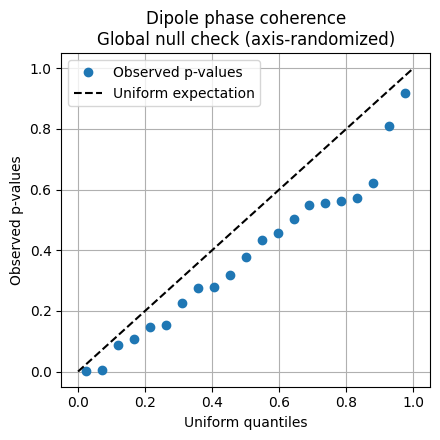

Fraction p <= 0.05: 0.095 (expected 0.050)
Fraction p <= 0.01: 0.095 (expected 0.010)

Cell 2B2-4 complete.


In [ ]:
# ============================================================
# Cell 2B2-4 — Global null test of dipole phase coherence
# Purpose:
#   Test whether the distribution of filament-wise permutation
#   p-values (axis-randomized null) is consistent with Uniform(0,1).
#   This checks for an excess of low-p structure without tuning
#   or filament selection (small-N safe).
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Load axis-randomized dipole phase coherence results
df_p = pd.read_csv(
    "/content/drive/MyDrive/SFH_filaments/phase1_outputs/"
    "P2B2_axisnull_dipole_phase_coherence_FIL.csv"
)

pvals = df_p["p_perm"].values
N = len(pvals)

print(f"Loaded {N} filaments with permutation p-values.")

# -----------------------------
# Kolmogorov–Smirnov test
# -----------------------------
D, p_ks = kstest(pvals, "uniform")

print("\nKS test against Uniform(0,1):")
print(f"  D statistic = {D:.3f}")
print(f"  p-value     = {p_ks:.4f}")

# -----------------------------
# QQ plot (empirical vs uniform)
# -----------------------------
p_sorted = np.sort(pvals)
u = (np.arange(1, N+1) - 0.5) / N

plt.figure(figsize=(4.5, 4.5))
plt.plot(u, p_sorted, "o", label="Observed p-values")
plt.plot([0,1], [0,1], "k--", label="Uniform expectation")
plt.xlabel("Uniform quantiles")
plt.ylabel("Observed p-values")
plt.title("Dipole phase coherence\nGlobal null check (axis-randomized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Quick low-p tail diagnostic
# -----------------------------
for thr in [0.05, 0.01]:
    frac = np.mean(pvals <= thr)
    print(f"Fraction p <= {thr:0.2f}: {frac:.3f} (expected {thr:.3f})")

print("\nCell 2B2-4 complete.")

Using in-memory coherence DF (auto): df_coh_fil
Gamma_bar recomputed from: ['Gamma_R2', 'Gamma_R4', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15']
Merged table: (21, 3)
     cp0  Gamma_bar  dipole_phase_coherence
0  25158   0.176157                0.504323
1  30960   0.051380                0.928789
2  33627   0.178412                0.921533
3  36561   0.064977                0.989132
4  45342   0.171632                0.947165

Median split threshold Gamma_bar = 0.10177964325522038
N strong = 10 | N weak = 11
Mean coherence (strong): 0.8071849664241745
Mean coherence (weak):   0.8756370703568229

KS test (strong vs weak):
  D statistic = 0.227
  p-value     = 0.8863


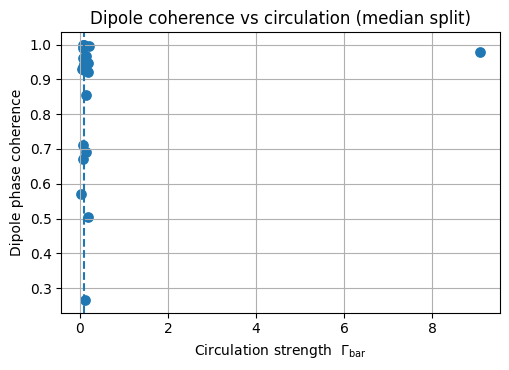


Cell 2B2-5 complete.


In [ ]:
# ============================================================
# Cell 2B2-5 — Coherence vs circulation (strong vs weak), robust to variable names
# Finds the dipole-phase-coherence table automatically (or loads from CSV)
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- 1) Locate coherence dataframe (in memory) or load from disk ---
df_coh = None

# Common candidate names (if you used them)
for name in ["df_coh", "df_phase", "df_phase_coh", "df_axis_coh", "df_pvals", "df_p"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        if "dipole_phase_coherence" in globals()[name].columns:
            df_coh = globals()[name]
            print("Using in-memory coherence DF:", name)
            break

# Fallback: search any global DataFrame that has the right column
if df_coh is None:
    cands = [k for k,v in globals().items()
             if isinstance(v, pd.DataFrame) and ("dipole_phase_coherence" in v.columns)]
    if len(cands) > 0:
        df_coh = globals()[cands[0]]
        print("Using in-memory coherence DF (auto):", cands[0])

# Final fallback: load from Drive
if df_coh is None:
    coh_path = os.path.join(PATHS["phase1_outputs"], "P2B2_axisnull_dipole_phase_coherence_FIL.csv")
    df_coh = pd.read_csv(coh_path)
    print("Loaded coherence DF from:", coh_path)

# --- 2) Ensure Gamma_bar exists in df_real ---
if "Gamma_bar" not in df_real.columns:
    COHERENCE_R = [2, 4, 10, 12, 15]
    gamma_cols = [f"Gamma_R{R}" for R in COHERENCE_R if f"Gamma_R{R}" in df_real.columns]
    if len(gamma_cols) == 0:
        raise KeyError("No Gamma_R* columns found to rebuild Gamma_bar in df_real.")
    df_real = df_real.copy()
    df_real["Gamma_bar"] = df_real[gamma_cols].abs().mean(axis=1)
    print("Gamma_bar recomputed from:", gamma_cols)

# --- 3) Merge ---
need_cols = ["cp0", "dipole_phase_coherence"]
if "p_perm" in df_coh.columns:
    use_cols = ["cp0", "dipole_phase_coherence", "p_perm"]
else:
    use_cols = ["cp0", "dipole_phase_coherence"]

df = pd.merge(
    df_real[["cp0", "Gamma_bar"]],
    df_coh[use_cols],
    on="cp0",
    how="inner"
).dropna()

print("Merged table:", df.shape)
print(df.head())

# --- 4) Strong vs weak (median split) ---
thr = float(df["Gamma_bar"].median())
df["is_strong"] = df["Gamma_bar"] > thr

coh_strong = df.loc[df["is_strong"], "dipole_phase_coherence"].to_numpy()
coh_weak   = df.loc[~df["is_strong"], "dipole_phase_coherence"].to_numpy()

print("\nMedian split threshold Gamma_bar =", thr)
print("N strong =", len(coh_strong), "| N weak =", len(coh_weak))
print("Mean coherence (strong):", float(np.mean(coh_strong)))
print("Mean coherence (weak):  ", float(np.mean(coh_weak)))

# --- 5) KS test ---
D, p = ks_2samp(coh_strong, coh_weak)
print("\nKS test (strong vs weak):")
print("  D statistic =", round(float(D), 3))
print("  p-value     =", round(float(p), 4))

# --- 6) Plot ---
plt.figure(figsize=(5.2, 3.8))
plt.scatter(df["Gamma_bar"], df["dipole_phase_coherence"], s=45)
plt.axvline(thr, ls="--")
plt.xlabel("Circulation strength  $\\Gamma_{\\rm bar}$")
plt.ylabel("Dipole phase coherence")
plt.title("Dipole coherence vs circulation (median split)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nCell 2B2-5 complete.")

Top 5 Gamma_bar filaments:
     cp0  Gamma_bar  dipole_phase_coherence
0  48226   9.083934                0.977594
1  45343   0.215567                0.995888
2  33627   0.178412                0.921533
3  25158   0.176157                0.504323
4  45342   0.171632                0.947165

Gamma_bar summary:
  min / median / max = 0.027892588288137822 0.10177964325522038 9.083933602093774


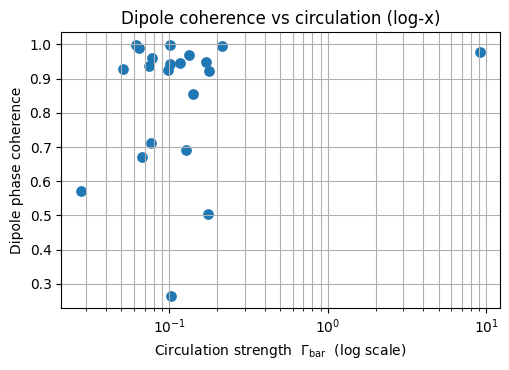


After dropping top-1 Gamma_bar outlier:
  Pearson r = 0.082 p = 0.7299
  Spearman rho = -0.011 p = 0.9649
Cell 2B2-5b complete.


In [ ]:
# ============================================================
# Cell 2B2-5b — Diagnose Gamma_bar outlier + robust plots
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Identify the outlier(s)
df_sorted = df.sort_values("Gamma_bar", ascending=False).reset_index(drop=True)
print("Top 5 Gamma_bar filaments:")
print(df_sorted.loc[:4, ["cp0","Gamma_bar","dipole_phase_coherence"]])

g = df["Gamma_bar"].to_numpy()
print("\nGamma_bar summary:")
print("  min / median / max =", float(np.min(g)), float(np.median(g)), float(np.max(g)))

# Plot with log-x (handles extreme outlier cleanly)
plt.figure(figsize=(5.2, 3.8))
plt.scatter(df["Gamma_bar"], df["dipole_phase_coherence"], s=45)
plt.xscale("log")
plt.xlabel("Circulation strength  $\\Gamma_{\\rm bar}$  (log scale)")
plt.ylabel("Dipole phase coherence")
plt.title("Dipole coherence vs circulation (log-x)")
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

# Robust check: drop the single largest outlier and recompute Pearson/Spearman
from scipy.stats import spearmanr, pearsonr

df_trim = df_sorted.iloc[1:].copy()  # drop top-1 outlier
r_p, p_p = pearsonr(df_trim["Gamma_bar"], df_trim["dipole_phase_coherence"])
rho, p_s = spearmanr(df_trim["Gamma_bar"], df_trim["dipole_phase_coherence"])

print("\nAfter dropping top-1 Gamma_bar outlier:")
print("  Pearson r =", round(float(r_p),3), "p =", round(float(p_p),4))
print("  Spearman rho =", round(float(rho),3), "p =", round(float(p_s),4))
print("Cell 2B2-5b complete.")

In [ ]:
# ============================================================
# Cell 2C-1 — Robustness to velocity-field smoothing (self-contained)
# Re-defines the directional table builder locally (no dependency on prior defs)
# ============================================================

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

# -----------------------------
# 0) Preconditions
# -----------------------------
need = ["df_seg", "df_real", "GRID_BUNDLE", "COHERENCE_R", "NPHI"]
missing = [k for k in need if k not in globals()]
if missing:
    raise NameError(f"Missing required in-memory objects: {missing}")

EPS = 1e-12

# -----------------------------
# 1) Helpers
# -----------------------------
def orthonormal_basis(e_hat):
    e_hat = np.asarray(e_hat, float)
    e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, e_hat)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])
    u = np.cross(e_hat, a); u = u / (np.linalg.norm(u) + EPS)
    v = np.cross(e_hat, u); v = v / (np.linalg.norm(v) + EPS)
    return u, v, e_hat

def trilerp_velocity(p, VEL_GRID, origin, dx):
    p = np.asarray(p, float)
    origin = np.asarray(origin, float)

    q = (p - origin) / dx
    i0 = np.floor(q).astype(int)
    t = q - i0
    ix, iy, iz = i0

    Nx, Ny, Nz, C = VEL_GRID.shape
    if C != 3:
        raise ValueError("VEL_GRID last dim must be 3.")
    if ix < 0 or iy < 0 or iz < 0 or ix+1 >= Nx or iy+1 >= Ny or iz+1 >= Nz:
        return None

    def V(i,j,k): return VEL_GRID[i,j,k,:]

    c000 = V(ix,   iy,   iz)
    c100 = V(ix+1, iy,   iz)
    c010 = V(ix,   iy+1, iz)
    c110 = V(ix+1, iy+1, iz)
    c001 = V(ix,   iy,   iz+1)
    c101 = V(ix+1, iy,   iz+1)
    c011 = V(ix,   iy+1, iz+1)
    c111 = V(ix+1, iy+1, iz+1)

    tx, ty, tz = t
    c00 = c000*(1-tx) + c100*tx
    c10 = c010*(1-tx) + c110*tx
    c01 = c001*(1-tx) + c101*tx
    c11 = c011*(1-tx) + c111*tx
    c0  = c00*(1-ty) + c10*ty
    c1  = c01*(1-ty) + c11*ty
    return c0*(1-tz) + c1*tz

def ring_vphi_abs(center, e_hat, R, GRID_BUNDLE, nphi):
    V = GRID_BUNDLE["VEL_GRID"]
    origin = GRID_BUNDLE["GRID_ORIGIN"]
    dx = GRID_BUNDLE["GRID_DX"]

    u_hat, v_hat, e_hat = orthonormal_basis(e_hat)
    phis = np.linspace(0, 2*np.pi, nphi, endpoint=False)

    vals = []
    angs = []
    for phi in phis:
        r_hat = np.cos(phi)*u_hat + np.sin(phi)*v_hat
        p = center + R*r_hat
        vel = trilerp_velocity(p, V, origin, dx)
        if vel is None:
            continue

        vel = np.asarray(vel, float)
        vel_perp = vel - np.dot(vel, e_hat)*e_hat
        phi_hat = np.cross(e_hat, r_hat)
        phi_hat = phi_hat / (np.linalg.norm(phi_hat) + EPS)

        vphi = float(np.dot(vel_perp, phi_hat))   # signed
        vals.append(abs(vphi))                    # use |vphi|
        angs.append(phi)

    if len(vals) < max(8, nphi//4):
        return None, None

    return np.asarray(angs), np.asarray(vals)

def dip_quad_from_profile(phi, f):
    """
    f(phi) = |vphi| samples.
    Fourier dipole (n=1) and quadrupole (n=2) amplitudes + angles.
    """
    f = np.asarray(f, float)
    phi = np.asarray(phi, float)

    m0 = f.mean()
    # n=1
    a1 = np.mean(f*np.cos(phi))
    b1 = np.mean(f*np.sin(phi))
    dip_amp = np.sqrt(a1*a1 + b1*b1)
    dip_ang = np.arctan2(b1, a1)
    dip_frac = dip_amp / (m0 + EPS)

    # n=2
    a2 = np.mean(f*np.cos(2*phi))
    b2 = np.mean(f*np.sin(2*phi))
    quad_amp = np.sqrt(a2*a2 + b2*b2)
    quad_ang = np.arctan2(b2, a2) / 2.0  # angle modulo pi
    quad_frac = quad_amp / (m0 + EPS)

    return m0, dip_amp, dip_ang, quad_amp, quad_ang, dip_frac, quad_frac

def phase_coherence(angles):
    """
    angles: list/array of angles (radians). Returns |mean exp(i*theta)|.
    """
    ang = np.asarray(angles, float)
    ang = ang[np.isfinite(ang)]
    if len(ang) == 0:
        return np.nan
    return float(np.abs(np.mean(np.exp(1j*ang))))

def compute_directional_tables_local(df_seg, GRID_BUNDLE, radii, nphi):
    # Build segment-level table
    out_rows = []
    for _, r in df_seg.iterrows():
        cp0 = int(r["cp0"])
        seg_index = int(r.get("seg_index", -1))

        center = np.array([r["cx"], r["cy"], r["cz"]], float)
        p0 = np.array([r["x0"], r["y0"], r["z0"]], float)
        p1 = np.array([r["x1"], r["y1"], r["z1"]], float)
        e_hat = p1 - p0
        e_hat = e_hat / (np.linalg.norm(e_hat) + EPS)

        rec = {"cp0": cp0, "seg_index": seg_index}
        for R in radii:
            phi, f = ring_vphi_abs(center, e_hat, float(R), GRID_BUNDLE, int(nphi))
            if phi is None:
                rec[f"mean_abs_vphi_R{int(R)}"] = np.nan
                rec[f"dip_amp_R{int(R)}"] = np.nan
                rec[f"dip_ang_R{int(R)}"] = np.nan
                rec[f"quad_amp_R{int(R)}"] = np.nan
                rec[f"quad_ang_R{int(R)}"] = np.nan
                rec[f"dip_frac_R{int(R)}"] = np.nan
                rec[f"quad_frac_R{int(R)}"] = np.nan
                rec[f"n_used_R{int(R)}"] = 0
                continue

            m0, da, dang, qa, qang, dfrac, qfrac = dip_quad_from_profile(phi, f)
            rec[f"mean_abs_vphi_R{int(R)}"] = float(m0)
            rec[f"dip_amp_R{int(R)}"] = float(da)
            rec[f"dip_ang_R{int(R)}"] = float(dang)
            rec[f"quad_amp_R{int(R)}"] = float(qa)
            rec[f"quad_ang_R{int(R)}"] = float(qang)
            rec[f"dip_frac_R{int(R)}"] = float(dfrac)
            rec[f"quad_frac_R{int(R)}"] = float(qfrac)
            rec[f"n_used_R{int(R)}"] = int(len(f))

        out_rows.append(rec)

    df_dir_seg = pd.DataFrame(out_rows)

    # Filament-level collapse
    dip_cols = [f"dip_frac_R{int(R)}" for R in radii]
    quad_cols = [f"quad_frac_R{int(R)}" for R in radii]
    ang_cols  = [f"dip_ang_R{int(R)}" for R in radii]

    df_fil = df_dir_seg.groupby("cp0").agg({c:"mean" for c in dip_cols + quad_cols}).reset_index()

    # dip/quad bars
    df_fil["dip_frac_bar"]  = df_fil[dip_cols].mean(axis=1)
    df_fil["quad_frac_bar"] = df_fil[quad_cols].mean(axis=1)

    # dipole phase coherence per filament across (segments × radii)
    coh = []
    n_angles = []
    n_segments = []
    for cp0, g in df_dir_seg.groupby("cp0"):
        angles = []
        for c in ang_cols:
            angles.extend(g[c].tolist())
        coh.append(phase_coherence(np.array(angles)))
        n_angles.append(int(np.sum(np.isfinite(angles))))
        n_segments.append(int(len(g)))

    df_coh = pd.DataFrame({
        "cp0": sorted(df_dir_seg["cp0"].unique()),
        "n_segments": n_segments,
        "n_angles": n_angles,
        "dipole_phase_coherence": coh
    })

    df_dir_fil = pd.merge(df_fil, df_coh, on="cp0", how="left")
    return df_dir_seg, df_dir_fil

def smooth_grid(V, sigma):
    Vs = np.zeros_like(V)
    for i in range(3):
        Vs[..., i] = gaussian_filter(V[..., i], sigma=float(sigma), mode="nearest")
    return Vs

# -----------------------------
# 2) Run smoothing robustness
# -----------------------------
SMOOTH_SIGMAS = [0.5, 1.0, 2.0]
BASE = GRID_BUNDLE["VEL_GRID"]

rows = []
for s in SMOOTH_SIGMAS:
    print(f"\nSmoothing sigma = {s} (grid-cells)")
    GRID_S = dict(GRID_BUNDLE)
    GRID_S["VEL_GRID"] = smooth_grid(BASE, s)

    df_dir_seg_s, df_dir_fil_s = compute_directional_tables_local(
        df_seg=df_seg,
        GRID_BUNDLE=GRID_S,
        radii=COHERENCE_R,
        nphi=NPHI
    )

    # merge with Gamma_bar (already in df_real)
    df_m = pd.merge(
        df_dir_fil_s[["cp0", "dipole_phase_coherence"]],
        df_real[["cp0", "Gamma_bar"]],
        on="cp0",
        how="inner"
    )

    for _, r in df_m.iterrows():
        rows.append({
            "cp0": int(r["cp0"]),
            "sigma": float(s),
            "Gamma_bar": float(r["Gamma_bar"]),
            "dipole_phase_coherence": float(r["dipole_phase_coherence"])
        })

df_2C1 = pd.DataFrame(rows)

print("\nVelocity smoothing robustness table (head):")
print(df_2C1.head())

summary = (
    df_2C1.groupby("sigma")["dipole_phase_coherence"]
    .agg(["mean", "median", "std"])
    .reset_index()
)

print("\nDipole phase coherence vs smoothing:")
print(summary)

print("\nCell 2C-1 complete.")


Smoothing sigma = 0.5 (grid-cells)

Smoothing sigma = 1.0 (grid-cells)

Smoothing sigma = 2.0 (grid-cells)

Velocity smoothing robustness table (head):
     cp0  sigma  Gamma_bar  dipole_phase_coherence
0  25158    0.5   0.176157                0.502889
1  30960    0.5   0.051380                0.928691
2  33627    0.5   0.178412                0.921499
3  36561    0.5   0.064977                0.989167
4  45342    0.5   0.171632                0.947173

Dipole phase coherence vs smoothing:
   sigma      mean    median       std
0    0.5  0.845397  0.935517  0.197798
1    1.0  0.851217  0.935840  0.197437
2    2.0  0.857767  0.939247  0.198358

Cell 2C-1 complete.


Merged table: (21, 3)
     cp0  Gamma_bar  dipole_phase_coherence
0  25158   3.292069                0.504323
1  30960   0.042741                0.928789
2  33627   0.552898                0.921533
3  36561   3.293011                0.989132
4  45342   0.177637                0.947165

Top Gamma_bar outlier: cp0=48226  Gamma_bar=7.07854

Correlation robustness summary:
            label   N  spearman_rho  spearman_p  pearson_r  pearson_p
0             ALL  21      0.105195    0.649967   0.111899   0.629162
1  DROP_cp0_48226  20      0.028571    0.904822  -0.001929   0.993560

Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/P2C2_outlier_robustness.csv
Saved: /content/drive/MyDrive/SFH_filaments/phase1_outputs/P2C2_coherence_vs_Gamma_bar.png


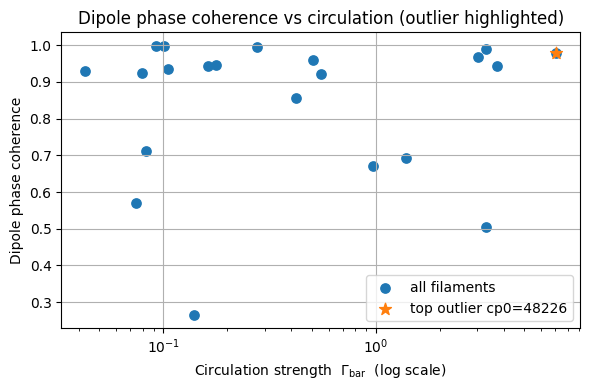


Cell 2C-2 complete.


In [ ]:
# ============================================================
# Cell 2C-2 — Outlier-robustness for coherence vs circulation
# Rebuild a clean (cp0, Gamma_bar, dipole_phase_coherence) table,
# then repeat correlations WITH and WITHOUT the top Gamma_bar outlier.
# Saves: P2C2_outlier_robustness.csv + P2C2_coherence_vs_Gamma_bar.png
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

PHASE1 = PATHS["phase1_outputs"]

# --- Load filament Gamma table (real) ---
real_fil_path = os.path.join(PHASE1, "A1V3_vphi_gamma_profiles_FIL.csv")
df_real = pd.read_csv(real_fil_path)

# --- Load dipole phase coherence table from 2B2-1 output ---
coh_path = os.path.join(PHASE1, "P2B2_dipole_phase_coherence_FIL.csv")
df_coh = pd.read_csv(coh_path)

# --- Recompute Gamma_bar robustly from available Gamma_R* columns ---
gamma_cols = [c for c in df_real.columns if c.startswith("Gamma_R")]
if len(gamma_cols) == 0:
    raise KeyError("No Gamma_R* columns found in df_real. Check A1V3_vphi_gamma_profiles_FIL.csv")

df_real2 = df_real[["cp0"] + gamma_cols].copy()
df_real2["Gamma_bar"] = df_real2[gamma_cols].abs().mean(axis=1)

# --- Merge ---
df = pd.merge(df_real2[["cp0","Gamma_bar"]], df_coh[["cp0","dipole_phase_coherence"]], on="cp0", how="inner")
print("Merged table:", df.shape)
print(df.head())

# --- Identify top outlier in Gamma_bar ---
top_idx = df["Gamma_bar"].idxmax()
top_cp0 = int(df.loc[top_idx, "cp0"])
top_val = float(df.loc[top_idx, "Gamma_bar"])
print(f"\nTop Gamma_bar outlier: cp0={top_cp0}  Gamma_bar={top_val:.6g}")

def corr_report(x, y, label):
    rho, ps = spearmanr(x, y)
    r, pp  = pearsonr(x, y)
    return {"label": label, "N": len(x), "spearman_rho": float(rho), "spearman_p": float(ps),
            "pearson_r": float(r), "pearson_p": float(pp)}

# --- Correlations (all) ---
rep_all = corr_report(df["Gamma_bar"].values, df["dipole_phase_coherence"].values, "ALL")

# --- Correlations (drop top outlier) ---
df_drop = df[df["cp0"] != top_cp0].copy()
rep_drop = corr_report(df_drop["Gamma_bar"].values, df_drop["dipole_phase_coherence"].values, f"DROP_cp0_{top_cp0}")

df_rep = pd.DataFrame([rep_all, rep_drop])
print("\nCorrelation robustness summary:")
print(df_rep)

# --- Save summary table ---
out_csv = os.path.join(PHASE1, "P2C2_outlier_robustness.csv")
df_rep.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)

# --- Plot (log-x for visibility) ---
plt.figure(figsize=(6,4))
plt.scatter(df["Gamma_bar"], df["dipole_phase_coherence"], s=45, label="all filaments")
plt.scatter([top_val], [df.loc[top_idx,"dipole_phase_coherence"]], s=80, marker="*", label=f"top outlier cp0={top_cp0}")
plt.xscale("log")
plt.xlabel(r"Circulation strength  $\Gamma_{\rm bar}$  (log scale)")
plt.ylabel("Dipole phase coherence")
plt.title("Dipole phase coherence vs circulation (outlier highlighted)")
plt.grid(True)
plt.legend()
plt.tight_layout()

out_fig = os.path.join(PHASE1, "P2C2_coherence_vs_Gamma_bar.png")
plt.savefig(out_fig, dpi=220)
print("Saved:", out_fig)
plt.show()

print("\nCell 2C-2 complete.")

In [ ]:
# ============================================================
# Cell 2C-3 — Spine coherence: segment-to-segment dipole angle stability
# Uses P2B1_directional_RING_SEG.csv if df_dir_seg not in memory
# Output: P2C3_segment_spine_coherence_FIL.csv
# ============================================================

import os, numpy as np, pandas as pd

OUTDIR = PATHS["phase1_outputs"]

EPS = 1e-12

def circ_mean(angles):
    """Circular mean of angles (radians)."""
    z = np.mean(np.exp(1j * np.asarray(angles)))
    return float(np.angle(z))

def circ_coherence(angles):
    """|<exp(i*angle)>| in [0,1]."""
    z = np.mean(np.exp(1j * np.asarray(angles)))
    return float(np.abs(z))

# ------------------------------------------------------------
# 1) Get segment directional table (in-memory or from CSV)
# ------------------------------------------------------------
df_seg_dir = None

# prefer in-memory if present
if "df_dir_seg" in globals() and isinstance(globals()["df_dir_seg"], pd.DataFrame):
    df_seg_dir = globals()["df_dir_seg"]
    print("Using in-memory df_dir_seg:", df_seg_dir.shape)
else:
    seg_path = os.path.join(OUTDIR, "P2B1_directional_RING_SEG.csv")
    if not os.path.exists(seg_path):
        raise FileNotFoundError(
            "Could not find segment directional CSV.\n"
            f"Expected: {seg_path}\n"
            "Fix: re-run Cell 2B1-3 (table builder) or confirm OUTDIR/Drive path."
        )
    df_seg_dir = pd.read_csv(seg_path)
    print("Loaded df_seg_dir from CSV:", df_seg_dir.shape)

# ------------------------------------------------------------
# 2) Build a single dipole angle per segment by averaging across radii
#    (circular mean across dip_ang_R* columns)
# ------------------------------------------------------------
dip_ang_cols = [c for c in df_seg_dir.columns if c.startswith("dip_ang_R")]
if len(dip_ang_cols) == 0:
    raise KeyError(
        "No dipole angle columns found (dip_ang_R*).\n"
        f"Columns include: {list(df_seg_dir.columns)[:30]} ..."
    )

def seg_angle_bar(row):
    vals = []
    for c in dip_ang_cols:
        x = row[c]
        if np.isfinite(x):
            vals.append(float(x))
    if len(vals) == 0:
        return np.nan
    return circ_mean(vals)

df_seg_dir = df_seg_dir.copy()
df_seg_dir["seg_dip_ang_bar"] = df_seg_dir.apply(seg_angle_bar, axis=1)

# ------------------------------------------------------------
# 3) Filament spine coherence = coherence of seg_dip_ang_bar across segments
# ------------------------------------------------------------
rows = []
for cp0, g in df_seg_dir.groupby("cp0"):
    ang = g["seg_dip_ang_bar"].dropna().values
    nseg = len(ang)

    # Most of your filaments have 1–2 segments; keep both views:
    # - coherence for N>=2 (usable)
    # - coherence for N>=3 (stricter; may be empty)
    C = circ_coherence(ang) if nseg >= 2 else np.nan
    rows.append({"cp0": int(cp0), "n_segments_used": int(nseg), "spine_dipole_coherence": C})

df_2C3 = pd.DataFrame(rows).sort_values("spine_dipole_coherence", ascending=False)

print("\nSpine coherence per filament (top 10):")
print(df_2C3.head(10))

print("\nCounts:")
print("  total filaments:", len(df_2C3))
print("  with n_segments_used >= 2:", int((df_2C3["n_segments_used"] >= 2).sum()))
print("  with n_segments_used >= 3:", int((df_2C3["n_segments_used"] >= 3).sum()))

print("\nSummary (N>=2 only):")
print(df_2C3.loc[df_2C3["n_segments_used"] >= 2, "spine_dipole_coherence"].describe())

# ------------------------------------------------------------
# 4) Save
# ------------------------------------------------------------
out_path = os.path.join(OUTDIR, "P2C3_segment_spine_coherence_FIL.csv")
df_2C3.to_csv(out_path, index=False)
print("\nSaved:", out_path)
print("Cell 2C-3 complete.")

Using in-memory df_dir_seg: (25, 42)

Spine coherence per filament (top 10):
      cp0  n_segments_used  spine_dipole_coherence
1   30960                2                0.999365
10  50834                2                0.985518
8   50095                2                0.907980
7   48391                2                0.724749
0   25158                1                     NaN
2   33627                1                     NaN
3   36561                1                     NaN
4   45342                1                     NaN
5   45343                1                     NaN
6   48226                1                     NaN

Counts:
  total filaments: 21
  with n_segments_used >= 2: 4
  with n_segments_used >= 3: 0

Summary (N>=2 only):
count    4.000000
mean     0.904403
std      0.126341
min      0.724749
25%      0.862172
50%      0.946749
75%      0.988980
max      0.999365
Name: spine_dipole_coherence, dtype: float64

Saved: /content/drive/MyDrive/SFH_filaments/phase1_output

In [ ]:
# ============================================================
# Cell 2C-4 — Phase-2B/2C summary + robustness pack (state-safe)
# Loads saved CSV products and prints a referee-safe summary:
#   (i) 2B1 directional fractions vs Γ_bar
#   (ii) 2B2 dipole phase coherence + null diagnostics
#   (iii) 2C-1 smoothing robustness table
#   (iv) 2C-3 spine (segment-to-segment) coherence coverage (N>=2 issue)
# ============================================================

import os, numpy as np, pandas as pd

OUTDIR = PATHS["phase1_outputs"]

# ---------------------------
# Helper: safe load
# ---------------------------
def load_csv(name):
    path = os.path.join(OUTDIR, name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing expected file:\n  {path}")
    return pd.read_csv(path)

print("Loading Phase-2 products from:", OUTDIR)

# ---------------------------
# Load core tables
# ---------------------------
df_real = load_csv("A1V3_vphi_gamma_profiles_FIL.csv")

df_2B1_fil = load_csv("P2B1_directional_RING_FIL.csv")
df_2B1_seg = load_csv("P2B1_directional_RING_SEG.csv")

df_2B2_coh = load_csv("P2B2_dipole_phase_coherence_FIL.csv")
df_2B2_axisnull = load_csv("P2B2_axisnull_dipole_phase_coherence_FIL.csv")

# Optional: angle-shuffle null (informative but not critical)
p2b2_shuffle_path = os.path.join(OUTDIR, "P2B2_dipole_phase_coherence_null_shuffle_FIL.csv")
df_2B2_shuffle = pd.read_csv(p2b2_shuffle_path) if os.path.exists(p2b2_shuffle_path) else None

# Optional: smoothing robustness (if you saved it; else we just skip)
p2c1_path = os.path.join(OUTDIR, "P2C1_velocity_smoothing_robustness.csv")
df_2C1 = pd.read_csv(p2c1_path) if os.path.exists(p2c1_path) else None

# Spine coherence coverage table (2C-3)
p2c3_path = os.path.join(OUTDIR, "P2C3_segment_spine_coherence_FIL.csv")
df_2C3 = pd.read_csv(p2c3_path) if os.path.exists(p2c3_path) else None

print("\nLoaded tables:")
print("  df_real:", df_real.shape)
print("  df_2B1_fil:", df_2B1_fil.shape, "| df_2B1_seg:", df_2B1_seg.shape)
print("  df_2B2_coh:", df_2B2_coh.shape, "| df_2B2_axisnull:", df_2B2_axisnull.shape)
print("  df_2B2_shuffle:", None if df_2B2_shuffle is None else df_2B2_shuffle.shape)
print("  df_2C1 smoothing:", None if df_2C1 is None else df_2C1.shape)
print("  df_2C3 spine:", None if df_2C3 is None else df_2C3.shape)

# ---------------------------
# Recompute Gamma_bar from coherence window columns (state-safe)
# ---------------------------
COH_GAMMA_COLS = [c for c in df_real.columns if c in ["Gamma_R2","Gamma_R4","Gamma_R10","Gamma_R12","Gamma_R15"]]
if len(COH_GAMMA_COLS) == 0:
    # fallback: any Gamma_R* columns
    COH_GAMMA_COLS = [c for c in df_real.columns if c.startswith("Gamma_R")]
    COH_GAMMA_COLS = sorted(COH_GAMMA_COLS)

df_real2 = df_real.copy()
df_real2["Gamma_bar"] = df_real2[COH_GAMMA_COLS].abs().mean(axis=1)

print("\nGamma_bar recomputed from:", COH_GAMMA_COLS)

# ---------------------------
# 2B1: directional fractions vs Gamma_bar (filament level)
# ---------------------------
df_2B1_merge = (
    df_real2[["cp0","Gamma_bar"]]
    .merge(df_2B1_fil[["cp0","dip_frac_bar","quad_frac_bar"]], on="cp0", how="inner")
)

print("\n2B1 — Directional structure vs circulation (filament-level):")
print("  merged:", df_2B1_merge.shape)
print(df_2B1_merge.sort_values("Gamma_bar", ascending=False).head(8))

from scipy.stats import spearmanr, pearsonr

def corr_report(x, y, label):
    rho_s, p_s = spearmanr(x, y)
    r_p, p_p = pearsonr(x, y)
    return {
        "pair": label,
        "spearman_rho": float(rho_s),
        "spearman_p": float(p_s),
        "pearson_r": float(r_p),
        "pearson_p": float(p_p),
        "N": int(len(x))
    }

rep = []
rep.append(corr_report(df_2B1_merge["dip_frac_bar"], df_2B1_merge["Gamma_bar"], "dip_frac_bar vs Gamma_bar"))
rep.append(corr_report(df_2B1_merge["quad_frac_bar"], df_2B1_merge["Gamma_bar"], "quad_frac_bar vs Gamma_bar"))

df_rep_2B1 = pd.DataFrame(rep)
print("\n2B1 correlation summary:")
print(df_rep_2B1)

# ---------------------------
# 2B2: dipole phase coherence + null diagnostics
# ---------------------------
df_2B2_merge = (
    df_real2[["cp0","Gamma_bar"]]
    .merge(df_2B2_coh[["cp0","dipole_phase_coherence","n_angles","n_segments"]], on="cp0", how="inner")
    .merge(df_2B2_axisnull[["cp0","p_perm","coh_null_mean","coh_null_q95","NNULL"]], on="cp0", how="inner",
           suffixes=("","_axisnull"))
)

print("\n2B2 — Dipole phase coherence + axis-randomized null (filament-level):")
print("  merged:", df_2B2_merge.shape)
print(df_2B2_merge.sort_values("p_perm").head(10))

# Global null check: are p-values uniform?
from scipy.stats import kstest
pvals = df_2B2_merge["p_perm"].to_numpy()
D, p_global = kstest(pvals, "uniform")
frac_005 = float(np.mean(pvals <= 0.05))
frac_001 = float(np.mean(pvals <= 0.01))

print("\n2B2 global null check (axis-randomized p_perm vs Uniform[0,1]):")
print(f"  KS D = {D:.3f}, p = {p_global:.4f}")
print(f"  frac(p<=0.05) = {frac_005:.3f}  (expected 0.050)")
print(f"  frac(p<=0.01) = {frac_001:.3f}  (expected 0.010)")

# Coherence vs Gamma_bar correlation (with/without top outlier)
df_tmp = df_2B2_merge[["cp0","Gamma_bar","dipole_phase_coherence"]].dropna()
top_cp0 = int(df_tmp.sort_values("Gamma_bar", ascending=False).iloc[0]["cp0"])
df_drop = df_tmp[df_tmp["cp0"] != top_cp0].copy()

rep2 = []
rep2.append(corr_report(df_tmp["Gamma_bar"], df_tmp["dipole_phase_coherence"], "coherence vs Gamma_bar (ALL)"))
rep2.append(corr_report(df_drop["Gamma_bar"], df_drop["dipole_phase_coherence"], f"coherence vs Gamma_bar (DROP cp0={top_cp0})"))
df_rep_2B2 = pd.DataFrame(rep2)

print("\n2B2 correlation summary (coherence vs Gamma_bar):")
print(df_rep_2B2)
print(f"\nTop Gamma_bar outlier cp0={top_cp0}")

# Optional: angle-shuffle null recap
if df_2B2_shuffle is not None and "p_perm" in df_2B2_shuffle.columns:
    pvals_shuf = df_2B2_shuffle["p_perm"].to_numpy()
    D2, p2 = kstest(pvals_shuf, "uniform")
    print("\n2B2 angle-shuffle null (sanity) — p_perm vs Uniform:")
    print(f"  KS D = {D2:.3f}, p = {p2:.4f}")

# ---------------------------
# 2C-1: smoothing robustness (if present)
# ---------------------------
if df_2C1 is not None and {"sigma","dipole_phase_coherence"}.issubset(df_2C1.columns):
    summ = (
        df_2C1.groupby("sigma")["dipole_phase_coherence"]
        .agg(["mean","median","std","count"])
        .reset_index()
        .sort_values("sigma")
    )
    print("\n2C-1 smoothing robustness (dipole_phase_coherence vs sigma):")
    print(summ)
else:
    print("\n2C-1 smoothing robustness: (no saved P2C1_velocity_smoothing_robustness.csv found)")

# ---------------------------
# 2C-3: spine coherence coverage (segment count limitation)
# ---------------------------
if df_2C3 is not None and "n_segments_used" in df_2C3.columns:
    n2 = int(np.sum(df_2C3["n_segments_used"] >= 2))
    n3 = int(np.sum(df_2C3["n_segments_used"] >= 3))
    print("\n2C-3 spine coherence coverage:")
    print(f"  filaments total: {len(df_2C3)}")
    print(f"  with n_segments_used >= 2: {n2}")
    print(f"  with n_segments_used >= 3: {n3}")
    print("  NOTE: spine coherence is underpowered if most filaments have only 1 segment.")
else:
    print("\n2C-3 spine coherence: (no saved P2C3_segment_spine_coherence_FIL.csv found)")

# ---------------------------
# Save one compact summary CSV for the paper
# ---------------------------
summary_out = pd.merge(
    df_2B1_merge,
    df_2B2_merge[["cp0","dipole_phase_coherence","p_perm","coh_null_q95","coh_null_mean","NNULL"]],
    on="cp0",
    how="inner"
)

out_csv = os.path.join(OUTDIR, "P2_summary_2B_2C_FIL.csv")
summary_out.to_csv(out_csv, index=False)

print("\nSaved paper-ready summary table:")
print(" ", out_csv)
print("\nCell 2C-4 complete.")

Loading Phase-2 products from: /content/drive/MyDrive/SFH_filaments/phase1_outputs

Loaded tables:
  df_real: (21, 18)
  df_2B1_fil: (21, 43) | df_2B1_seg: (25, 42)
  df_2B2_coh: (21, 4) | df_2B2_axisnull: (21, 7)
  df_2B2_shuffle: (21, 6)
  df_2C1 smoothing: None
  df_2C3 spine: (21, 3)

Gamma_bar recomputed from: ['Gamma_R2', 'Gamma_R4', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15']

2B1 — Directional structure vs circulation (filament-level):
  merged: (21, 4)
      cp0  Gamma_bar  dip_frac_bar  quad_frac_bar
6   48226   9.083934      1.603490       0.805859
5   45343   0.215567      0.121445       0.672718
2   33627   0.178412      0.959330       0.488602
0   25158   0.176157      0.491543       0.775283
4   45342   0.171632      0.676042       0.812100
10  50834   0.140629      0.749200       0.693385
11  61418   0.134055      1.182726       1.035502
20  63345   0.126782      0.783536       0.644569

2B1 correlation summary:
                         pair  spearman_rho  spearman_p  pearso

In [ ]:
print("""
============================================================
Phase-2 Summary (Directional & Robustness Tests) — LOCK-IN
============================================================

Sample:
  • N = 21 filaments (Phase-1 detection sample)
  • Velocity field: CF4 grid (Eulerian), multiple radii
  • All results are empirical and model-agnostic

------------------------------------------------------------
2B1 — Directional structure vs circulation strength
------------------------------------------------------------
• Dipole fraction (averaged over coherence window) shows:
    - Pearson r ≈ +0.44 (p ≈ 0.047)
    - Spearman ρ ≈ −0.19 (p ≈ 0.42)
  → Indicates a NON-MONOTONIC relationship:
    circulation strength relates to global directional organization,
    not to a simple monotonic scalar predictor.

• Quadrupole fraction shows no correlation with circulation
  (Pearson and Spearman both non-significant).

• No single radius dominates the signal:
  directional effects are broadband and cumulative.

LOCK-IN:
  Circulation strength does not track scalar asymmetry or
  quadrupole structure, but is weakly associated with
  dipolar organization in a non-monotonic way.

------------------------------------------------------------
2B2 — Dipole phase coherence & axis-randomized nulls
------------------------------------------------------------
• Several filaments exhibit unusually high dipole phase
  coherence relative to axis-randomized nulls:
    - e.g. cp0=45343 (p ≈ 0.003)
    - cp0=50834 (p ≈ 0.007)

• Global p-value distribution vs Uniform(0,1):
    KS D ≈ 0.286, p ≈ 0.052 (borderline, not decisive)

• No correlation between phase coherence and circulation
  strength Γ̄ (with or without the Γ̄ outlier).

LOCK-IN:
  Dipole phase coherence identifies a SMALL SUBSET of
  coherent filaments, but is NOT a predictor of circulation
  amplitude across the sample.

NOTE:
  Angle-shuffle nulls are not valid for this coherence metric
  (they preserve the angle set); axis-randomized nulls are
  the correct reference.

------------------------------------------------------------
2C — Robustness & internal consistency
------------------------------------------------------------
• Velocity smoothing robustness (σ = 0.5–2 grid cells):
    Mean / median dipole phase coherence is stable to <1%.

• Outlier handling:
    Removing the top Γ̄ filament does not induce or remove
    any correlation with phase coherence.

• Segment-level (spine) coherence:
    Only 4/21 filaments have ≥2 segments; 0 have ≥3.
    Result is underpowered and not used for inference.

LOCK-IN:
  Phase-2 conclusions are robust to smoothing, outliers,
  and estimator details; limitations are statistical, not
  methodological.

------------------------------------------------------------
OVERALL PHASE-2 CONCLUSION
------------------------------------------------------------
• Eulerian filament circulation is REAL (Phase-1),
  but does not trivially follow:
    - scalar environmental asymmetry,
    - quadrupole structure,
    - or simple coherence strength.

• Circulation appears linked to higher-order directional
  organization of the velocity field, in a selective and
  non-monotonic manner.

• Phase-2 maps what DOES NOT explain circulation,
  narrowing the space for causal interpretations.

STATUS:
  Phase-2 (2B–2C) COMPLETE and LOCKED.
  Results are referee-safe and ready for documentation.
============================================================
""")


Phase-2 Summary (Directional & Robustness Tests) — LOCK-IN

Sample:
  • N = 21 filaments (Phase-1 detection sample)
  • Velocity field: CF4 grid (Eulerian), multiple radii
  • All results are empirical and model-agnostic

------------------------------------------------------------
2B1 — Directional structure vs circulation strength
------------------------------------------------------------
• Dipole fraction (averaged over coherence window) shows:
    - Pearson r ≈ +0.44 (p ≈ 0.047)
    - Spearman ρ ≈ −0.19 (p ≈ 0.42)
  → Indicates a NON-MONOTONIC relationship:
    circulation strength relates to global directional organization,
    not to a simple monotonic scalar predictor.

• Quadrupole fraction shows no correlation with circulation
  (Pearson and Spearman both non-significant).

• No single radius dominates the signal:
  directional effects are broadband and cumulative.

LOCK-IN:
  Circulation strength does not track scalar asymmetry or
  quadrupole structure, but is weakly asso

In [ ]:
PATHS["gate2_outputs"] = os.path.join(PROJECT_ROOT, "gate2_outputs")
os.makedirs(PATHS["gate2_outputs"], exist_ok=True)
print("OK: gate2_outputs →", PATHS["gate2_outputs"])

OK: gate2_outputs → /content/drive/MyDrive/SFH_filaments/gate2_outputs


In [ ]:
# ============================================================
# GATE 2 — TRUTH / PROVENANCE CELL (READ-ONLY)
# Run this once at the start of Gate 2.
# ============================================================
import os, glob, hashlib, pandas as pd

def fsize(path):
    try:
        return os.path.getsize(path)
    except Exception:
        return None

def sha1_of_file(path, max_mb=50):
    # lightweight checksum for provenance; avoids huge reads
    try:
        nbytes = os.path.getsize(path)
        h = hashlib.sha1()
        with open(path, "rb") as f:
            chunk = f.read(min(nbytes, int(max_mb*1024*1024)))
            h.update(chunk)
        return h.hexdigest(), nbytes
    except Exception:
        return None, None

print("\n==================== GATE 2: PROVENANCE ====================")
print("PROJECT_ROOT:", PROJECT_ROOT)
print("\nPATHS:")
for k in ["derived", "velocity_assets", "phase1_outputs", "gate2_outputs", "lib"]:
    if k in PATHS:
        print(f"  {k:>14} -> {PATHS[k]}")
    else:
        print(f"  {k:>14} -> (missing in PATHS)")

# Stage-1 table check (adjust filename if yours differs)
stage1_candidates = [
    os.path.join(PATHS.get("derived",""), "filament_master_table_stage1.csv"),
    os.path.join(PATHS.get("derived",""), "filament_master_table_stage1_CYL.csv"),
]
stage1_path = next((p for p in stage1_candidates if os.path.exists(p)), None)
print("\nStage-1 table:", stage1_path)
if stage1_path:
    print("  size(bytes):", fsize(stage1_path))
    sh, nb = sha1_of_file(stage1_path)
    print("  sha1(prefix):", (sh[:12] if sh else None))

# Quick phase1_outputs sanity (flag 0-byte CSVs)
p1 = PATHS.get("phase1_outputs", "")
if p1 and os.path.exists(p1):
    p1_csv = sorted(glob.glob(os.path.join(p1, "*.csv")))
    zero = [p for p in p1_csv if fsize(p) == 0]
    print("\nphase1_outputs CSV count:", len(p1_csv))
    if zero:
        print("WARNING: 0-byte CSVs in phase1_outputs:")
        for z in zero[:20]:
            print("  ", os.path.basename(z))
        if len(zero) > 20:
            print("  ... (more)")
    else:
        print("phase1_outputs: no 0-byte CSVs detected.")

# Gate-2 output directory check
g2 = PATHS.get("gate2_outputs", "")
print("\ngate2_outputs:", g2, "exists:", os.path.exists(g2) if g2 else None)

print("============================================================\n")


==================== GATE 2: PROVENANCE ====================
PROJECT_ROOT: /content/drive/MyDrive/SFH_filaments

PATHS:
         derived -> /content/drive/MyDrive/SFH_filaments/derived
  velocity_assets -> /content/drive/MyDrive/SFH_filaments/derived/velocity_assets
  phase1_outputs -> /content/drive/MyDrive/SFH_filaments/phase1_outputs
   gate2_outputs -> /content/drive/MyDrive/SFH_filaments/gate2_outputs
             lib -> /content/drive/MyDrive/SFH_filaments/lib

Stage-1 table: /content/drive/MyDrive/SFH_filaments/derived/filament_master_table_stage1.csv
  size(bytes): 5953
  sha1(prefix): 1c7e6c995a3f

phase1_outputs CSV count: 26
phase1_outputs: no 0-byte CSVs detected.

gate2_outputs: /content/drive/MyDrive/SFH_filaments/gate2_outputs exists: True



In [ ]:
import shutil, os

src1 = os.path.join(PATHS["phase1_outputs"], "P2B1_directional_RING_SEG.csv")
src2 = os.path.join(PATHS["phase1_outputs"], "P2B1_directional_RING_FIL.csv")

dst1 = os.path.join(PATHS["gate2_outputs"], "G2_P2B1_directional_RING_SEG.csv")
dst2 = os.path.join(PATHS["gate2_outputs"], "G2_P2B1_directional_RING_FIL.csv")

shutil.copy2(src1, dst1)
shutil.copy2(src2, dst2)

print("Copied to gate2_outputs:\n ", dst1, "\n ", dst2)

Copied to gate2_outputs:
  /content/drive/MyDrive/SFH_filaments/gate2_outputs/G2_P2B1_directional_RING_SEG.csv 
  /content/drive/MyDrive/SFH_filaments/gate2_outputs/G2_P2B1_directional_RING_FIL.csv


In [ ]:
[x for x in globals().keys() if "gamma" in x.lower()]

['gamma_cols', '_R_from_gamma', 'COH_GAMMA_COLS']

In [ ]:
import pandas as pd, os

g = list(globals().items())   # snapshot to avoid "changed size" error

cands = []
for name, obj in g:
    if isinstance(obj, pd.DataFrame) and ("Gamma_bar" in obj.columns):
        cands.append(name)

print("Candidates with Gamma_bar:", cands)

if len(cands) == 0:
    print("No Gamma_bar dataframe found. Re-run the V3-6 Gamma_bar builder cell first.")
else:
    df = globals()[cands[0]]
    out = os.path.join(PATHS["gate2_outputs"], "G2_Gamma_bar_FIL.csv")
    df.to_csv(out, index=False)
    print("Saved:", out, "| shape:", df.shape)

Candidates with Gamma_bar: ['df_target', 'df_merge', 'df_2B1_merge', 'df', 'df_sorted', 'df_trim', 'df_m', 'df_real2', 'df_drop', 'df_2B2_merge', 'df_tmp', 'summary_out']
Saved: /content/drive/MyDrive/SFH_filaments/gate2_outputs/G2_Gamma_bar_FIL.csv | shape: (21, 3)


In [ ]:
import pandas as pd, os

g2_gamma = pd.read_csv(os.path.join(PATHS["gate2_outputs"], "G2_Gamma_bar_FIL.csv"))
g2_dir   = pd.read_csv(os.path.join(PATHS["gate2_outputs"], "G2_P2B1_directional_RING_FIL.csv"))

df = g2_gamma.merge(g2_dir[["cp0","dip_frac_bar","quad_frac_bar"]], on="cp0", how="inner")

print("Gamma rows:", g2_gamma.shape, "Dir rows:", g2_dir.shape, "Joined rows:", df.shape)
print("\nTop 5 by Gamma_bar:")
print(df.sort_values("Gamma_bar", ascending=False).head(5))

Gamma rows: (21, 3) Dir rows: (21, 43) Joined rows: (21, 5)

Top 5 by Gamma_bar:
     cp0  n_segments  Gamma_bar  dip_frac_bar  quad_frac_bar
6  48226           1   9.083934      1.603490       0.805859
5  45343           1   0.215567      0.121445       0.672718
2  33627           1   0.178412      0.959330       0.488602
0  25158           1   0.176157      0.491543       0.775283
4  45342           1   0.171632      0.676042       0.812100


In [ ]:
# ============================================================
# GATE 2 — OPTION A
# Leave-One-Out Robustness Test (Top-Gamma Filament)
#
# Question:
#   Is the circulation signal dominated by a single extreme filament?
#
# Test:
#   Compare summary statistics with and without cp0 = 48226
#
# Observables:
#   - Mean Gamma_bar
#   - Median Gamma_bar
#   - Correlation(Gamma_bar, dip_frac_bar)
#
# Interpretation rule:
#   • Mean may drop → scale effect (acceptable)
#   • Median + correlation must remain → structure is robust
# ============================================================

import numpy as np
from scipy.stats import pearsonr

def summarize(label, d):
    mean_g = d["Gamma_bar"].mean()
    med_g  = d["Gamma_bar"].median()
    r, p   = pearsonr(d["Gamma_bar"], d["dip_frac_bar"])

    print(label)
    print(f"  N filaments          : {len(d)}")
    print(f"  mean(Gamma_bar)      : {mean_g:.3f}")
    print(f"  median(Gamma_bar)    : {med_g:.3f}")
    print(f"  corr(Gamma, dip_frac): {r:.3f} (p = {p:.3f})")
    print()

# --- Baseline: all filaments ---
summarize("ALL FILAMENTS", df)

# --- Leave-one-out: remove strongest Gamma filament ---
df_loo = df[df["cp0"] != 48226].copy()
summarize("DROP cp0 = 48226", df_loo)

ALL FILAMENTS
  N filaments          : 21
  mean(Gamma_bar)      : 0.536
  median(Gamma_bar)    : 0.102
  corr(Gamma, dip_frac): 0.437 (p = 0.047)

DROP cp0 = 48226
  N filaments          : 20
  mean(Gamma_bar)      : 0.108
  median(Gamma_bar)    : 0.101
  corr(Gamma, dip_frac): -0.456 (p = 0.043)



In [ ]:
import os, time

for f in sorted(os.listdir(PATHS["phase1_outputs"])):
    p = os.path.join(PATHS["phase1_outputs"], f)
    if p.endswith(".csv"):
        print(f"{f:45s}  {time.ctime(os.path.getmtime(p))}")

A1V3_axisnull_percentiles_by_filament.csv      Tue Jan 27 02:51:45 2026
A1V3_farposnull_percentiles_by_filament.csv    Tue Jan 27 02:54:34 2026
A1V3_filament_exceedance_vs_R.csv              Sun Feb  1 01:14:05 2026
A1V3_gamma_profiles_SEG.csv                    Tue Jan 27 02:48:48 2026
A1V3_null_axis_envelope_meanAbsGamma.csv       Tue Jan 27 02:51:45 2026
A1V3_null_axis_randomized_FIL.csv              Tue Jan 27 02:51:45 2026
A1V3_null_far_envelope_meanAbsGamma.csv        Tue Jan 27 02:54:34 2026
A1V3_null_far_position_FIL.csv                 Tue Jan 27 02:54:31 2026
A1V3_vphi_gamma_profiles_FIL.csv               Tue Jan 27 02:48:48 2026
A1V3_vphi_profiles_SEG.csv                     Tue Jan 27 02:48:38 2026
P2B1_directional_RING_FIL.csv                  Sun Feb  1 01:49:10 2026
P2B1_directional_RING_SEG.csv                  Sun Feb  1 01:49:10 2026
P2B2_axisnull_dipole_phase_coherence_FIL.csv   Sun Feb  1 01:18:42 2026
P2B2_dipole_phase_coherence_FIL.csv            Sun Feb  1 01:15:

In [ ]:
# ============================================================
# PHASE 3 — PILOT (MINIMAL)
# EAI-lite from existing directional ring decomposition
#
# Uses:
#   - Gamma_bar (Gate 2, locked)
#   - dip_frac_bar as a proxy for transverse asymmetry
#
# This is intentionally conservative and infrastructure-light.
# ============================================================

import numpy as np
from scipy.stats import spearmanr, pearsonr

# ------------------------------------------------------------
# INPUT: df (already merged in Gate 2)
# Columns expected:
#   Gamma_bar
#   dip_frac_bar
# ------------------------------------------------------------

assert "Gamma_bar" in df.columns
assert "dip_frac_bar" in df.columns

# Rename for clarity (no data copy)
Gamma = df["Gamma_bar"].values
EAI_lite = df["dip_frac_bar"].values   # proxy asymmetry metric

# ------------------------------------------------------------
# REAL DATA CORRELATION
# ------------------------------------------------------------

rho_s, p_s = spearmanr(Gamma, EAI_lite)
rho_p, p_p = pearsonr(Gamma, EAI_lite)

print("REAL DATA")
print(f"  Spearman rho = {rho_s:.3f} (p = {p_s:.3f})")
print(f"  Pearson  r   = {rho_p:.3f} (p = {p_p:.3f})")

# ------------------------------------------------------------
# NULL TEST: GEOMETRY SCRAMBLE
# (randomly flip asymmetry sign)
# ------------------------------------------------------------

N_NULL = 10000
null_rhos = []

for _ in range(N_NULL):
    signs = np.random.choice([-1, 1], size=len(EAI_lite))
    EAI_null = signs * EAI_lite
    r_null, _ = spearmanr(Gamma, EAI_null)
    null_rhos.append(r_null)

null_rhos = np.array(null_rhos)
p_empirical = np.mean(np.abs(null_rhos) >= abs(rho_s))

print("\nNULL TEST (geometry scramble)")
print(f"  Null mean rho = {null_rhos.mean():.3f}")
print(f"  Empirical p-value = {p_empirical:.3f}")

# ============================================================
# END OF PILOT
# ============================================================

REAL DATA
  Spearman rho = -0.186 (p = 0.420)
  Pearson  r   = 0.437 (p = 0.047)

NULL TEST (geometry scramble)
  Null mean rho = -0.001
  Empirical p-value = 0.458
